# Data Science Project - Group 10

This notebook implements our Data Science project. The object of our project is to predict the price of a house based on their bedrooms, bathroom, locations and total square feet

# Problem Description

The problem under consideration involves predicting the selling or renting prices of real estate properties in Bengaluru, India, based on various features of the properties. The objective is to develop a machine learning model capable of accurately estimating the prices of houses, which can assist buyers, sellers, and real estate agents in making informed decisions about real estate transactions.


## Objective:

The primary goal is to create a predictive model that can accurately forecast the selling or renting prices of real estate properties in Bengaluru. This model will be a valuable asset for individuals and organizations involved in the real estate industry, enabling them to assess property values and make informed decisions regarding buying, selling, or renting properties in the region.


# Data Description

The dataset contains information about real estate properties in Bengaluru, India. It includes various attributes that describe different aspects of the properties. Below is a description of each attribute: 

- **area_type**: Describes the type of area of the property (e.g., Super Built-up Area, Built-up Area, Plot Area, Carpet Area).
- **availability**: Indicates the availability of the property for sale or rent (e.g., Ready To Move, Immediate Possession, Under Construction).
- **location**: Refers to the location of the property in Bengaluru, India.
- **size**: Indicates the size of the property, usually represented by the number of bedrooms.
- **society**: Represents the society or residential complex to which the property belongs.
- **total_sqft**: The total area of the property in square feet.
- **bath**: Number of bathrooms in the property.
- **balcony**: Number of balconies in the property.
- **price**: The price of the property for sale or rent in Indian Rupees (INR).

Link to dataset:
- https://www.kaggle.com/datasets/amitabhajoy/bengaluru-house-price-data

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.stats import ttest_ind, f_oneway, ttest_rel
from sklearn.decomposition import PCA
import umap
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

### Class to load data

In [79]:
class DataLoader:
    """
    Generic Class responsible for loading the dataset and splitting it into training and testing sets.

    Attributes:
        filename (str): The filename of the dataset to load.
        test_size (float): The proportion of the dataset to include in the test split.
        random_state (int or None): The seed used by the random number generator for reproducibility.

    Attributes (after loading the data):
        data_train (DataFrame): The training data features.
        labels_train (Series): The training data labels.
        data_test (DataFrame): The testing data features.
        labels_test (Series): The testing data labels.

    Methods:
        _load_data(): Loads the dataset, splits it into training and testing sets,
                      and assigns the data and labels to the appropriate attributes.
    """

    def __init__(self, filename, test_size=0.2, random_state=None):
        """
        Initializes the DataLoader with the filename of the dataset, 
        the proportion of data to include in the test split, 
        and the random state for reproducibility.
        """
        self.filename = filename
        self.test_size = test_size
        self.random_state = random_state
        self.data_train = None
        self.labels_train = None
        self.data_test = None
        self.labels_test = None

        # Load data
        self._load_data()

    def _load_data(self):
        """
        Loads the dataset from the specified filename, 
        splits it into training and testing sets using train_test_split(),
        and assigns the data and labels to the appropriate attributes.
        """
        try:
            # Load the dataset
            df = pd.read_csv(self.filename)
            
            # Split the data into features and labels
            X = df
            y = df['price']
            
            # Split the data into training and testing sets
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, random_state=self.random_state)
            
            # Assign the data and labels to attributes
            self.data_train = X_train
            self.labels_train = y_train
            self.data_test = X_test
            self.labels_test = y_test
            
            print("Data loaded successfully.")
            
        except FileNotFoundError:
            print("File not found. Please check the file path.")

In [80]:
data_loader = DataLoader("bengaluru_house_prices.csv")

# Access the data and labels attributes
print("Training data shape:", data_loader.data_train.shape)
print("Training labels shape:", data_loader.labels_train.shape)
print("Testing data shape:", data_loader.data_test.shape)
print("Testing labels shape:", data_loader.labels_test.shape)

Data loaded successfully.
Training data shape: (10656, 9)
Training labels shape: (10656,)
Testing data shape: (2664, 9)
Testing labels shape: (2664,)


### Class to clean the data

In [81]:
class CleanData:
    """
    A class to clean and pre-process the data
    """

    def __init__(self, data_loader):
        """
        Initializes the CleanData object

        :param data_loader: The input dataset
        """
        self.data_loader = data_loader
        self.data_train = None
        self.labels_train = None
        self.data_test = None
        self.labels_test = None

    def clean_data(self):
        """
        Cleans the data
        :return: Cleaned Dataset
        """
        
        self.data_train = self.data_loader.data_train
        self.labels_train = self.data_loader.labels_train
        self.data_test = self.data_loader.data_test
        self.labels_test = self.data_loader.labels_test
        
        # Remove unnecessary columns from both data_train and data_test
        self.data_train = self.data_train.drop(columns=['area_type', 'society', 'availability'])
        self.data_test = self.data_test.drop(columns=['area_type', 'society', 'availability'])
        
        # Simplify 'size' column to create 'rooms' column for both train and test data
        self.data_train['rooms'] = self.data_train['size'].apply(lambda x: int(x.split(' ')[0]) if isinstance(x, str) else x)
        self.data_train.drop(columns=['size'], inplace=True)
        
        self.data_test['rooms'] = self.data_test['size'].apply(lambda x: int(x.split(' ')[0]) if isinstance(x, str) else x)
        self.data_test.drop(columns=['size'], inplace=True)
        
        # Convert 'total_sqft' values to single values
        self.data_train['total_sqft'] = self.data_train['total_sqft'].apply(self._convert_values)
        self.data_test['total_sqft'] = self.data_test['total_sqft'].apply(self._convert_values)
        
        # Drop rows with NaN values
        self.data_train.dropna(inplace=True)
        self.data_test.dropna(inplace=True)
        
        # Apply to labels
        self.labels_train = self.labels_train.loc[self.data_train.index]
        self.labels_test = self.labels_test.loc[self.data_test.index]

    def _convert_values(self, x):
        '''
        Converts values in 'total_sqft' column to single values

        :param x: Value in 'total_sqft' column
        :return: Converted value
        '''
        tokens = x.split('-')
        if len(tokens) == 2:
            return (float(tokens[0]) + float(tokens[1])) / 2
        else:
            if 'Sq. Meter' in x:
                numeric_part = x.split('Sq. Meter')[0].strip()
                numeric_value = ''.join(filter(lambda char: char.isdigit() or char == '.', numeric_part))
                if numeric_value:
                    sqm_value = float(numeric_value)
                    sqft_value = sqm_value * 10.7639
                    return sqft_value
            elif 'Sq. Yards' in x:
                numeric_part = x.split('Sq. Yards')[0].strip()
                numeric_value = ''.join(filter(lambda char: char.isdigit() or char == '.', numeric_part))
                if numeric_value:
                    sqy_value = float(numeric_value)
                    sqft_value = sqy_value * 9
                    return sqft_value
            else:
                try:
                    return pd.to_numeric(x)
                except ValueError:
                    return None

In [82]:
clean_data = CleanData(data_loader)
clean_data.clean_data()

# Access the data and labels attributes
print("Training data shape:", clean_data.data_train.shape)
print("Training labels shape:", clean_data.labels_train.shape)
print("Testing data shape:", clean_data.data_test.shape)
print("Testing labels shape:", clean_data.labels_test.shape)

Training data shape: (10142, 6)
Training labels shape: (10142,)
Testing data shape: (2555, 6)
Testing labels shape: (2555,)


### Class to clean based on locations

In [83]:
class FilterLocations:
    """
    A class to filter the data based on locations
    """

    def __init__(self, data_loader):
        """
        Initializes the FilterLocations object

        :param data_loader: The input dataset
        """
        self.data_loader = data_loader
        self.data_train = None
        self.labels_train = None
        self.data_test = None
        self.labels_test = None
        
    def clean_data(self):
        """
        Cleans the data
        :return: Cleaned Dataset
        """
        
        self.data_train = self.data_loader.data_train
        self.labels_train = self.data_loader.labels_train
        self.data_test = self.data_loader.data_test
        self.labels_test = self.data_loader.labels_test
        
        
        # Filter locations with less than 10 rows of data
        self.data_train = self._filter_locations(self.data_train)
        self.data_test = self._filter_locations(self.data_test)
        
        # Apply to labels
        self.labels_train = self.labels_train.loc[self.data_train.index]
        self.labels_test = self.labels_test.loc[self.data_test.index]
        
        
    def _filter_locations(self, df):
        '''
        Filters locations with less than 10 rows of data

        :param df: DataFrame containing the data
        :return: DataFrame with filtered locations
        '''
        location_counts = df.groupby('location').size()
        valid_locations = location_counts[location_counts >= 10].index.tolist()
        return df[df['location'].isin(valid_locations)]

In [84]:
filter_locations = FilterLocations(clean_data)
filter_locations.clean_data()

# Access the data and labels attributes
print("Training data shape:", filter_locations.data_train.shape)
print("Training labels shape:", filter_locations.labels_train.shape)
print("Testing data shape:", filter_locations.data_test.shape)
print("Testing labels shape:", filter_locations.labels_test.shape)

Training data shape: (7776, 6)
Training labels shape: (7776,)
Testing data shape: (1300, 6)
Testing labels shape: (1300,)


### Class to remove outliers based on Price per Square Feat

In [85]:
class RemovePriceBySquareFeatOutliers:
    """
    A class to remove the outliers based on price per square feat
    """

    def __init__(self, data_loader):
        """
        Initializes the RemovePriceBySquareFeatOutliers object

        :param data_loader: The input dataset
        """
        self.data_loader = data_loader
        self.data_train = None
        self.labels_train = None
        self.data_test = None
        self.labels_test = None

    def clean_data(self):
        """
        Cleans the data
        :return: Cleaned Dataset
        """
        self.data_train = self.data_loader.data_train
        self.labels_train = self.data_loader.labels_train
        self.data_test = self.data_loader.data_test
        self.labels_test = self.data_loader.labels_test
        
        # Calculate price per sqft
        self.data_loader.data_train['price_per_sqft'] = self.data_loader.data_train['price'] / self.data_train['total_sqft']
        self.data_loader.data_test['price_per_sqft'] = self.data_loader.data_test['price'] / self.data_test['total_sqft']
        
        # Remove outliers
        self.data_train = self._remove_outliers(self.data_train)
        
        # Apply to labels
        self.labels_train = self.labels_train.loc[self.data_train.index]
        
    def _remove_outliers(self, df):
        '''
        Removes outliers from the dataset

        :param df: DataFrame containing the data
        :return: DataFrame with outliers removed
        '''
        # Assuming outlier removal based on sqft per bedroom
        return df[~(df['total_sqft'] / df['rooms'] < 300)]  

In [86]:
remove_price_by_square_feat = RemovePriceBySquareFeatOutliers(filter_locations)
remove_price_by_square_feat.clean_data()

# Access the data and labels attributes
print("Training data shape:", remove_price_by_square_feat.data_train.shape)
print("Training labels shape:", remove_price_by_square_feat.labels_train.shape)
print("Testing data shape:", remove_price_by_square_feat.data_test.shape)
print("Testing labels shape:", remove_price_by_square_feat.labels_test.shape)

Training data shape: (7513, 7)
Training labels shape: (7513,)
Testing data shape: (1300, 7)
Testing labels shape: (1300,)


C:\Users\vitor_pl48eof\AppData\Local\Temp\ipykernel_22836\2892699130.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data_loader.data_train['price_per_sqft'] = self.data_loader.data_train['price'] / self.data_train['total_sqft']
C:\Users\vitor_pl48eof\AppData\Local\Temp\ipykernel_22836\2892699130.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data_loader.data_test['price_per_sqft'] = self.data_loader.data_test['price'] / self.data_test['total_sqft']


### Class to remove outliers based on Locations Price

In [87]:
class RemovePriceLocationsOutliers:
    """
    A class to remove outliers based on location using mean and one standard deviation
    """

    def __init__(self, data_loader):
        """
        Initializes the RemoveLocationBasedOutliers object

        :param data_loader: The input dataset
        """
        self.data_loader = data_loader
        self.data_train = None
        self.labels_train = None
        self.data_test = None
        self.labels_test = None
        
    def clean_data(self):
        """
        Cleans the data
        """
        self.data_train = self.data_loader.data_train
        self.labels_train = self.data_loader.labels_train
        self.data_test = self.data_loader.data_test
        self.labels_test = self.data_loader.labels_test
        
        # Remove outliers based on location
        self._remove_prices_outliers()
        
        # Apply to labels
        self.labels_train = self.labels_train.loc[self.data_train.index]
        
    def _remove_prices_outliers(self):
        '''
        Remove outliers per location using mean and one standard deviation
        '''
        for key, subdf in self.data_train.groupby('location'):
            m = np.mean(subdf.price_per_sqft)
            st = np.std(subdf.price_per_sqft)
            self.data_train = self.data_train.drop(subdf[(subdf.price_per_sqft < (m - st)) | (subdf.price_per_sqft > (m + st))].index)

In [88]:
remove_price_location = RemovePriceLocationsOutliers(remove_price_by_square_feat)
remove_price_location.clean_data()

# Access the data and labels attributes
print("Training data shape:", remove_price_location.data_train.shape)
print("Training labels shape:", remove_price_location.labels_train.shape)
print("Testing data shape:", remove_price_location.data_test.shape)
print("Testing labels shape:", remove_price_location.labels_test.shape)

Training data shape: (6011, 7)
Training labels shape: (6011,)
Testing data shape: (1300, 7)
Testing labels shape: (1300,)


### Class to remove outliers based on Bedrooms

In [89]:
class RemoveBedroomsOutliers:
    """
    A class to remove outliers based on bedrooms using mean and one standard deviation
    """

    def __init__(self, data_loader):
        """
        Initializes the RemoveBedroomsOutliers object

        :param data_loader: The input dataset
        """
        self.data_loader = data_loader
        self.data_train = None
        self.labels_train = None
        self.data_test = None
        self.labels_test = None
        
    def clean_data(self):
        """
        Cleans the data
        """
        self.data_train = self.data_loader.data_train
        self.labels_train = self.data_loader.labels_train
        self.data_test = self.data_loader.data_test
        self.labels_test = self.data_loader.labels_test
        
        # Remove outliers based on bedrooms
        self._remove_bedroom_outliers()
        
        # Apply to labels
        self.labels_train = self.labels_train.loc[self.data_train.index]
        
    def _remove_bedroom_outliers(self):
        '''
        Removes more outliers based on the price and the number of bedrooms
        We remove the data where 2 bedrooms apartments whose price_per_sqft is less than mean of 1 bedroom apartment
        '''
        exclude_indices = np.array([])
        for location, location_df in self.data_train.groupby('location'):
            room_stats = {}
            for room, room_df in location_df.groupby('rooms'):
                room_stats[room] = {
                    'mean': np.mean(room_df.price_per_sqft),
                    'std': np.std(room_df.price_per_sqft),
                    'count': room_df.shape[0]
                }
            for room, room_df in location_df.groupby('rooms'):
                stats = room_stats.get(room - 1)
                if stats and stats['count'] > 5:
                    exclude_indices = np.append(exclude_indices,
                                                room_df[room_df.price_per_sqft < (stats['mean'])].index.values)
        self.data_train = self.data_train.drop(exclude_indices, axis='index')

In [90]:
remove_bedroom = RemoveBedroomsOutliers(remove_price_location)
remove_bedroom.clean_data()

# Access the data and labels attributes
print("Training data shape:", remove_bedroom.data_train.shape)
print("Training labels shape:", remove_bedroom.labels_train.shape)
print("Testing data shape:", remove_bedroom.data_test.shape)
print("Testing labels shape:", remove_bedroom.labels_test.shape)

Training data shape: (4713, 7)
Training labels shape: (4713,)
Testing data shape: (1300, 7)
Testing labels shape: (1300,)


### Remove remaining outliers

In [91]:
class RemoveRemainingOutliers:
    """
    Class for cleaning operations.

    Methods:
        remove_duplicates(): Remove duplicate rows from the dataset.
        handle_missing_values(strategy='mean'): Handle missing values using the specified strategy.
        remove_outliers(threshold=3): Remove outliers from the dataset
    """
    def __init__(self, data_loader):
        """
        Initializes the DataPreprocessing class with a DataLoader object.
        """
        self.data_loader = data_loader
        self.data_train = self.data_loader.data_train
        self.labels_train = self.data_loader.labels_train
        self.data_test = self.data_loader.data_test
        self.labels_test = self.data_loader.labels_test
    
    def _detect_outliers(self, threshold=4):
        """
        Detect outliers in numerical features using z-score method.
        
        Parameters:
            threshold (float): The threshold value for determining outliers.
        
        Returns:
            outliers (DataFrame): DataFrame containing the outliers.
        """
        try:
            # Check if test data is not None
            if self.data_loader.data_train is None:
                raise ValueError("Data has not been loaded yet.")
            
            # Identify numerical features
            numerical_features = self.data_train.select_dtypes(include=['number'])
            
            # Calculate z-scores for numerical features
            z_scores = (numerical_features - numerical_features.mean()) / numerical_features.std()
            
            # Find outliers based on threshold
            outliers = self.data_train[(z_scores.abs() > threshold).any(axis=1)]
            
            return outliers
        
        except ValueError as ve:
            print("Error:", ve)

    def remove_outliers(self, threshold=2):
        """
        Remove outliers from the dataset using z-score method.
        
        Parameters:
            threshold (float): The threshold value for determining outliers.
        """
        try:
            # Check if data_loader.data is not None
            if self.data_train is None:
                raise ValueError("Data has not been loaded yet.")
            
            # Detect outliers
            outliers = self._detect_outliers(threshold)
            
            # Remove outliers from the dataset
            self.data_train = self.data_train.drop(outliers.index)
            self.labels_train = self.labels_train[self.data_train.index]
            
            print("Outliers removed from the dataset.")
            
        except ValueError as ve:
            print("Error:", ve)

In [92]:
remove_outliers = RemoveRemainingOutliers(remove_bedroom)
remove_outliers.remove_outliers()

# Access the data and labels attributes
print("Training data shape:", remove_outliers.data_train.shape)
print("Training labels shape:", remove_outliers.labels_train.shape)
print("Testing data shape:", remove_outliers.data_test.shape)
print("Testing labels shape:", remove_outliers.labels_test.shape)

Outliers removed from the dataset.
Training data shape: (4052, 7)
Training labels shape: (4052,)
Testing data shape: (1300, 7)
Testing labels shape: (1300,)


### Class to visualize data

In [93]:
class VisualizeData:
    '''
    A class to visualize the data of the DataFrame
    '''

    def plot_scatter_chart(self, df, location):
        '''
        Shows the scatter plot of a certain locations based on their 2 and 3 bedrooms data
        :param df: DataFrame containing all the data
        :param location: Specific location in the DataFrame
        '''
        room2 = df[(df['location'] == location) & (df['rooms'] == 2)]
        room3 = df[(df['location'] == location) & (df['rooms'] == 3)]
        matplotlib.rcParams['figure.figsize'] = (15, 10)
        plt.scatter(room2['total_sqft'], room2['price'], color='blue', label='2 Rooms', s=50)
        plt.scatter(room3['total_sqft'], room3['price'], marker='p', color='red', label='3 Rooms', s=50)
        plt.xlabel("Total Square Feet Area")
        plt.ylabel("Price (Lakh Indian Rupees)")
        plt.title(location)
        plt.legend()
        plt.show()
        
    def plot_boxplot(self, df, location):
        '''
        Shows the boxplot of a certain location based on their 2 and 3 bedrooms data
        :param df: DataFrame containing all the data
        :param location: Specific location in the DataFrame
        '''
        room2 = df[(df['location'] == location) & (df['rooms'] == 2)]
        room3 = df[(df['location'] == location) & (df['rooms'] == 3)]
        plt.figure(figsize=(15, 10))
        sns.boxplot(x='rooms', y='price', data=pd.concat([room2, room3]), hue='rooms')
        plt.xlabel("Number of Rooms")
        plt.ylabel("Price (Lakh Indian Rupees)")
        plt.title(f'Boxplot for {location}')
        plt.legend(title='Number of Rooms')
        plt.show()
        
    def plot_violinplot(self, df, location):
        '''
        Shows the violinplot of a certain location based on their 2 and 3 bedrooms data
        :param df: DataFrame containing all the data
        :param location: Specific location in the DataFrame
        '''
        room2 = df[(df['location'] == location) & (df['rooms'] == 2)]
        room3 = df[(df['location'] == location) & (df['rooms'] == 3)]
        plt.figure(figsize=(15, 10))
        sns.violinplot(x='rooms', y='price', data=pd.concat([room2, room3]), hue='rooms')
        plt.xlabel("Number of Rooms")
        plt.ylabel("Price (Lakh Indian Rupees)")
        plt.title(f'Violinplot for {location}')
        plt.legend(title='Number of Rooms')
        plt.show()

    def plot_histogram(self, df, column, location):
        '''
        Shows the histogram of a certain column in the DataFrame for a specific location
        :param df: DataFrame containing all the data
        :param column: Specific column in the DataFrame
        :param location: Specific location in the DataFrame
        '''
        plt.figure(figsize=(8, 6))
        sns.histplot(df[df['location'] == location][column], kde=True)
        plt.xlabel(column)
        plt.ylabel("Frequency")
        plt.title(f'Histogram of {column} in {location}')
        plt.show()
        
    def plot_heatmap(self, df):
        '''
        Shows the heatmap of correlation between columns in the DataFrame
        :param df: DataFrame containing all the data
        '''
        if 'location' in df.columns:
            df = df.drop(columns=['location'])
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
        plt.title("Correlation Heatmap")
        plt.show()

In [94]:
# Initialize the VisualizeData object
vd = VisualizeData()

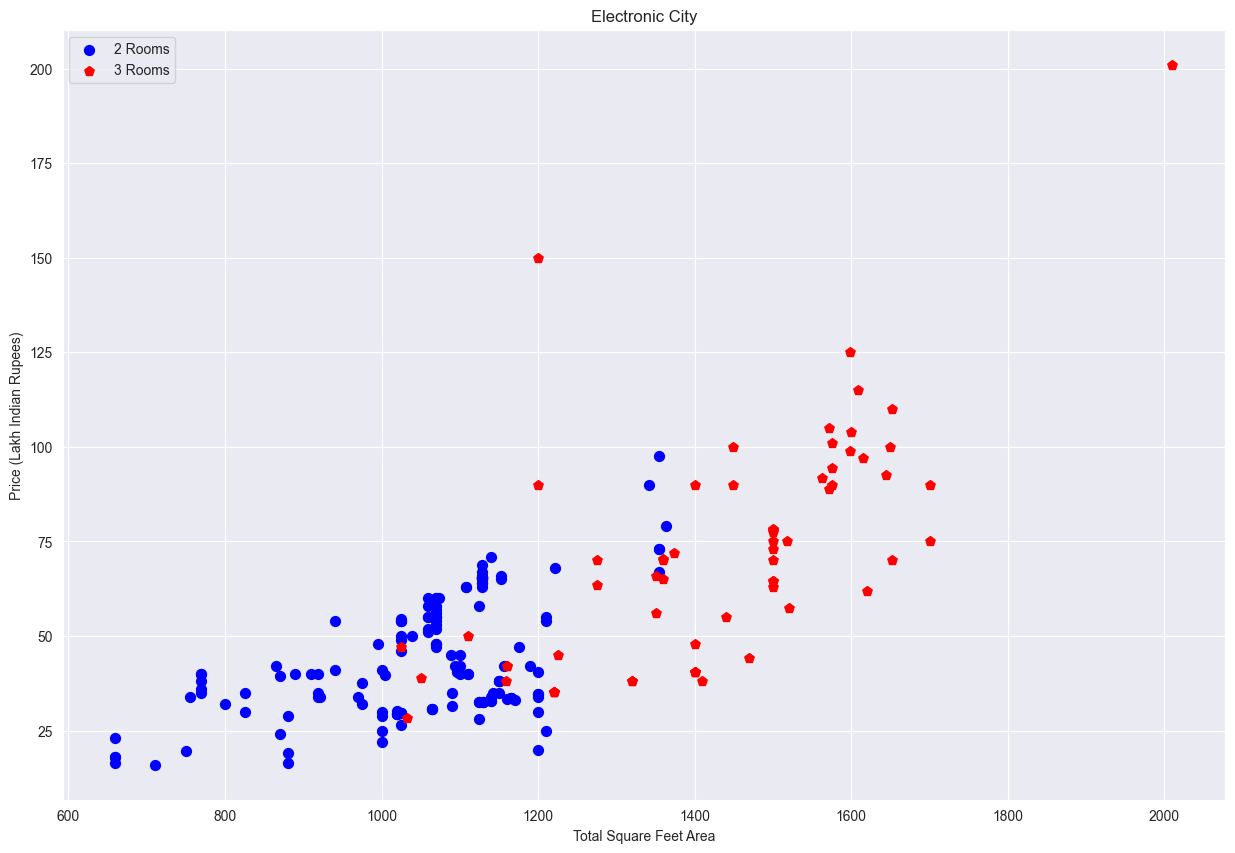

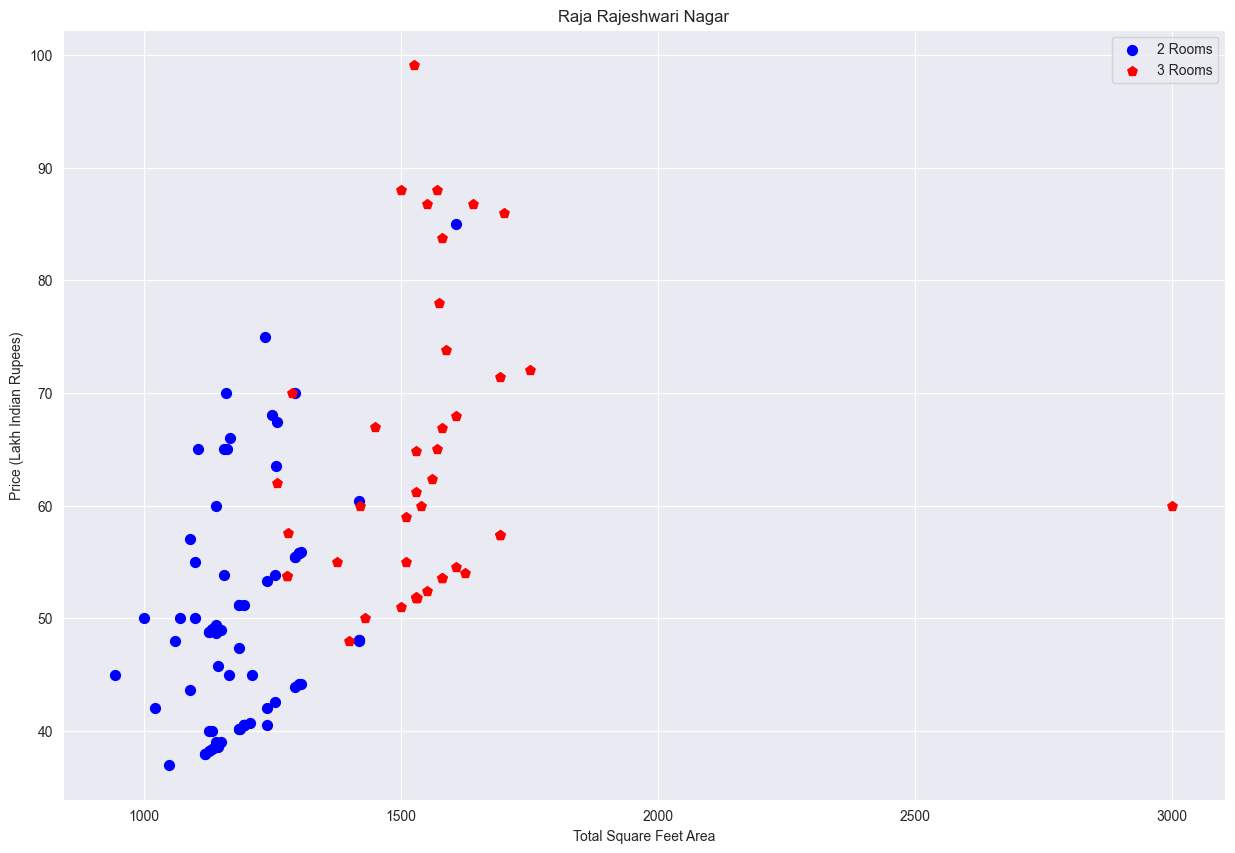

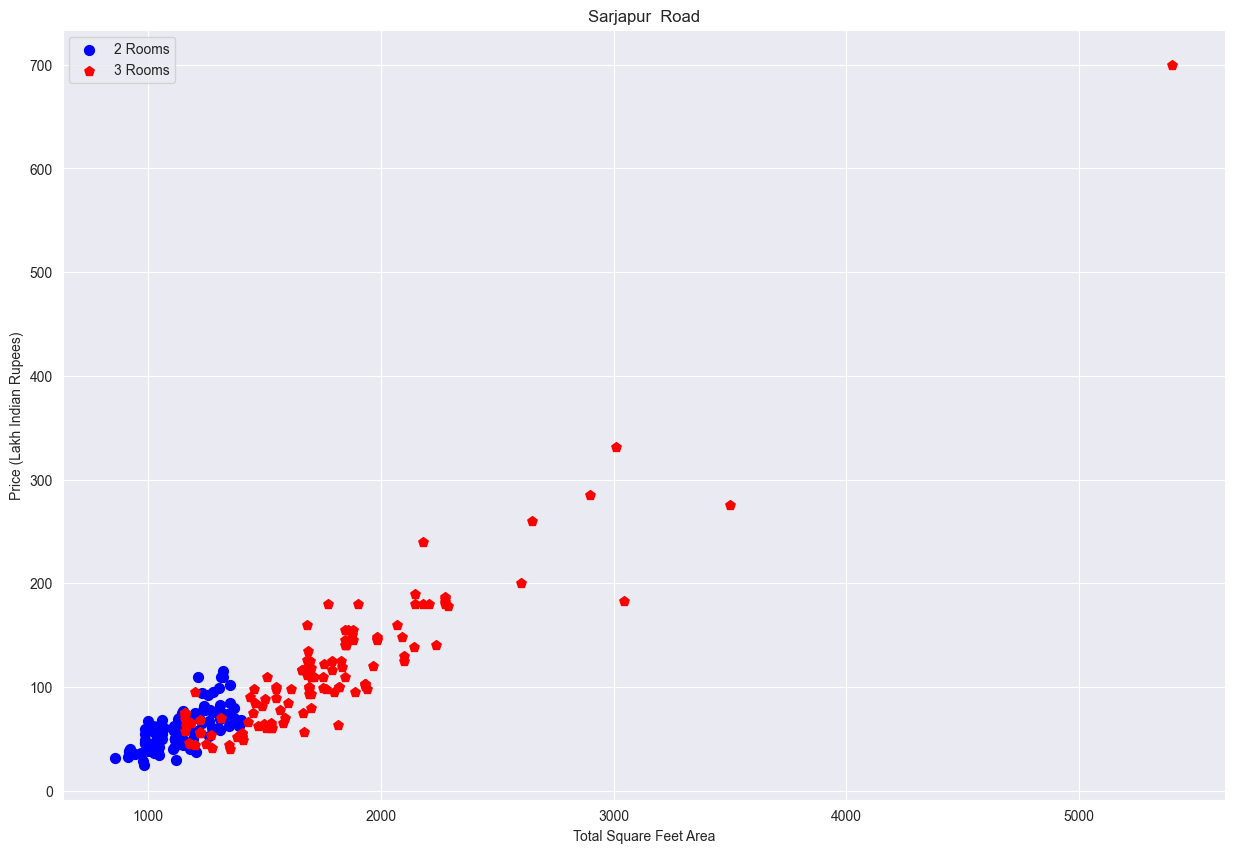

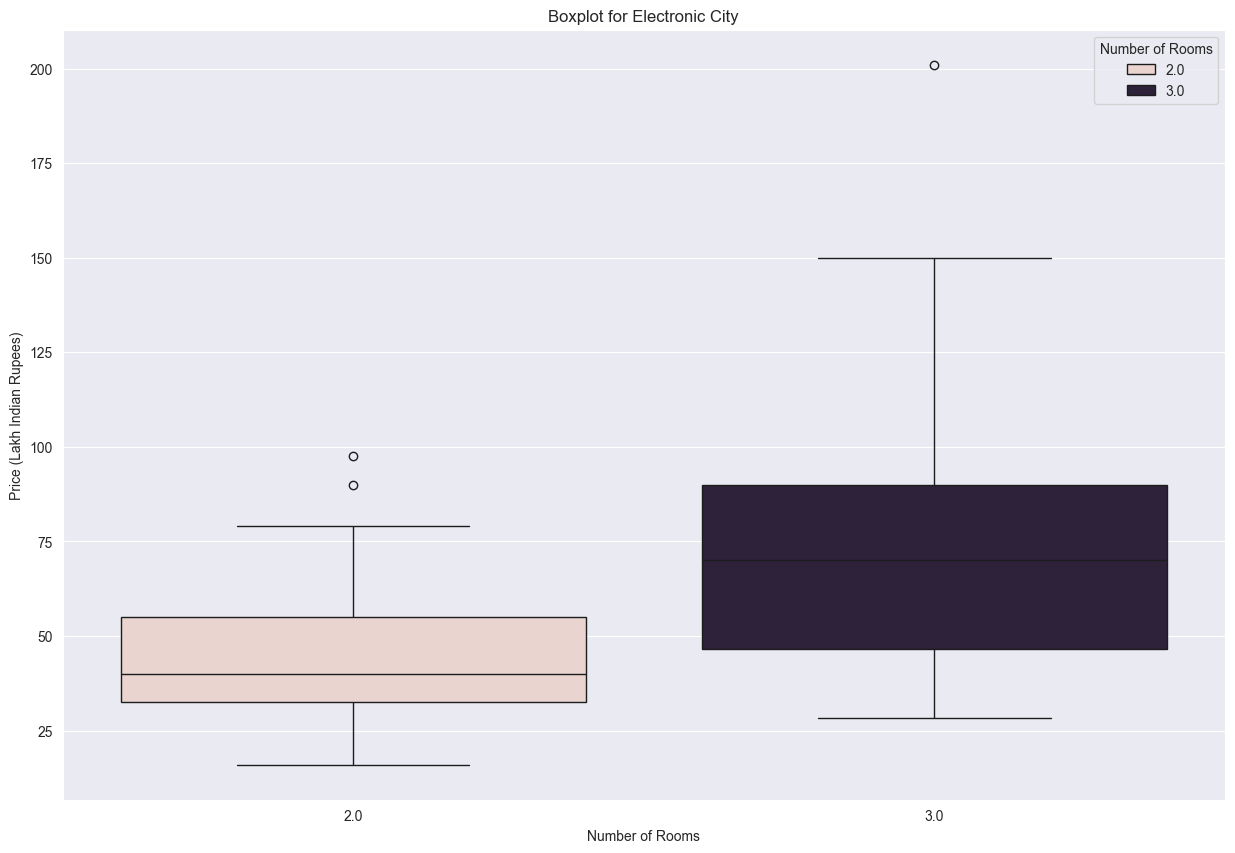

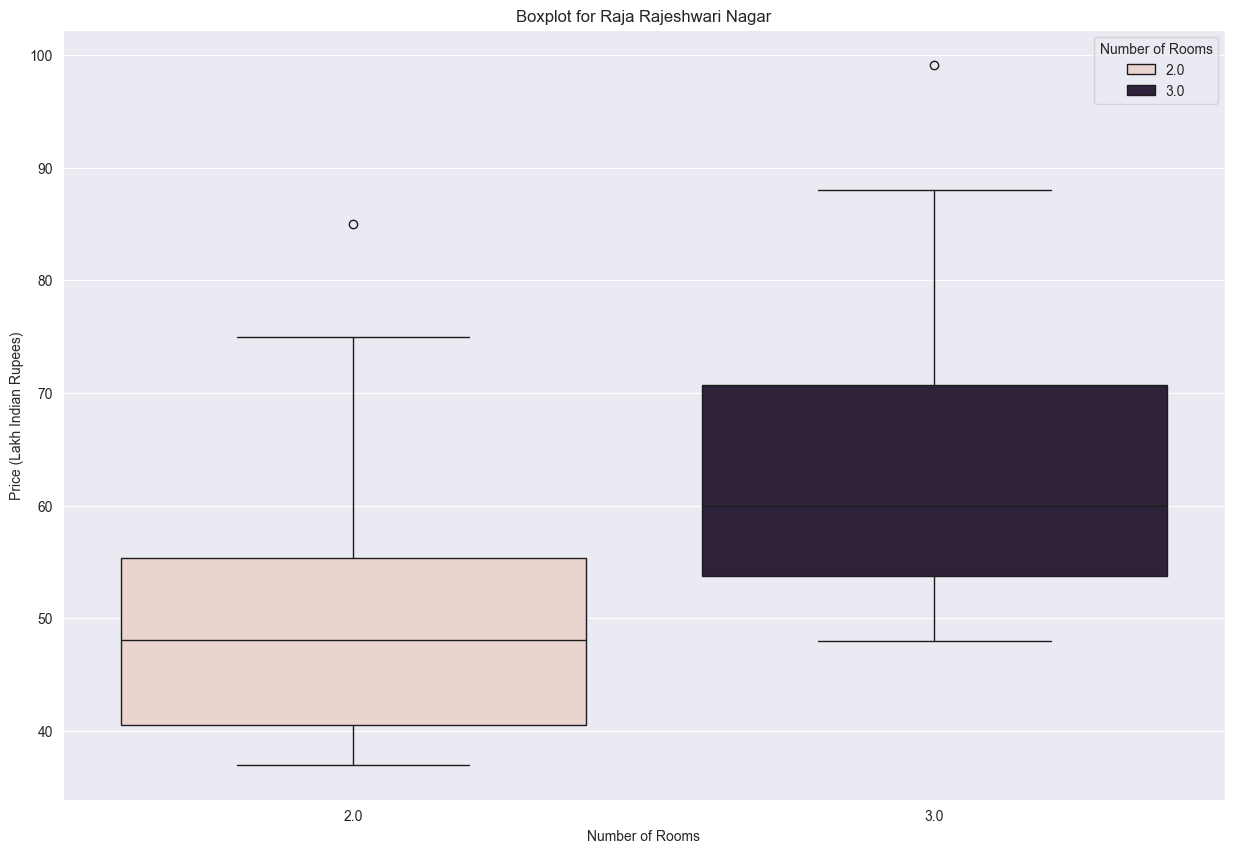

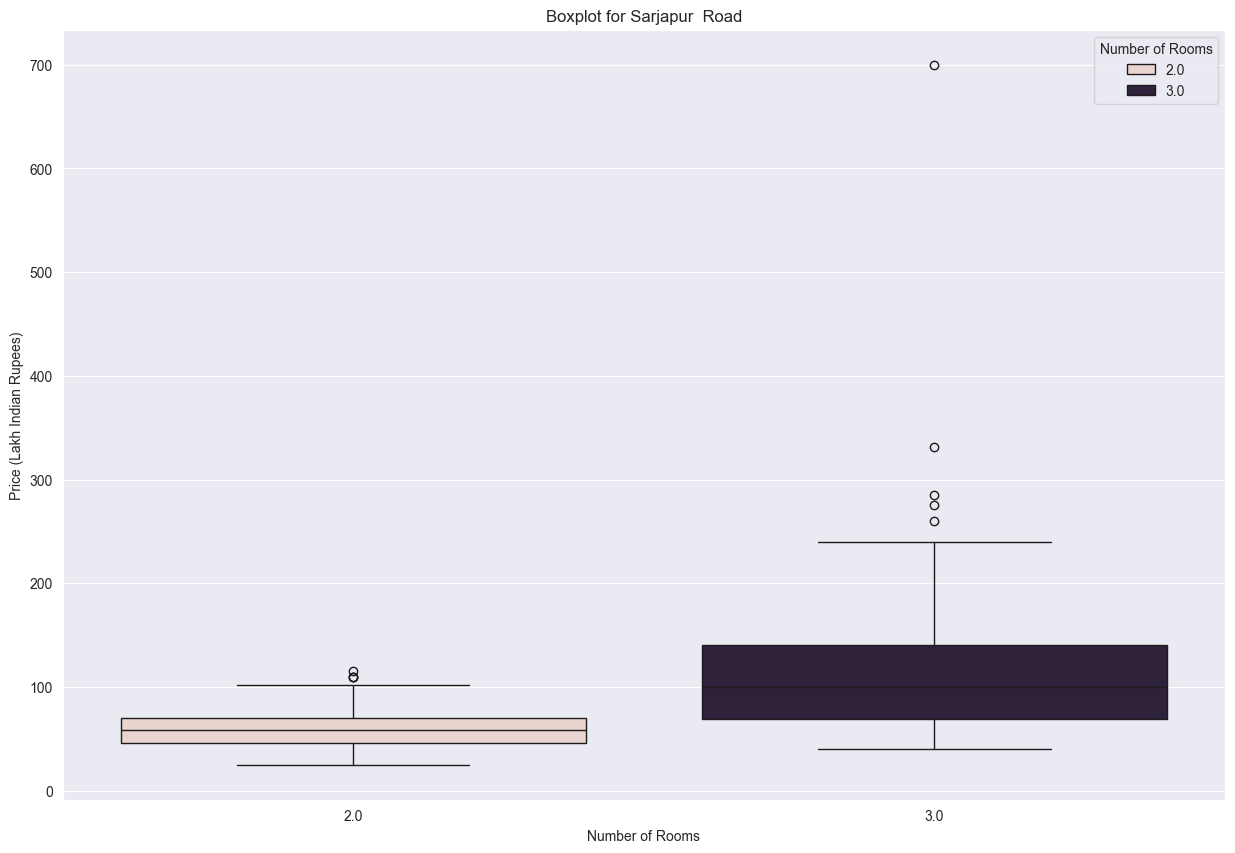

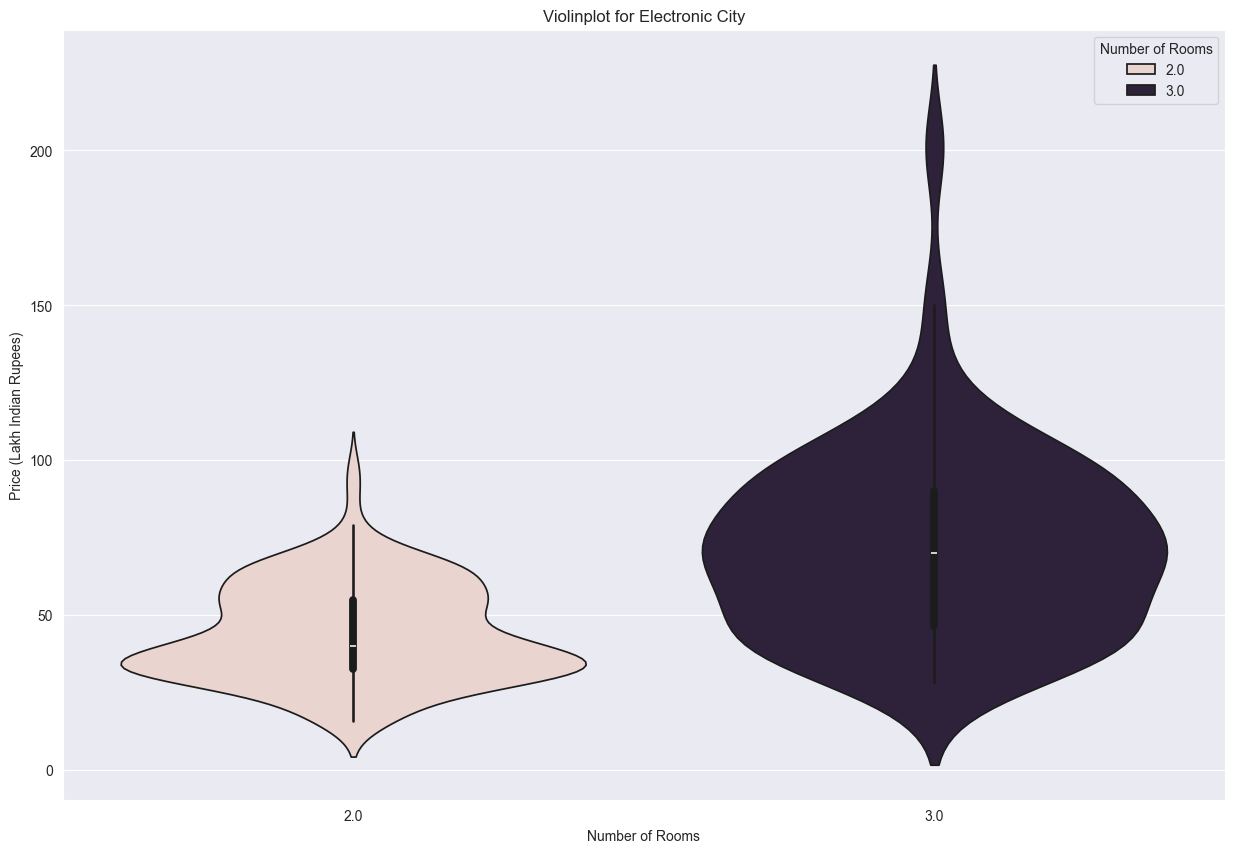

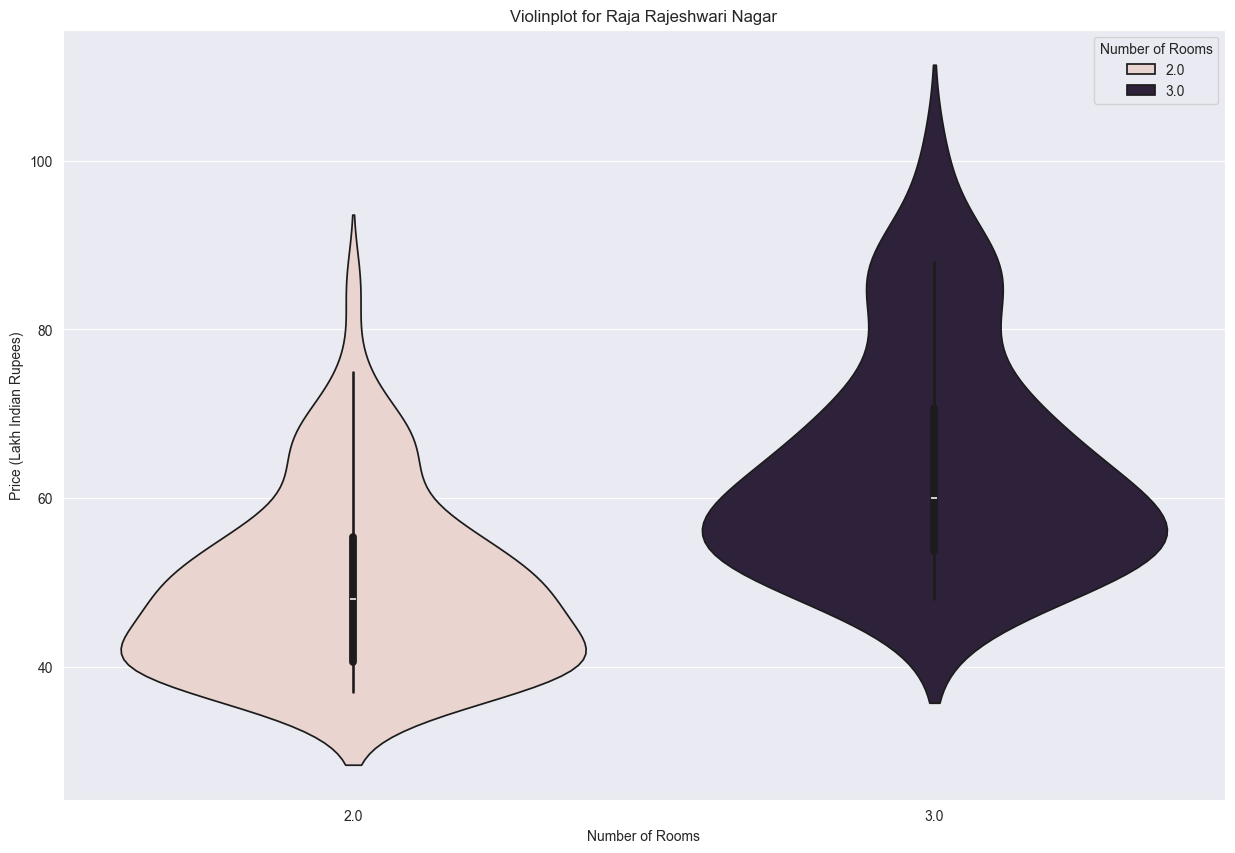

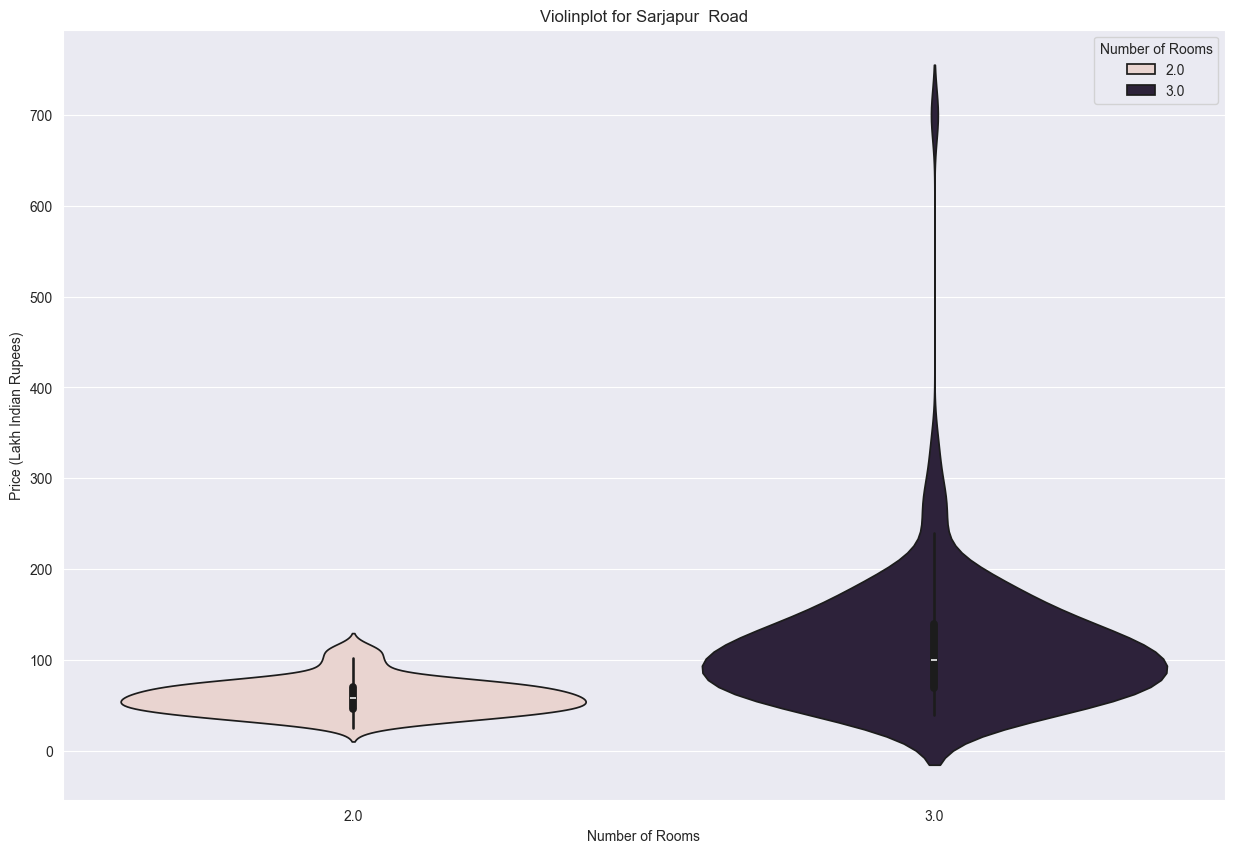

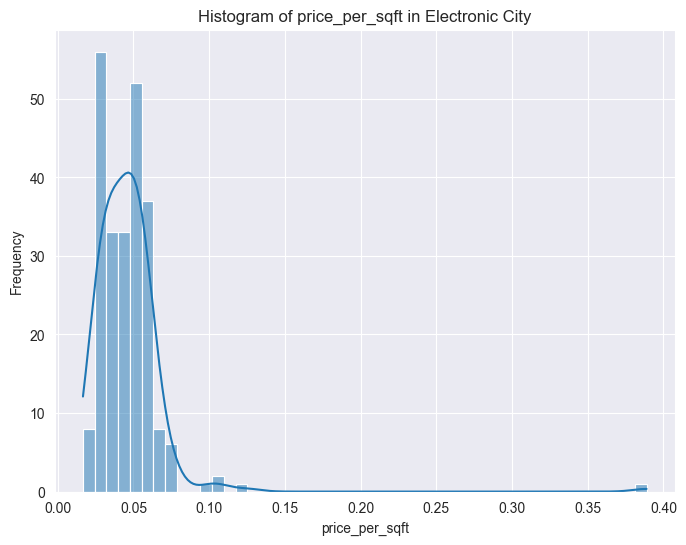

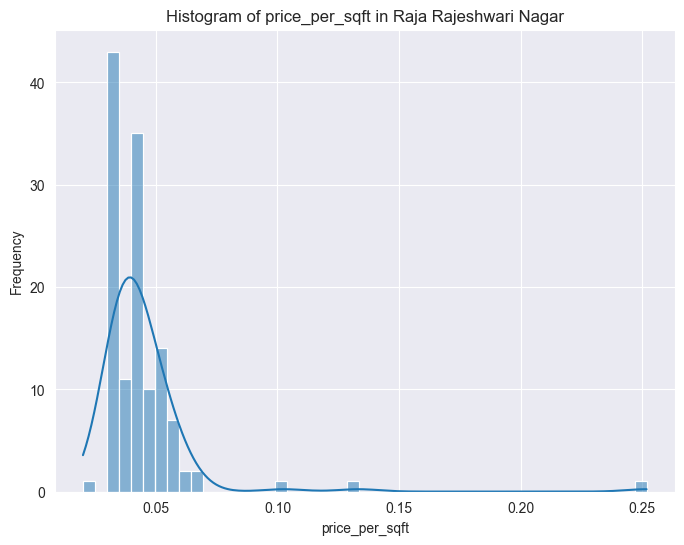

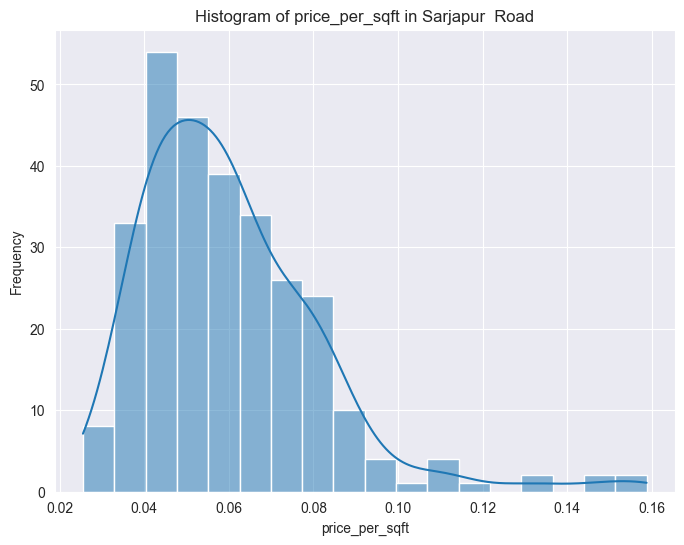

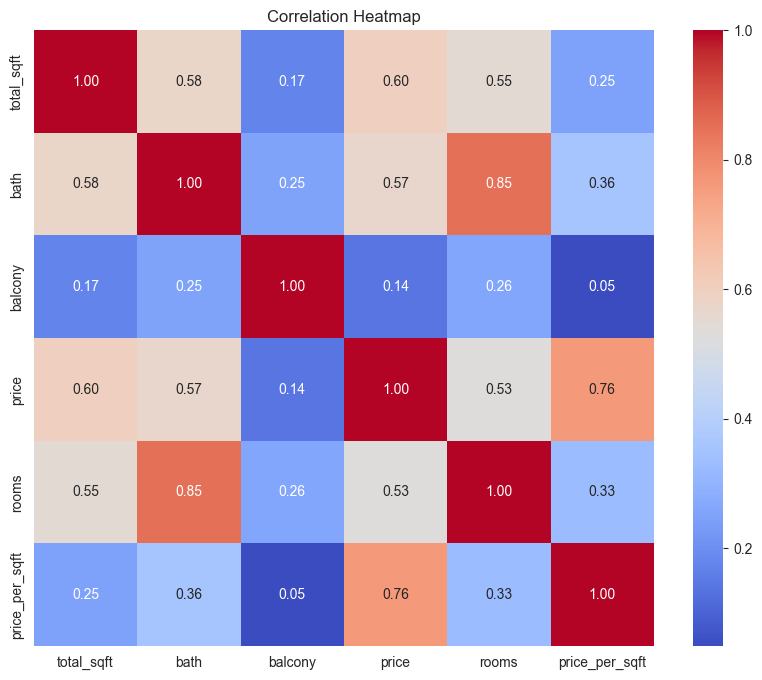

In [95]:
# Show data before outliers in scatter chart
vd.plot_scatter_chart(remove_price_by_square_feat.data_train, "Electronic City")
vd.plot_scatter_chart(remove_price_by_square_feat.data_train, "Raja Rajeshwari Nagar")
vd.plot_scatter_chart(remove_price_by_square_feat.data_train, "Sarjapur  Road")

# Show data before outliers in box plots
vd.plot_boxplot(remove_price_by_square_feat.data_train, "Electronic City")
vd.plot_boxplot(remove_price_by_square_feat.data_train, "Raja Rajeshwari Nagar")
vd.plot_boxplot(remove_price_by_square_feat.data_train, "Sarjapur  Road")

# Show data before outliers in violins plot
vd.plot_violinplot(remove_price_by_square_feat.data_train, "Electronic City")
vd.plot_violinplot(remove_price_by_square_feat.data_train, "Raja Rajeshwari Nagar")
vd.plot_violinplot(remove_price_by_square_feat.data_train, "Sarjapur  Road")

# Show data before outliers in histograms
vd.plot_histogram(remove_price_by_square_feat.data_train, "price_per_sqft", "Electronic City")
vd.plot_histogram(remove_price_by_square_feat.data_train, "price_per_sqft", "Raja Rajeshwari Nagar")
vd.plot_histogram(remove_price_by_square_feat.data_train, "price_per_sqft", "Sarjapur  Road")

# Show heatmap with correlations
vd.plot_heatmap(remove_price_by_square_feat.data_train)

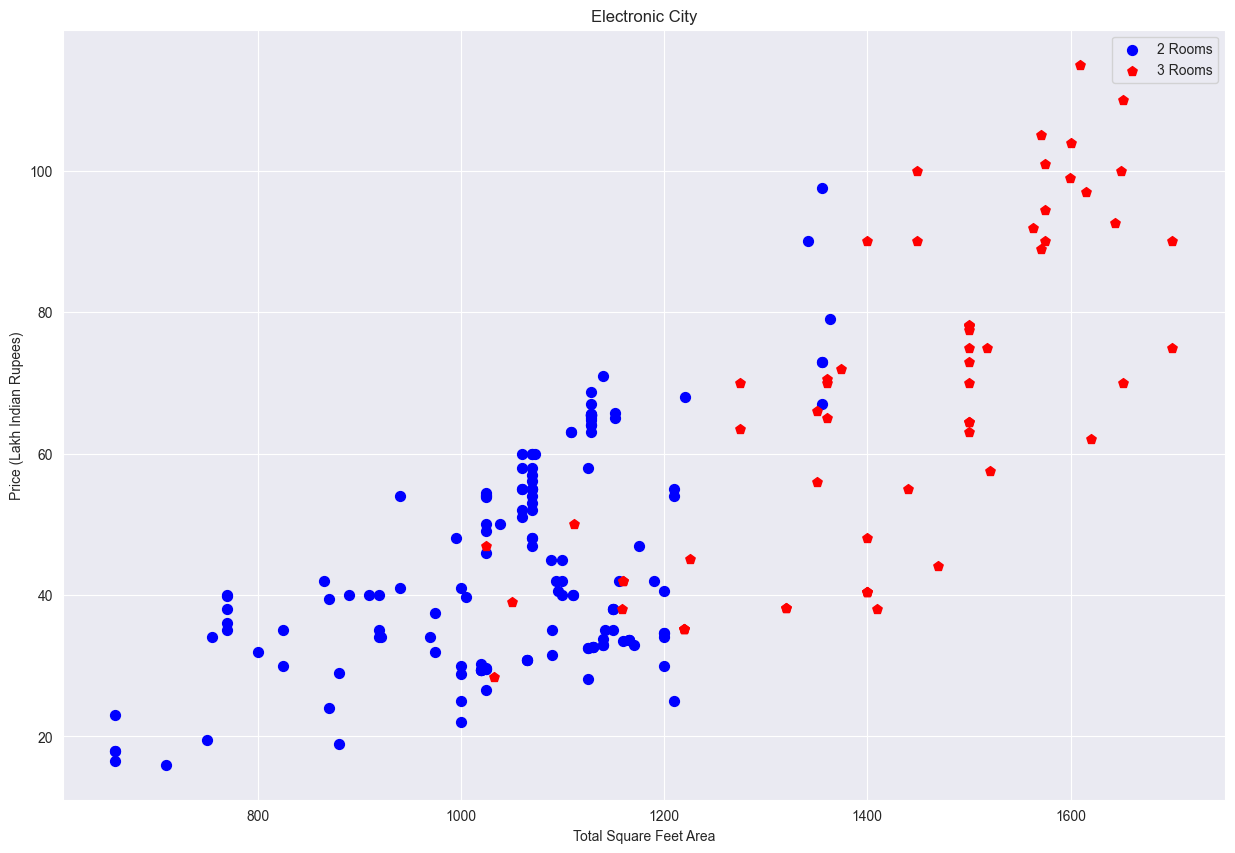

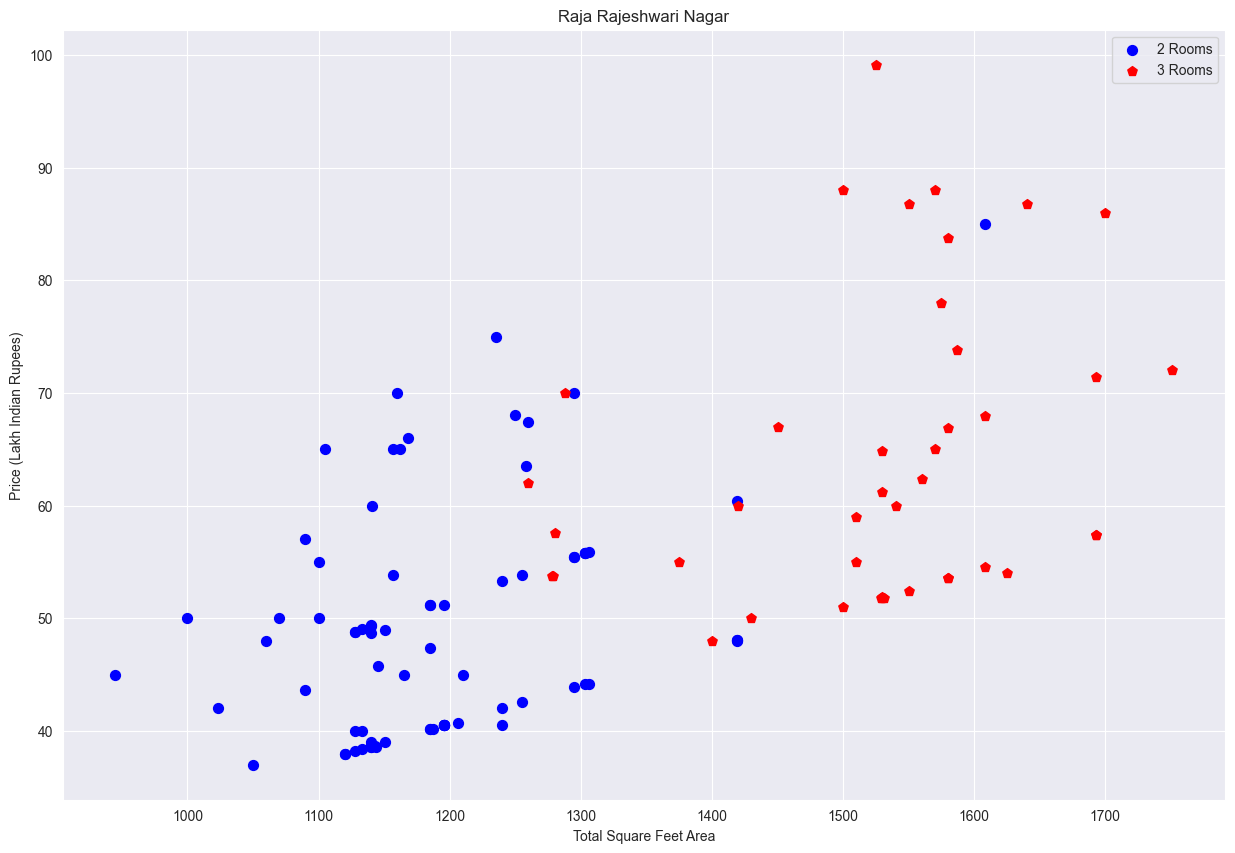

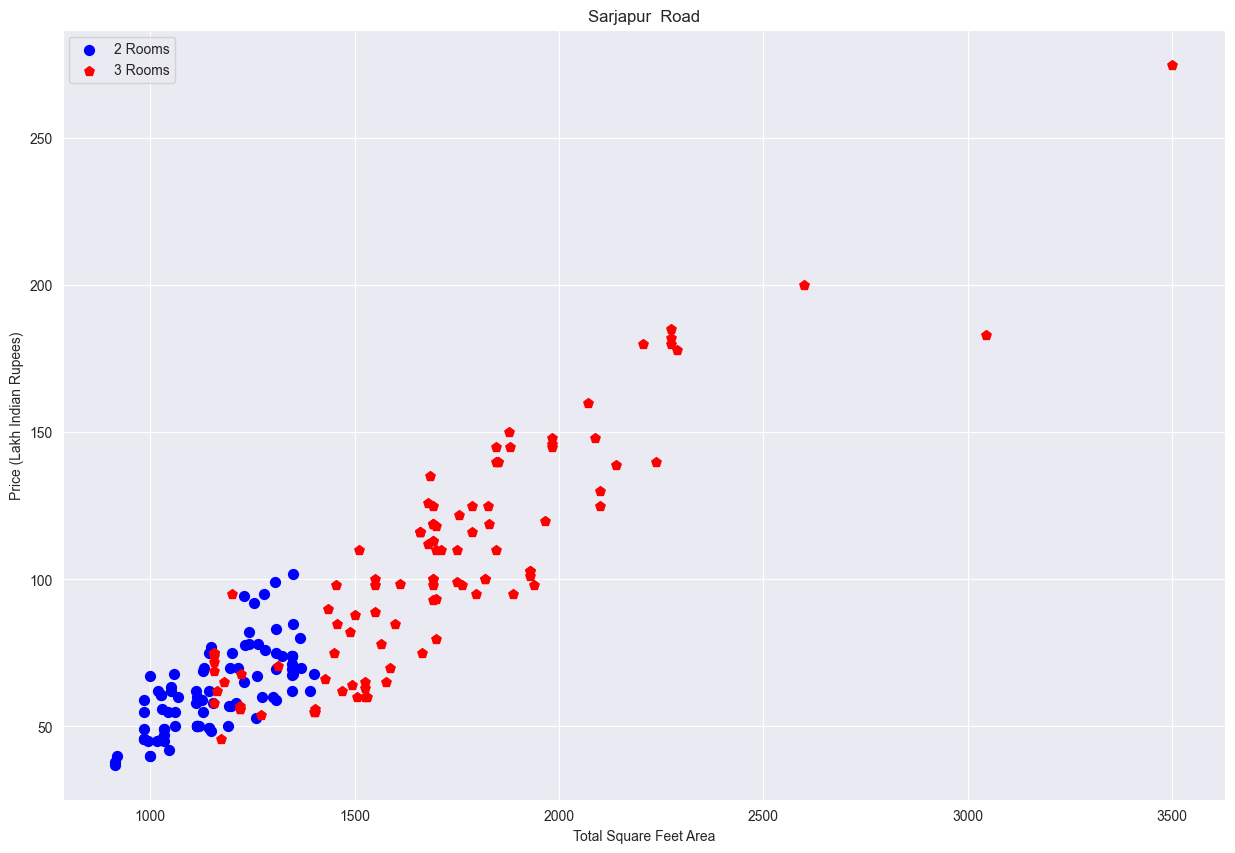

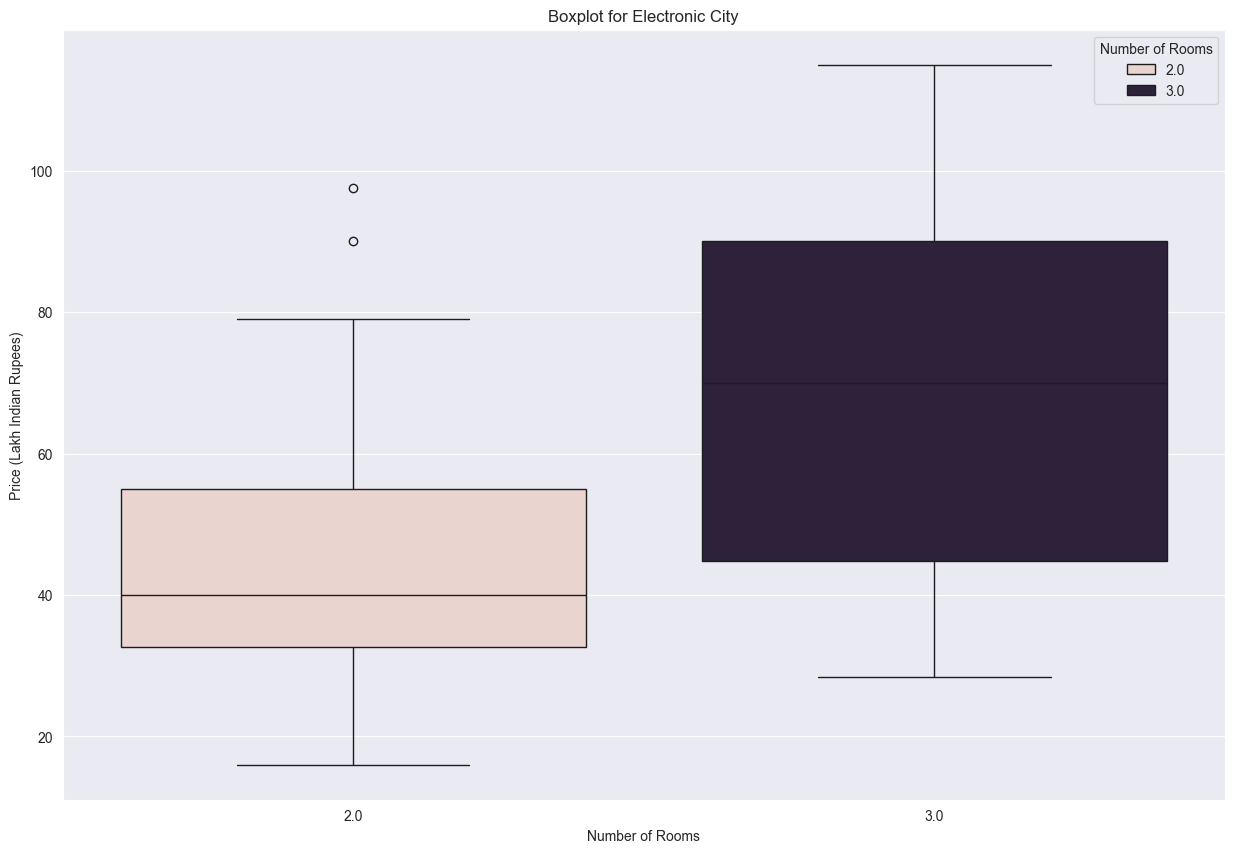

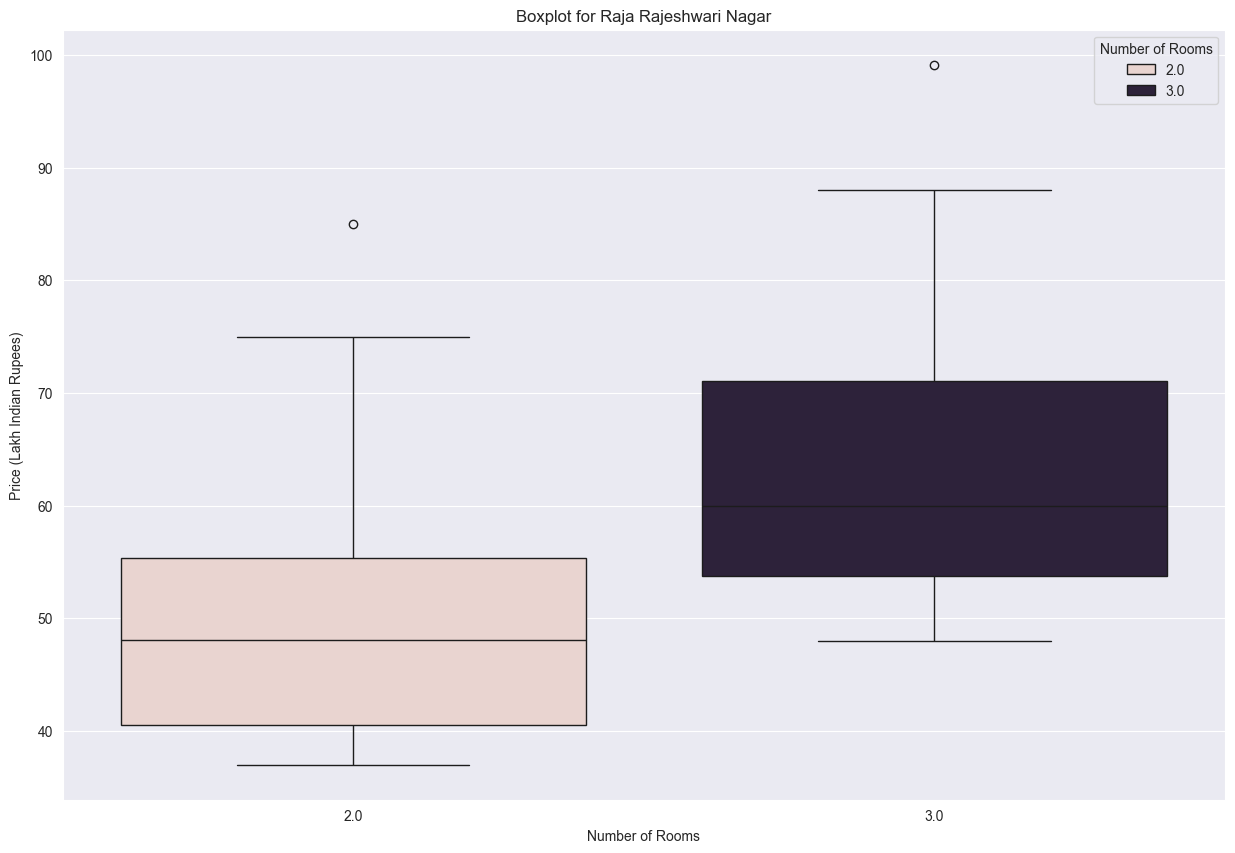

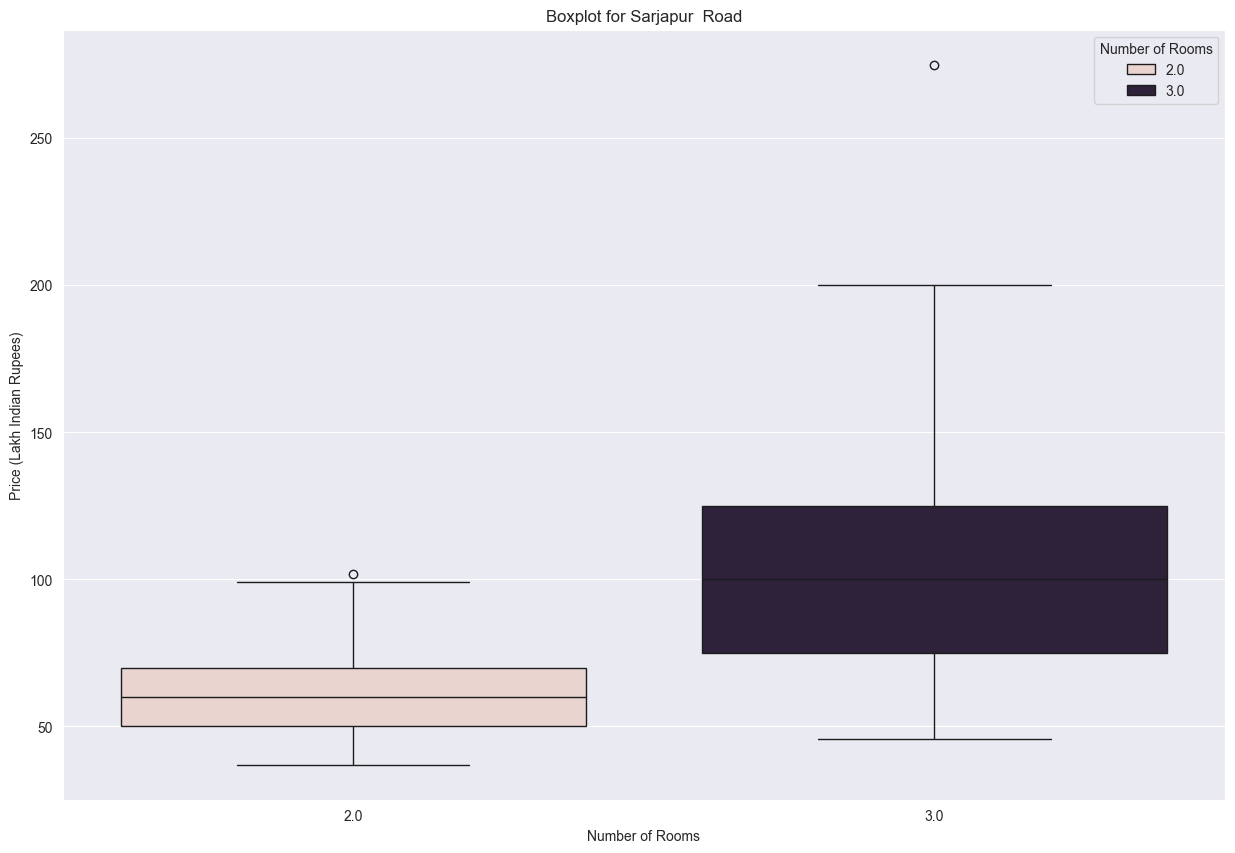

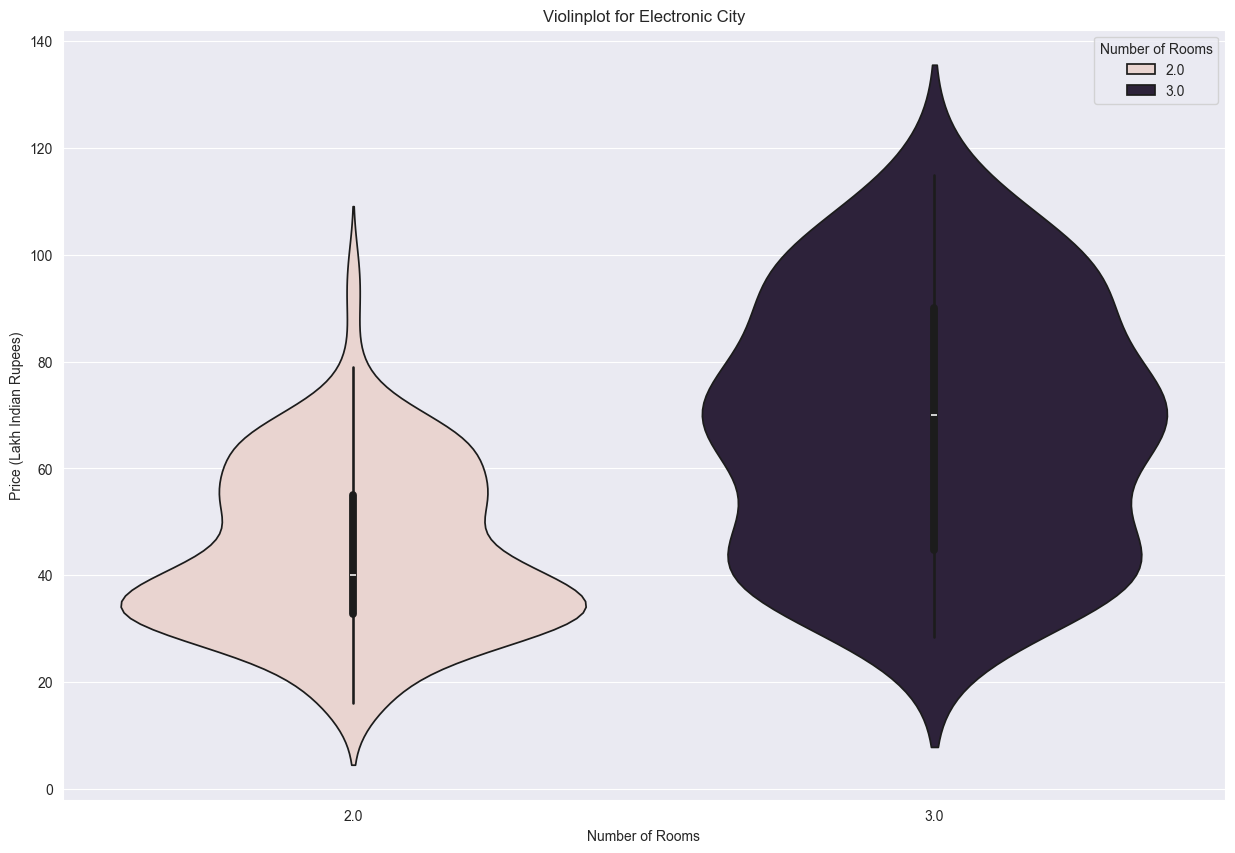

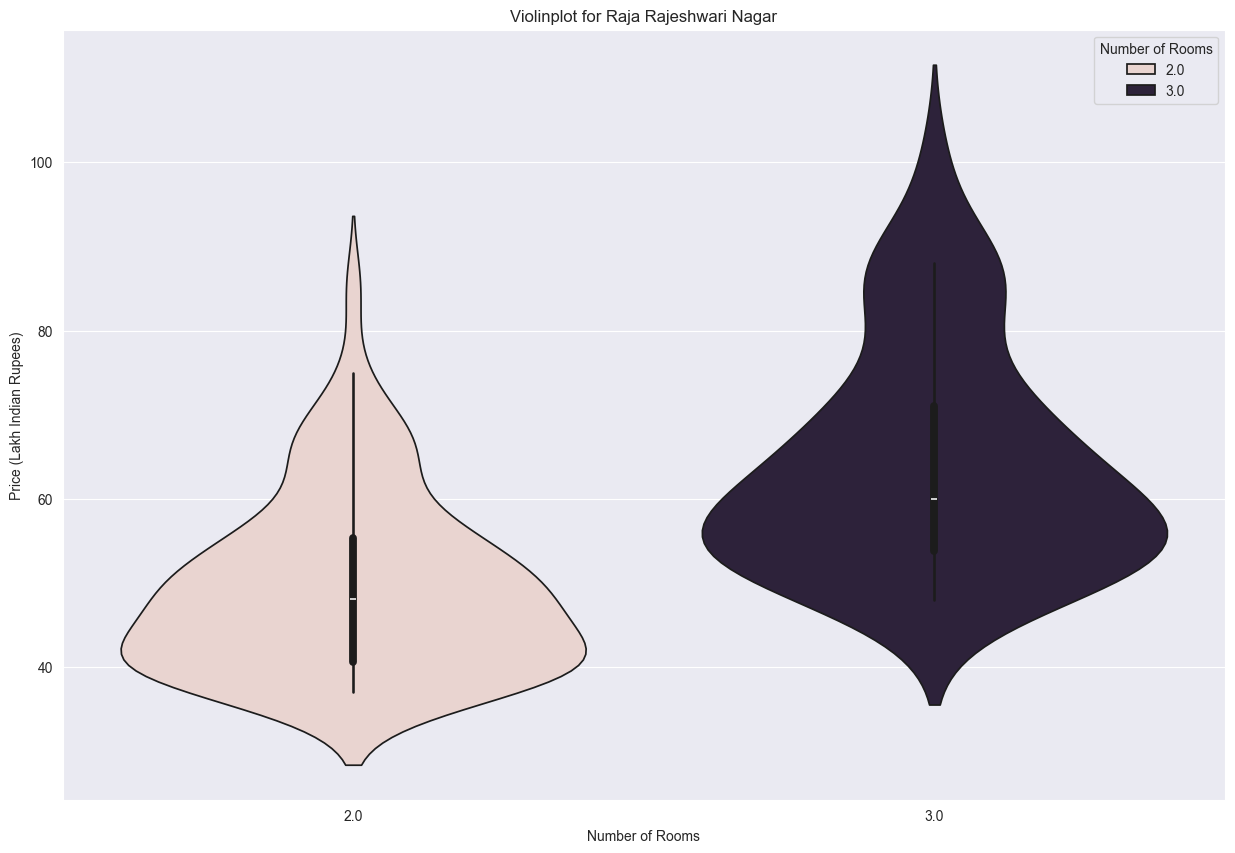

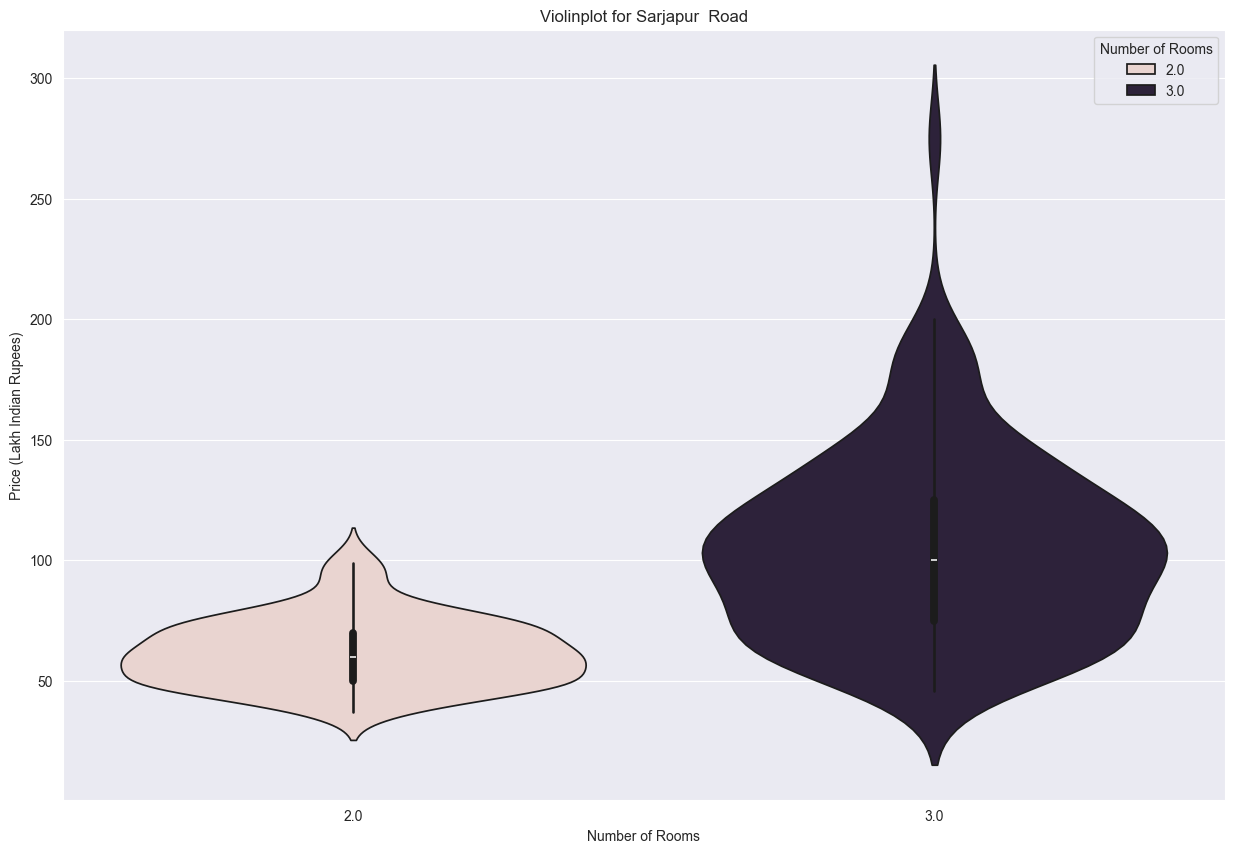

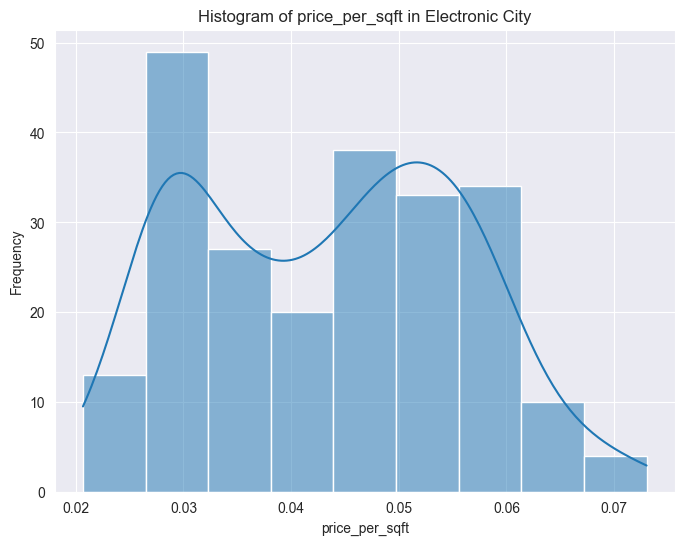

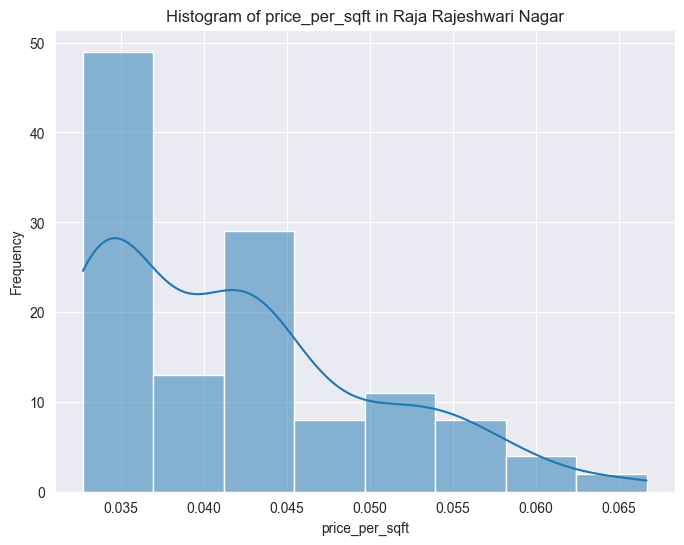

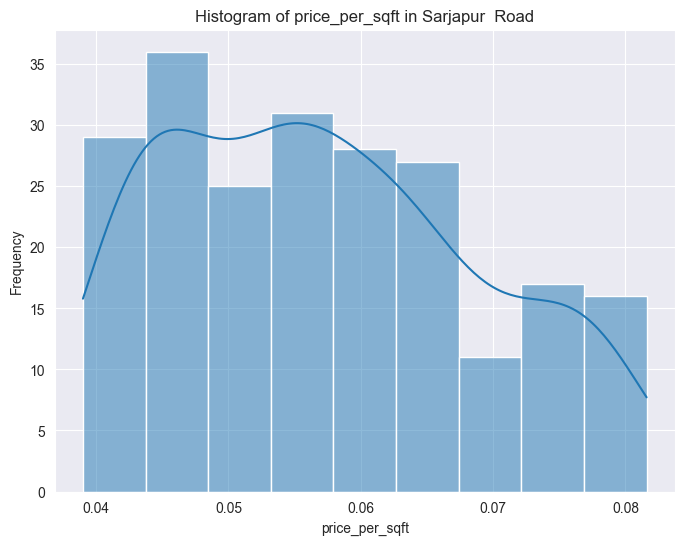

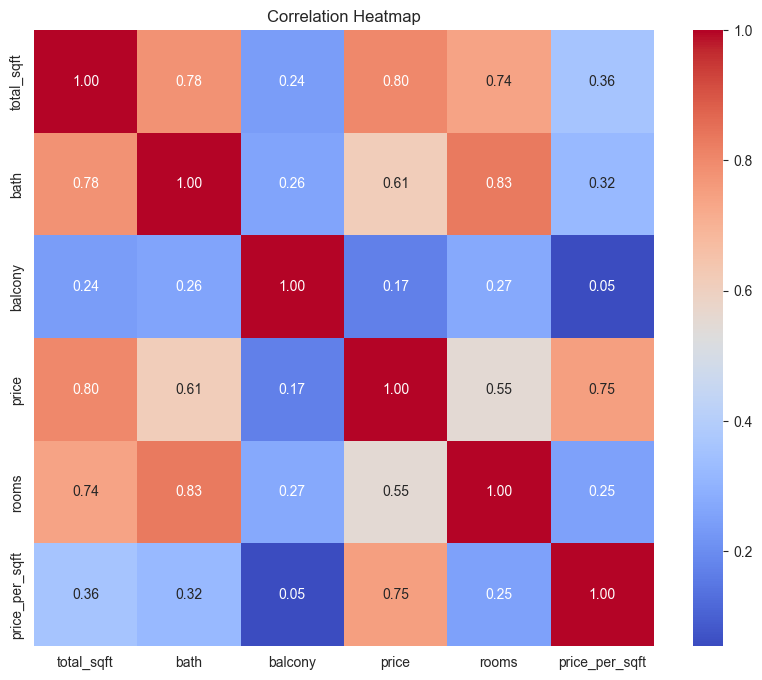

In [96]:
# See the scatter plots before the second removal
vd.plot_scatter_chart(remove_price_location.data_train, "Electronic City")
vd.plot_scatter_chart(remove_price_location.data_train, "Raja Rajeshwari Nagar")
vd.plot_scatter_chart(remove_price_location.data_train, "Sarjapur  Road")

# Show data before the second removal in box plots
vd.plot_boxplot(remove_price_location.data_train, "Electronic City")
vd.plot_boxplot(remove_price_location.data_train, "Raja Rajeshwari Nagar")
vd.plot_boxplot(remove_price_location.data_train, "Sarjapur  Road")

# Show data before the second removals in violins plot
vd.plot_violinplot(remove_price_location.data_train, "Electronic City")
vd.plot_violinplot(remove_price_location.data_train, "Raja Rajeshwari Nagar")
vd.plot_violinplot(remove_price_location.data_train, "Sarjapur  Road")

# Show data before the second removal in histograms
vd.plot_histogram(remove_price_location.data_train, "price_per_sqft", "Electronic City")
vd.plot_histogram(remove_price_location.data_train, "price_per_sqft", "Raja Rajeshwari Nagar")
vd.plot_histogram(remove_price_location.data_train, "price_per_sqft", "Sarjapur  Road")

# Show heatmap with correlations
vd.plot_heatmap(remove_price_location.data_train)

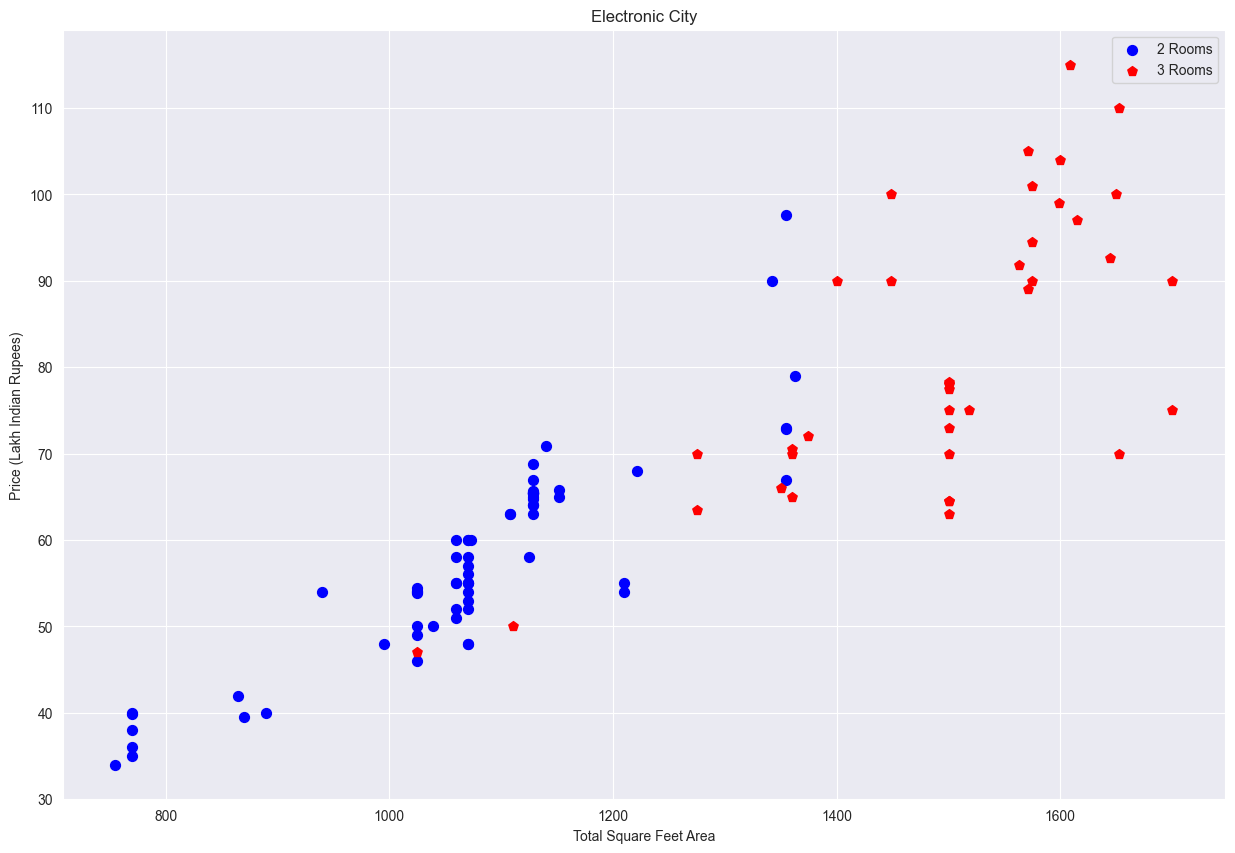

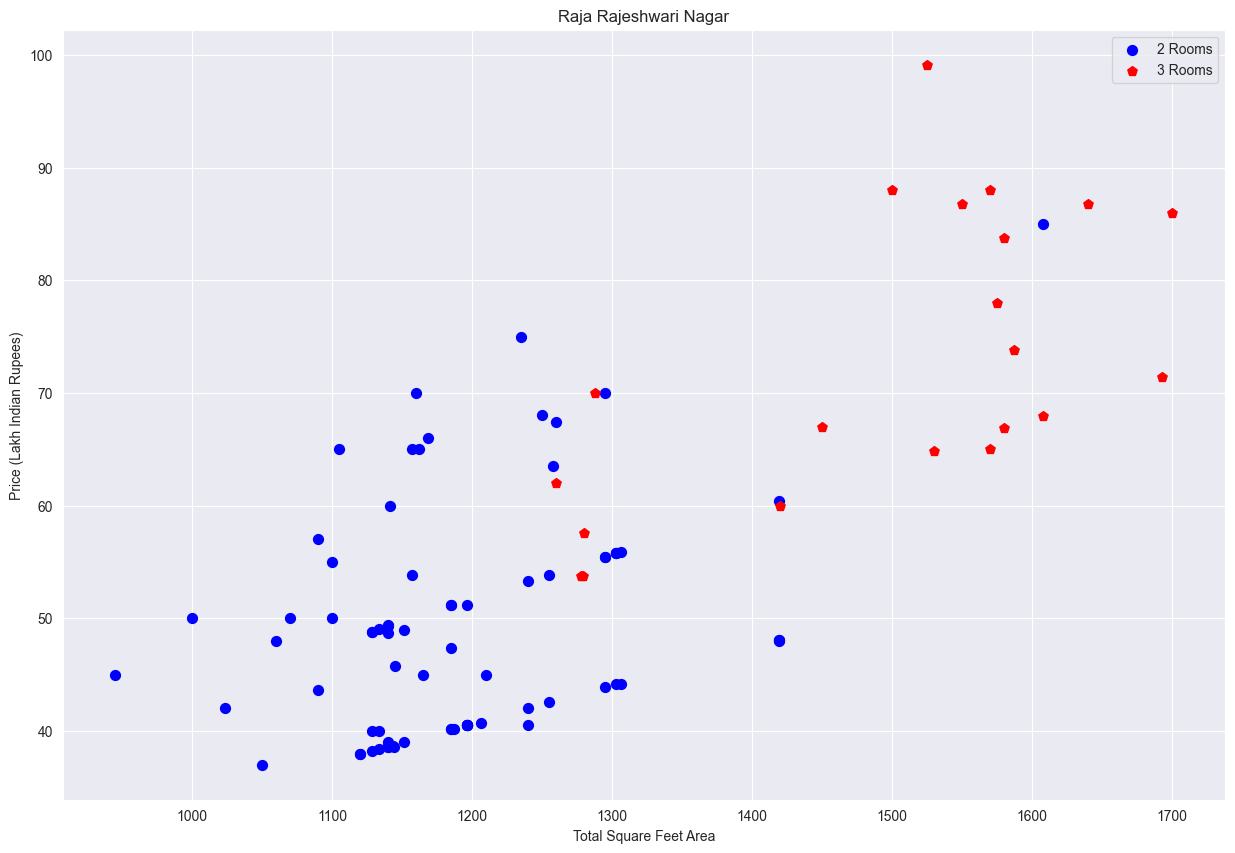

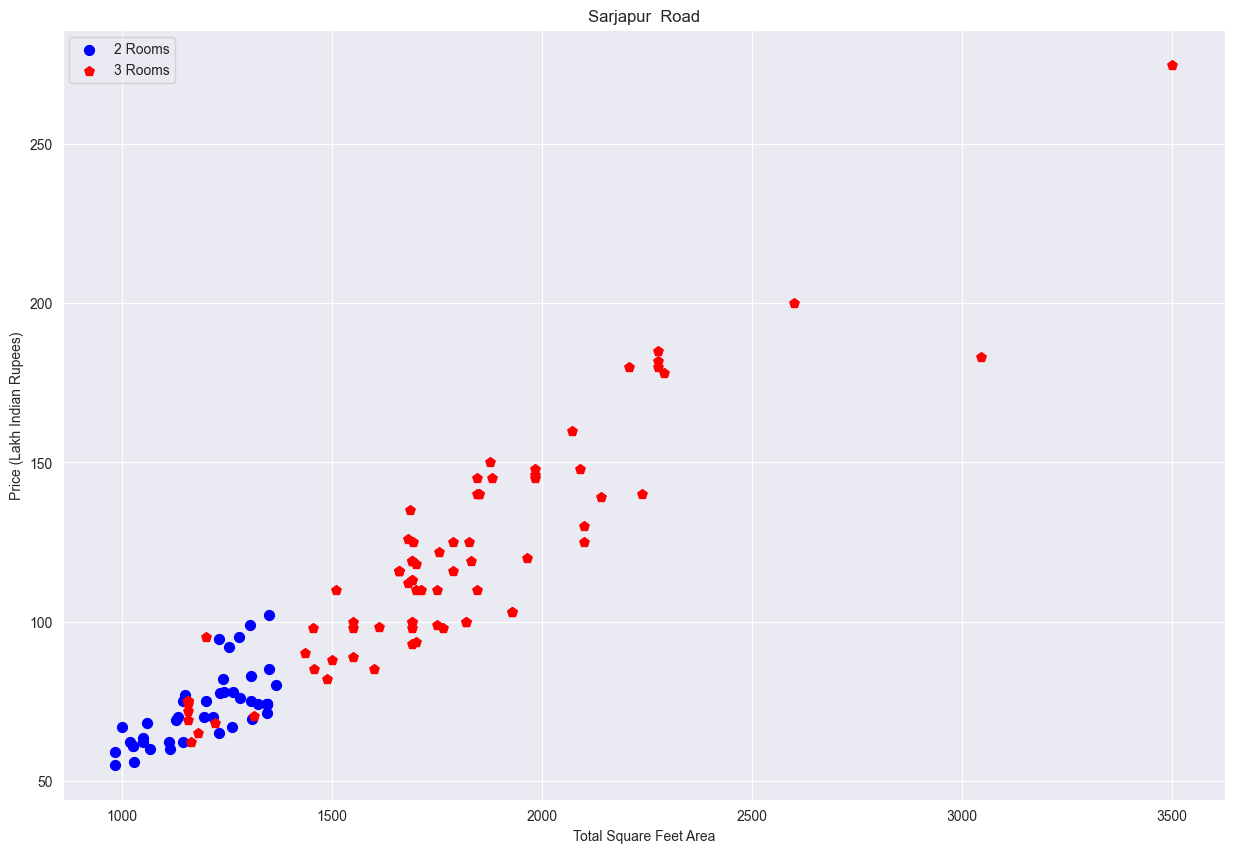

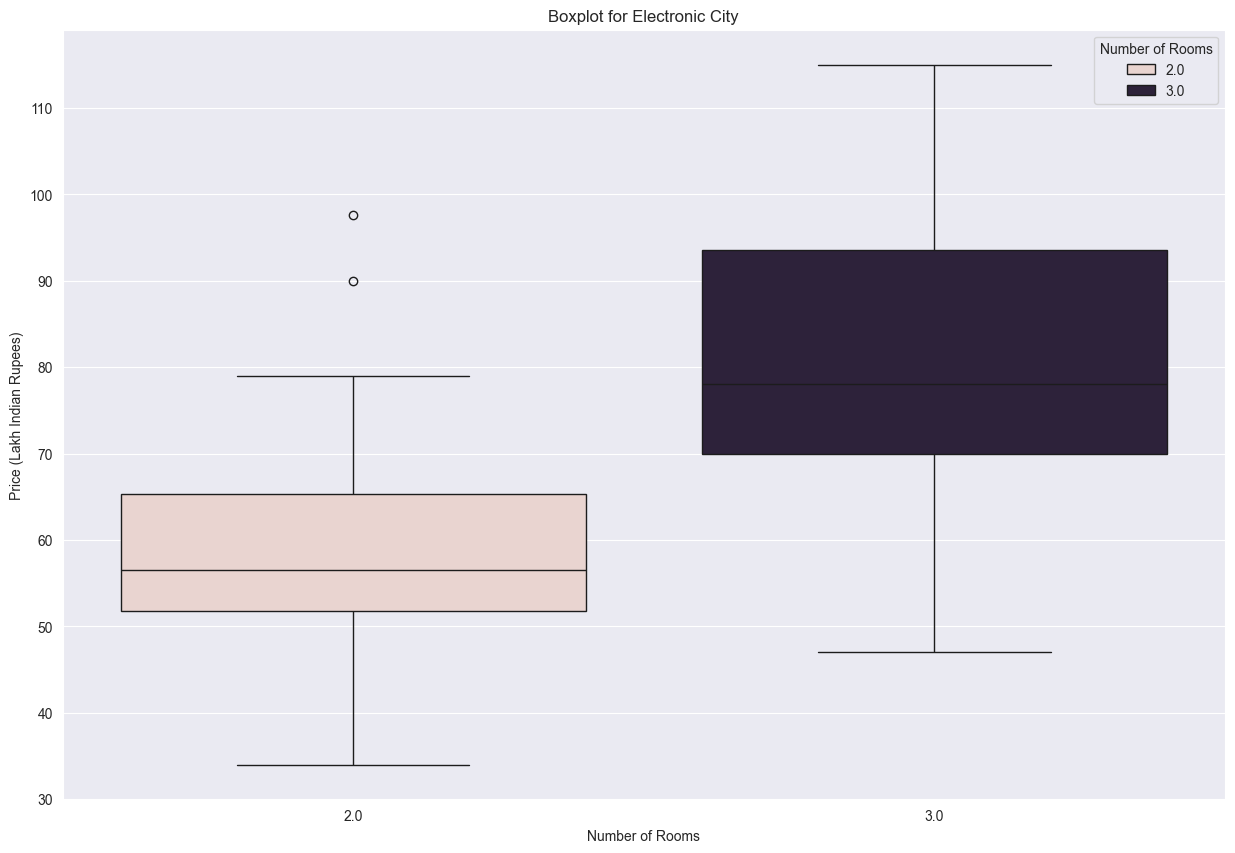

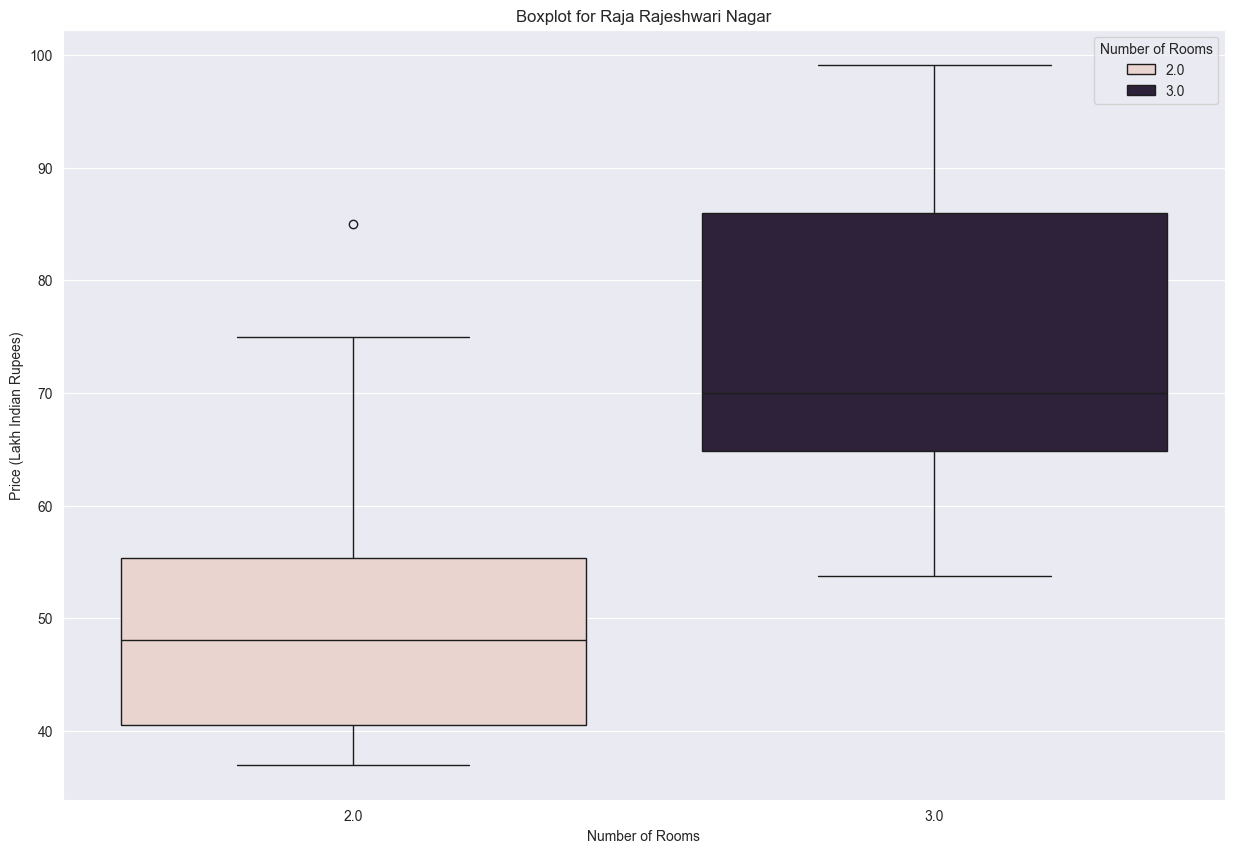

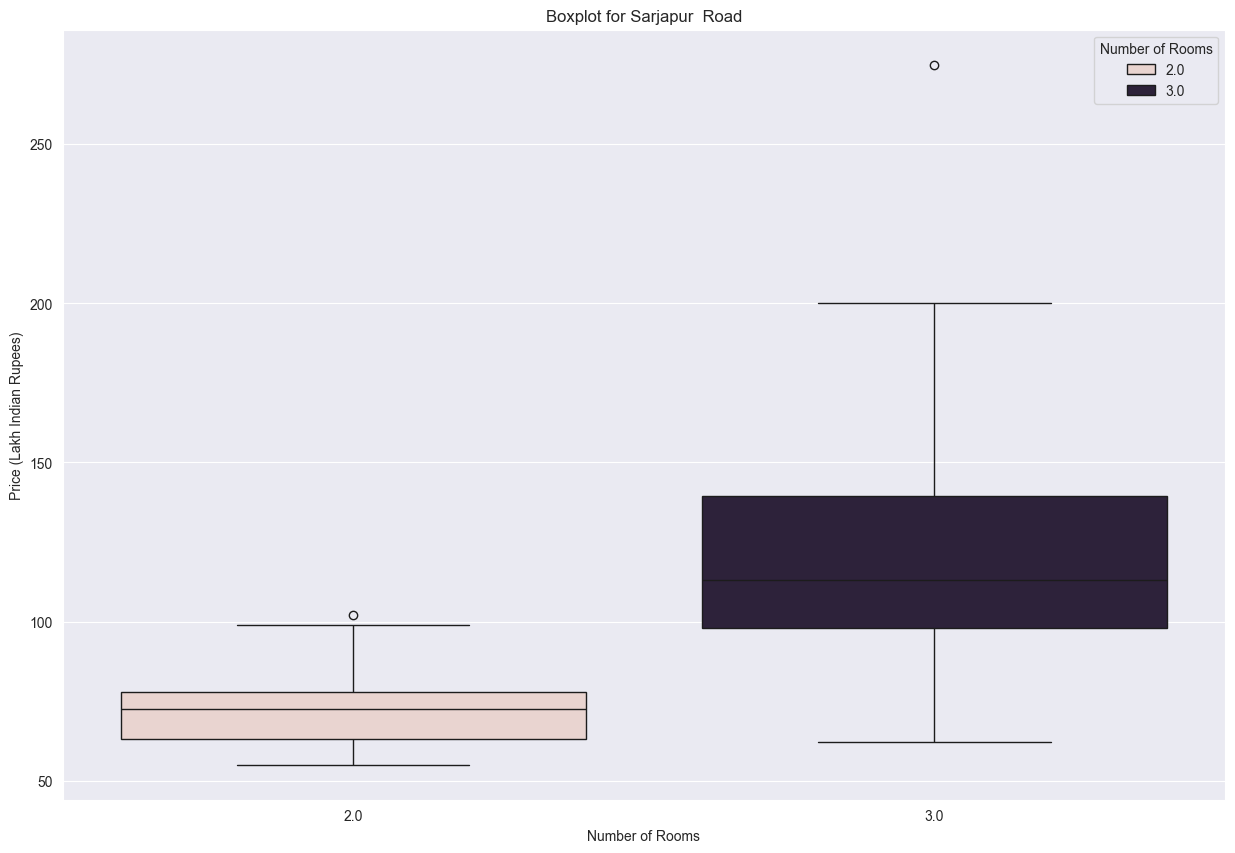

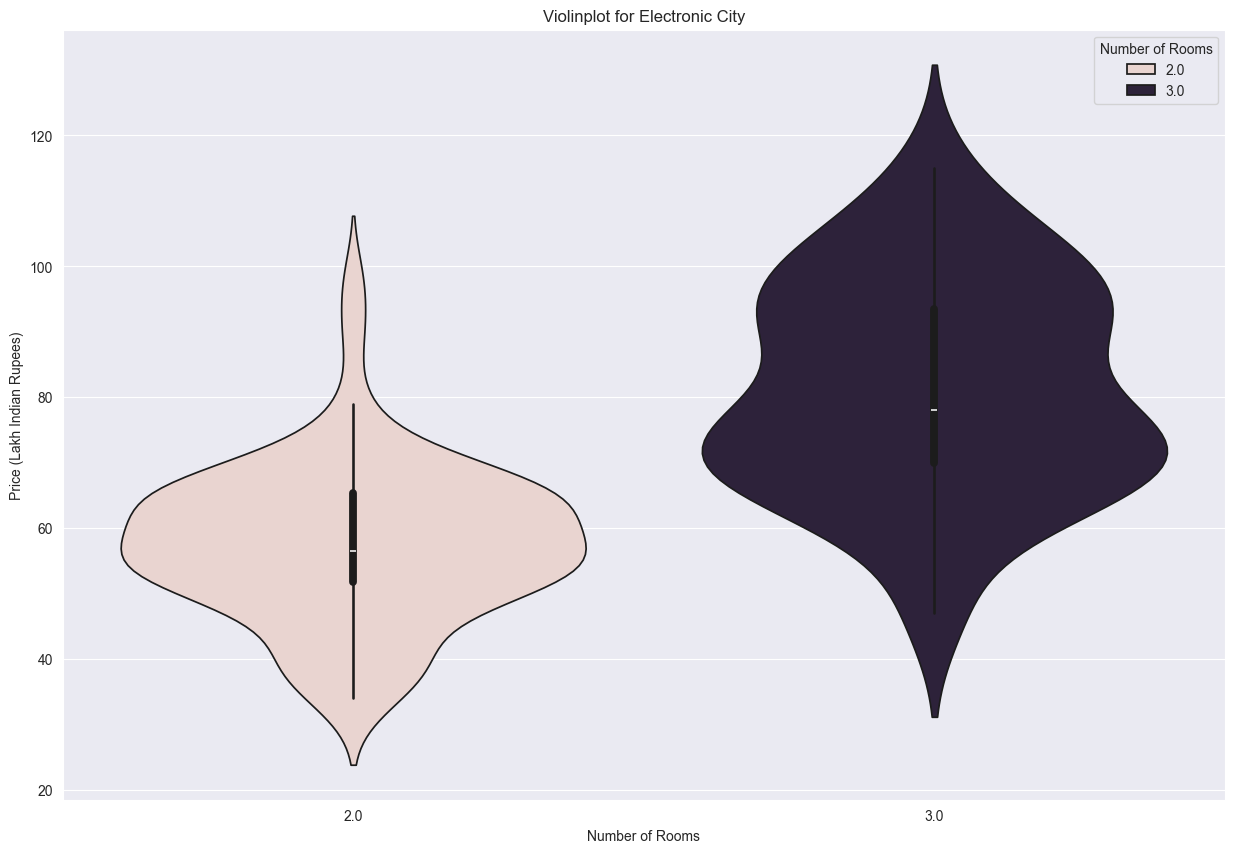

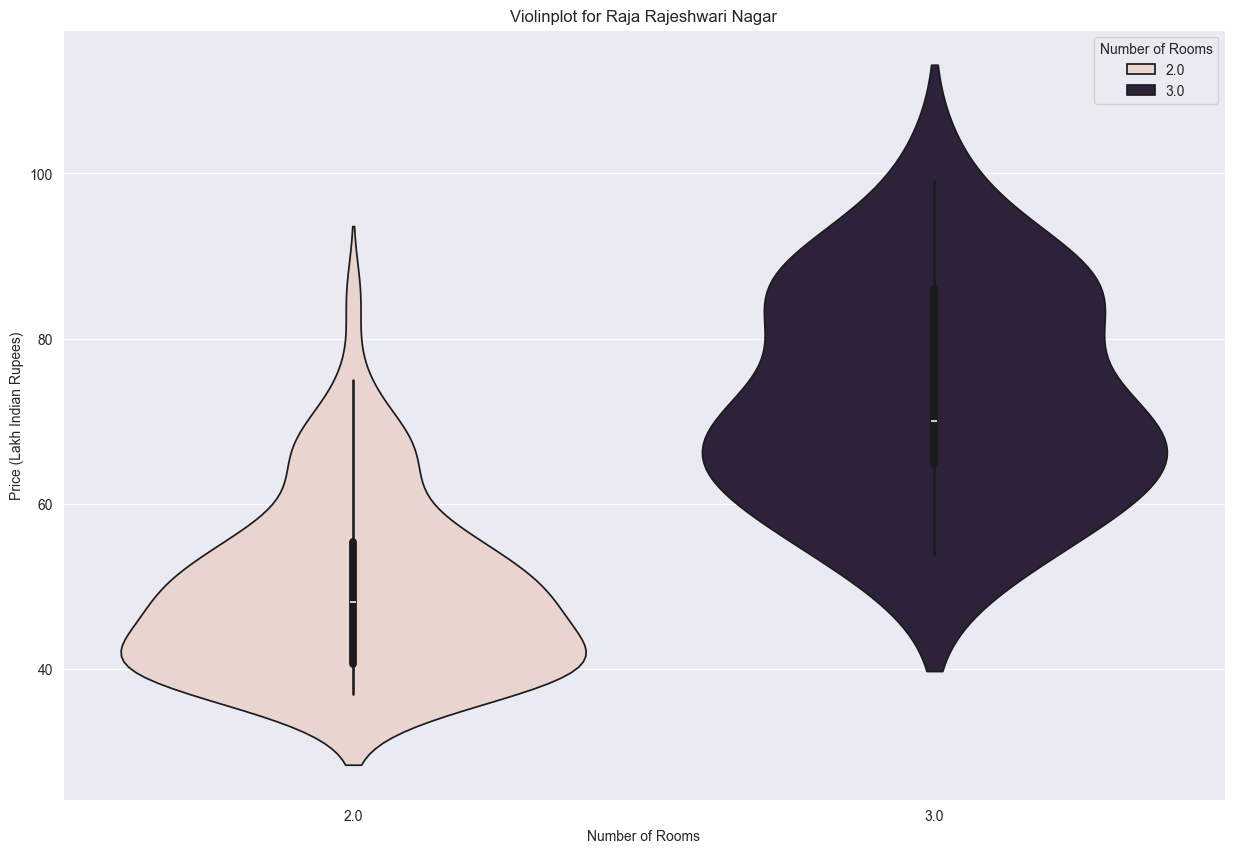

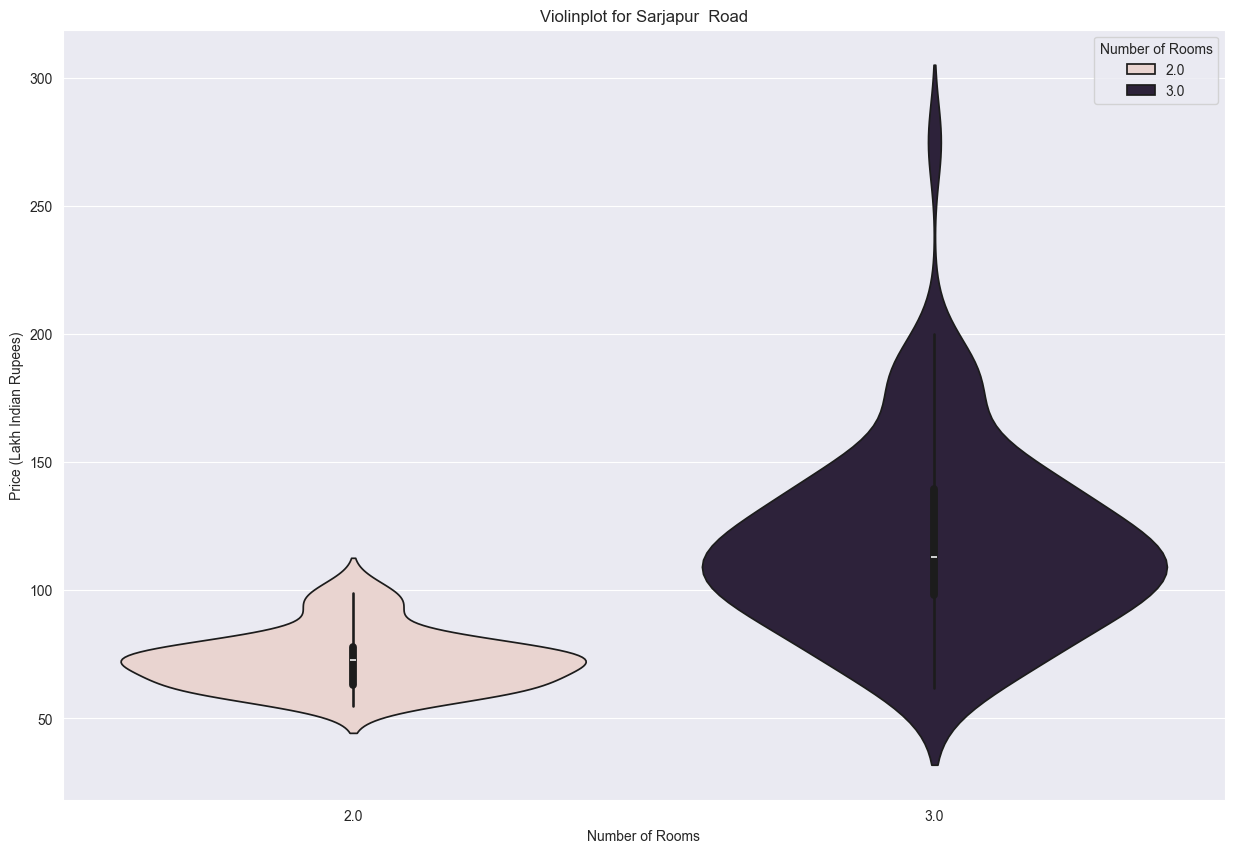

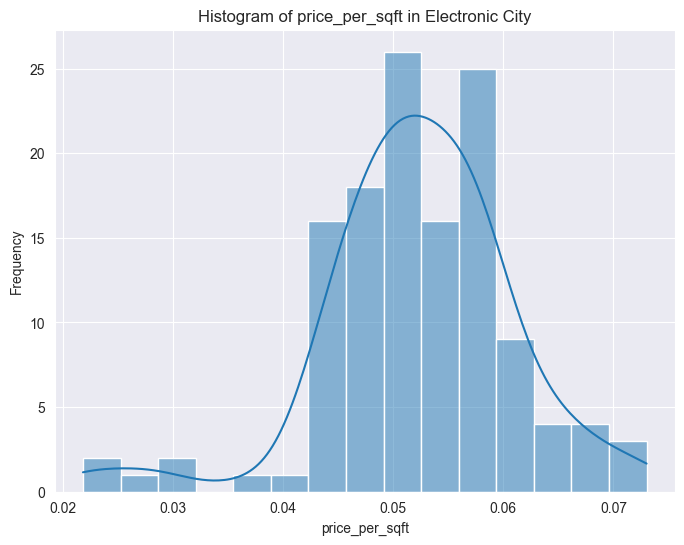

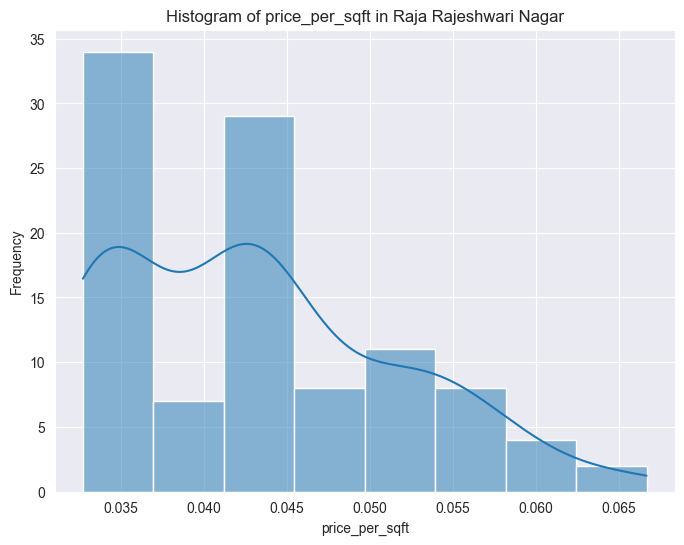

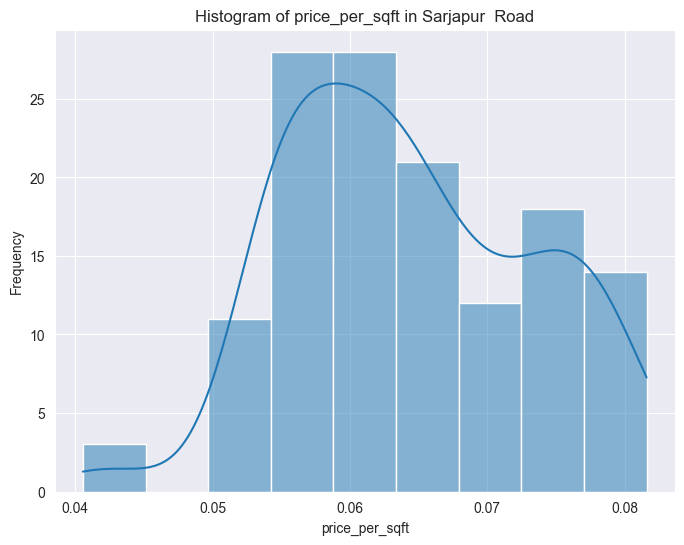

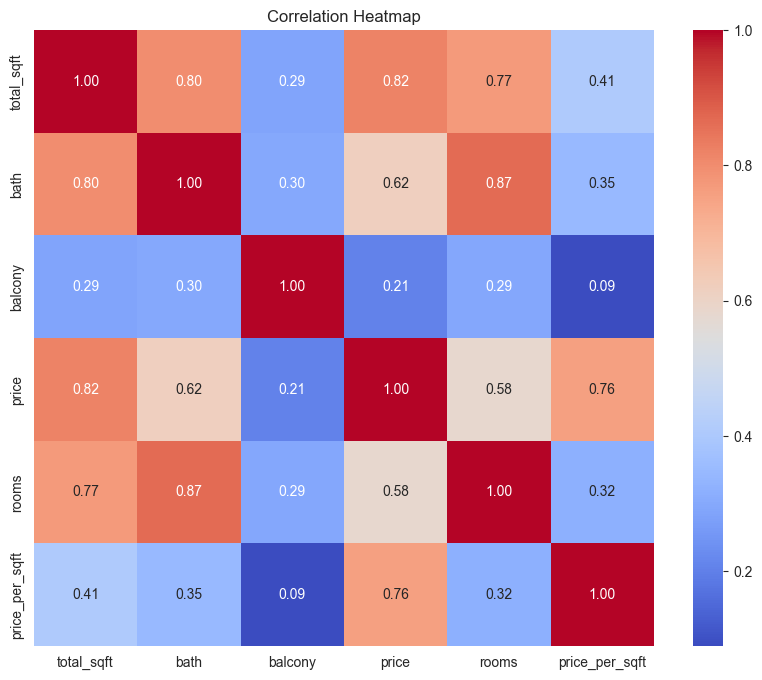

In [97]:
# See the scatter plots after the second removal
vd.plot_scatter_chart(remove_bedroom.data_train, "Electronic City")
vd.plot_scatter_chart(remove_bedroom.data_train, "Raja Rajeshwari Nagar")
vd.plot_scatter_chart(remove_bedroom.data_train, "Sarjapur  Road")

# Show data after the second removal in box plots
vd.plot_boxplot(remove_bedroom.data_train, "Electronic City")
vd.plot_boxplot(remove_bedroom.data_train, "Raja Rajeshwari Nagar")
vd.plot_boxplot(remove_bedroom.data_train, "Sarjapur  Road")

# Show data after the second removal in violins plot
vd.plot_violinplot(remove_bedroom.data_train, "Electronic City")
vd.plot_violinplot(remove_bedroom.data_train, "Raja Rajeshwari Nagar")
vd.plot_violinplot(remove_bedroom.data_train, "Sarjapur  Road")

# Show data after the second removal in histograms
vd.plot_histogram(remove_bedroom.data_train, "price_per_sqft", "Electronic City")
vd.plot_histogram(remove_bedroom.data_train, "price_per_sqft", "Raja Rajeshwari Nagar")
vd.plot_histogram(remove_bedroom.data_train, "price_per_sqft", "Sarjapur  Road")

# Show heatmap with correlations
vd.plot_heatmap(remove_bedroom.data_train)

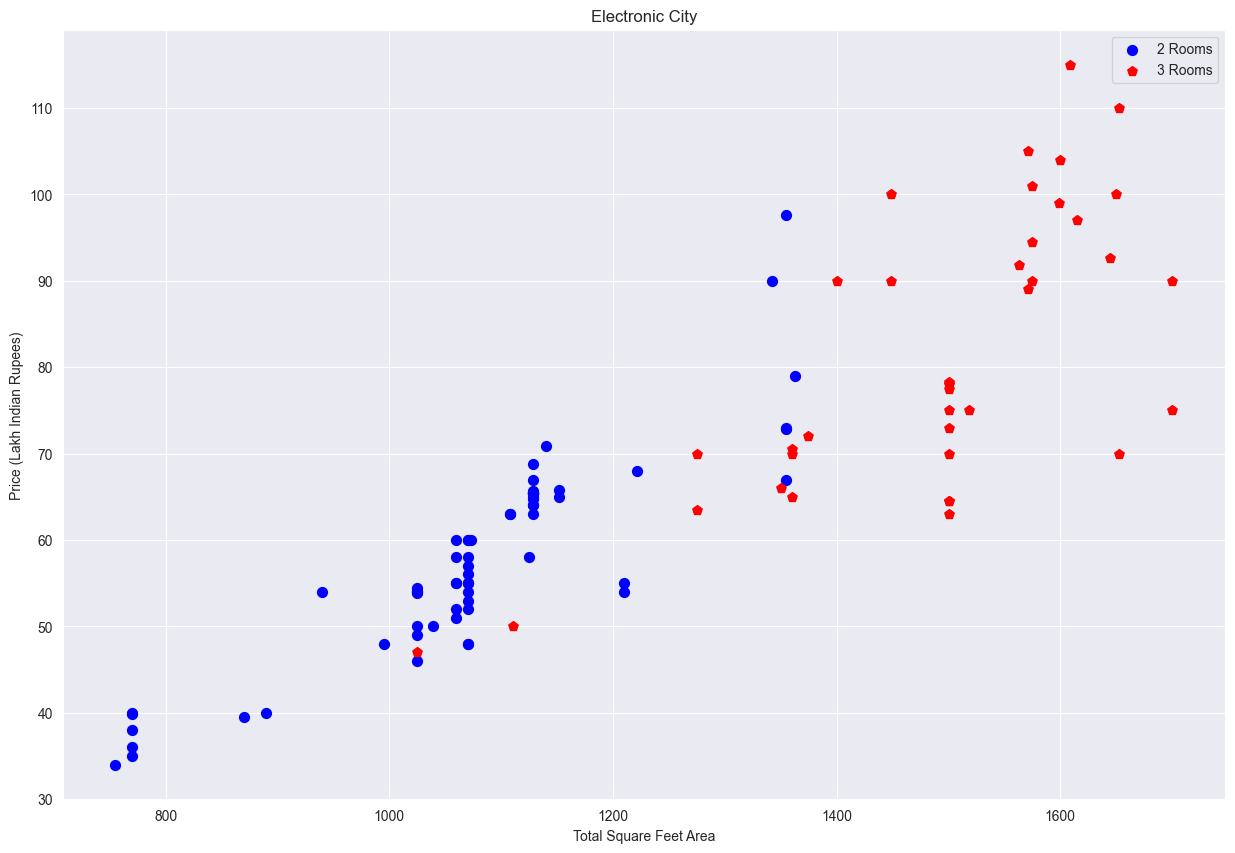

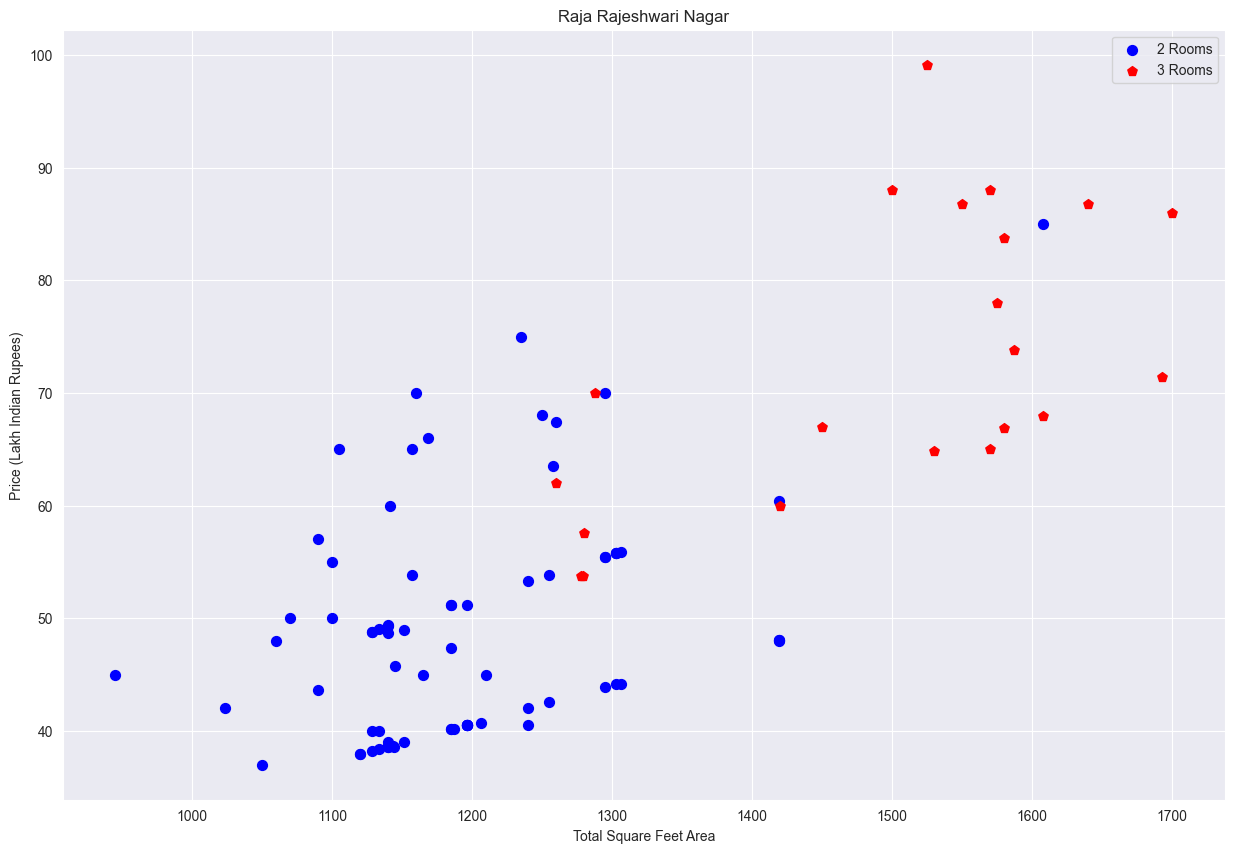

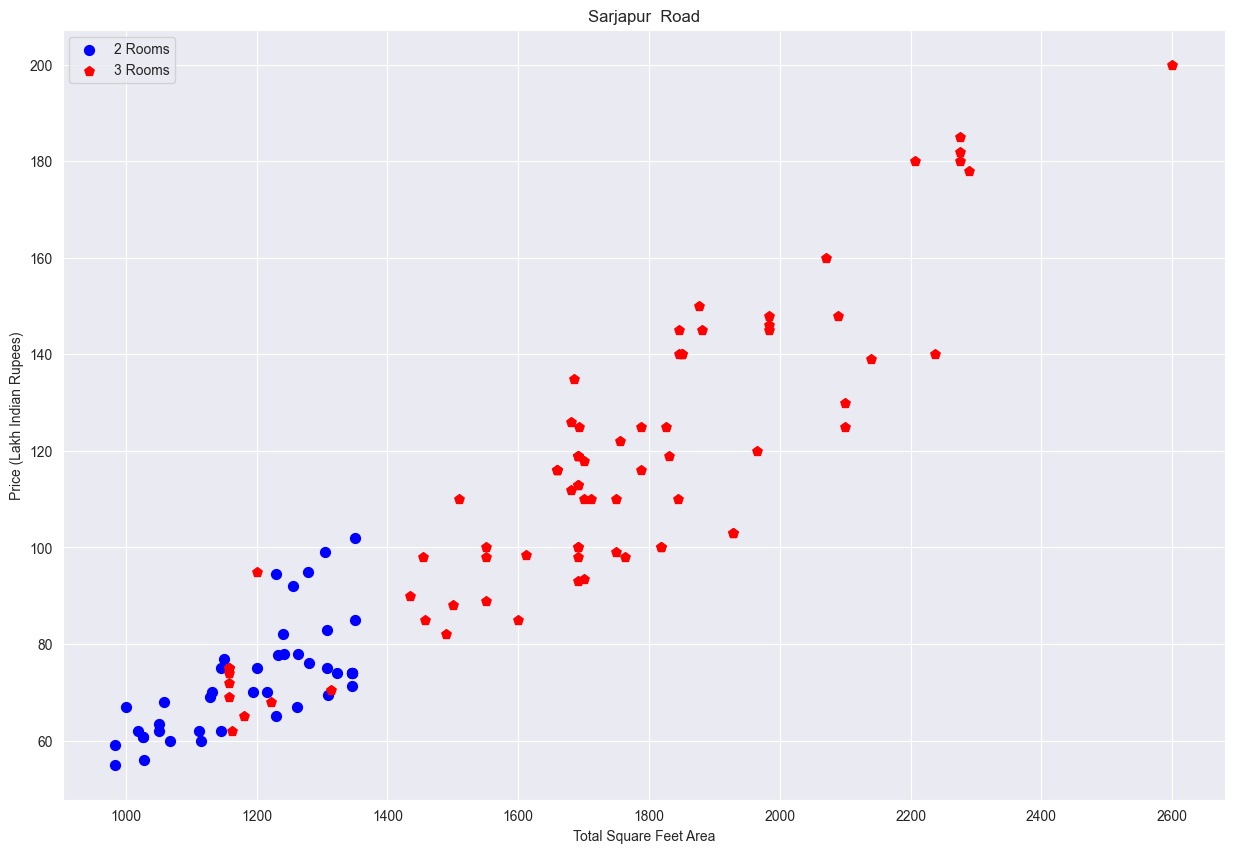

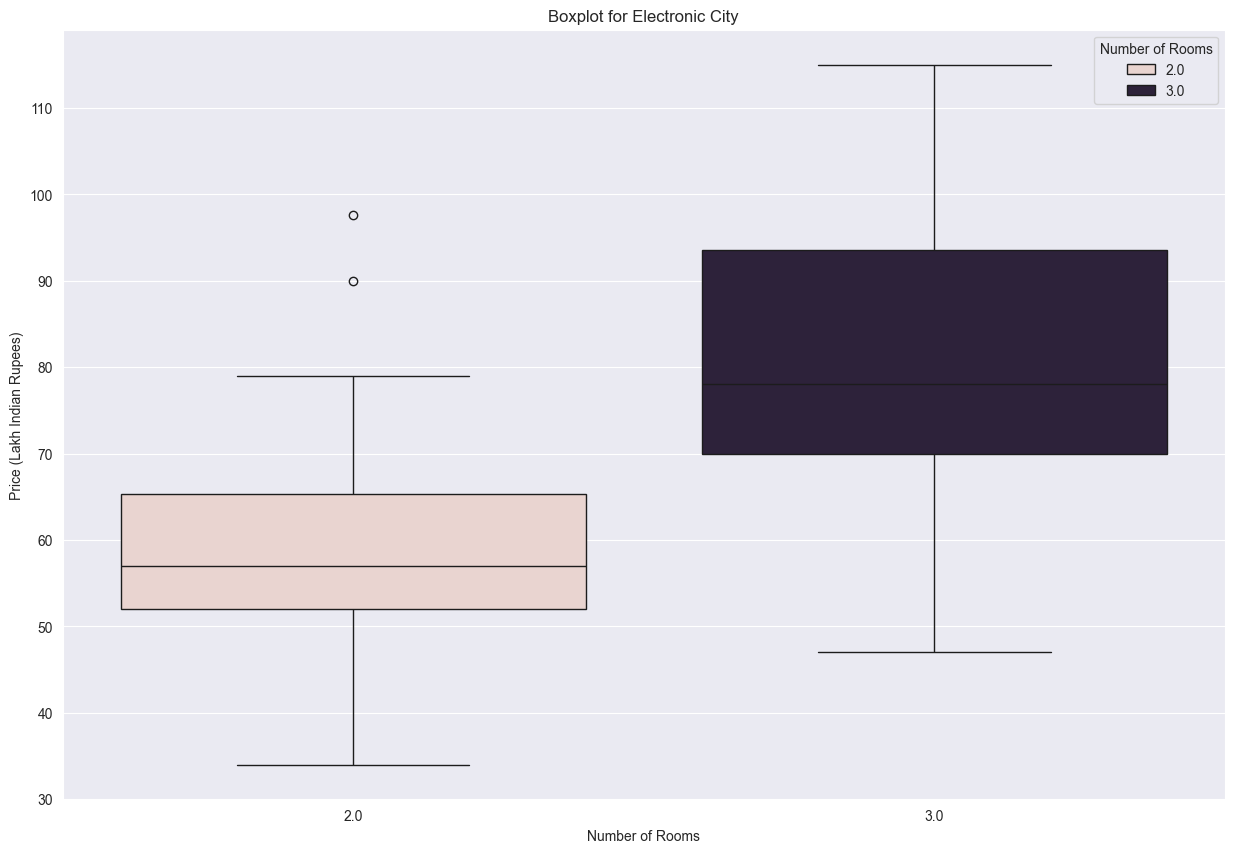

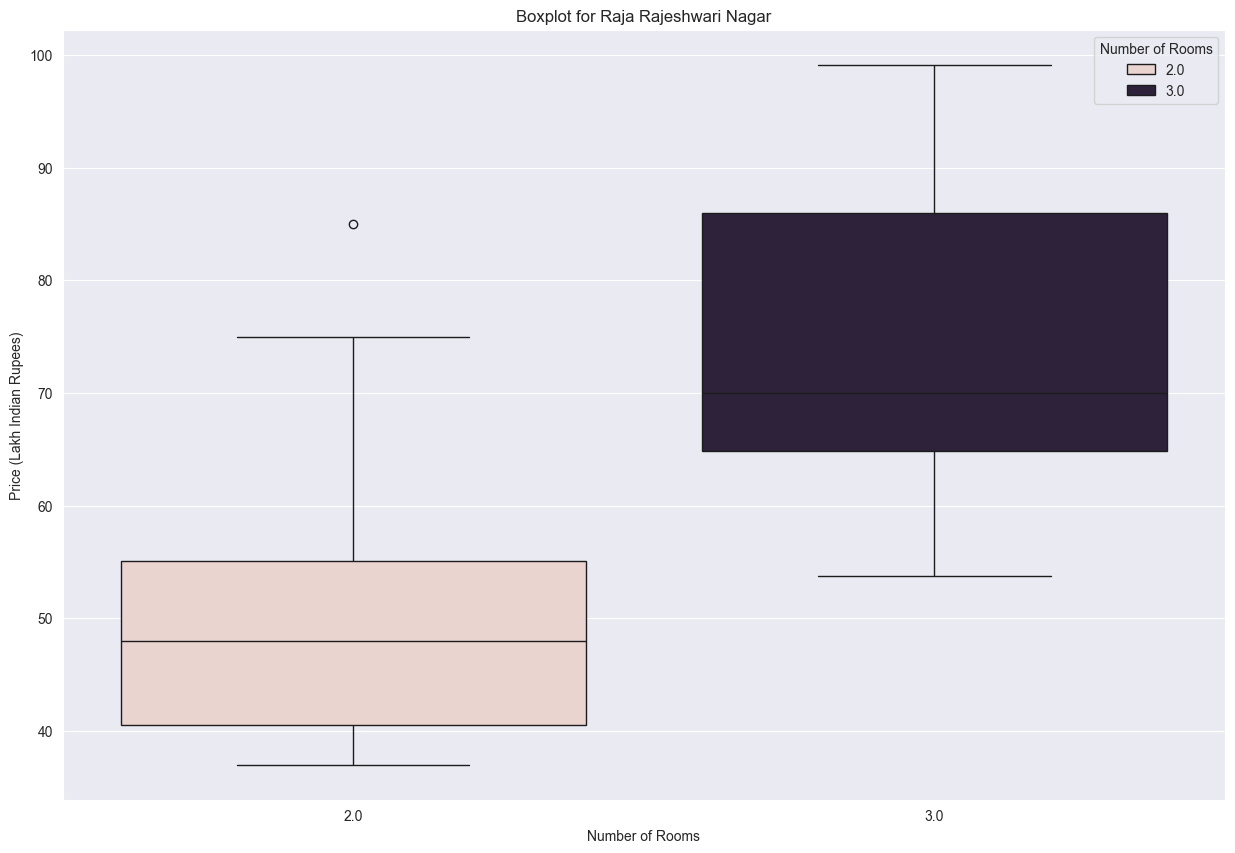

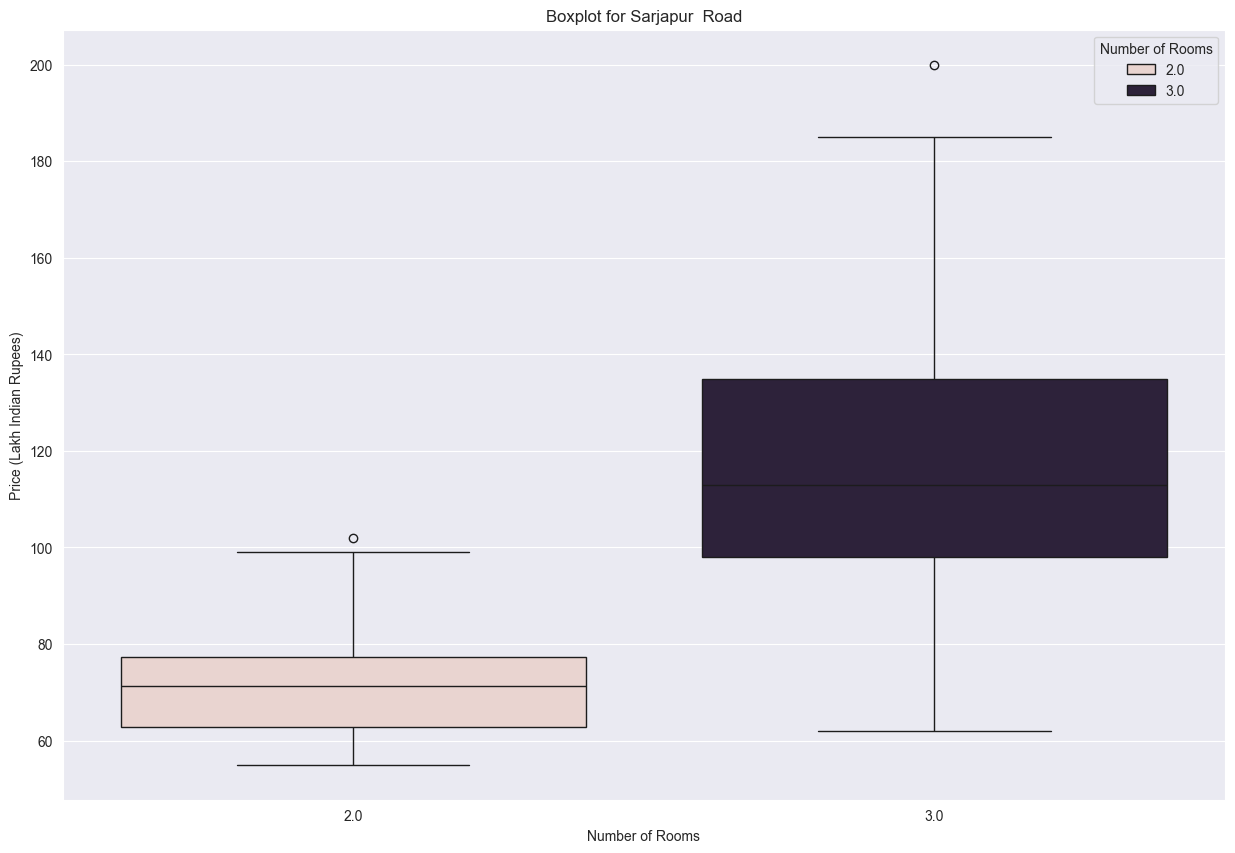

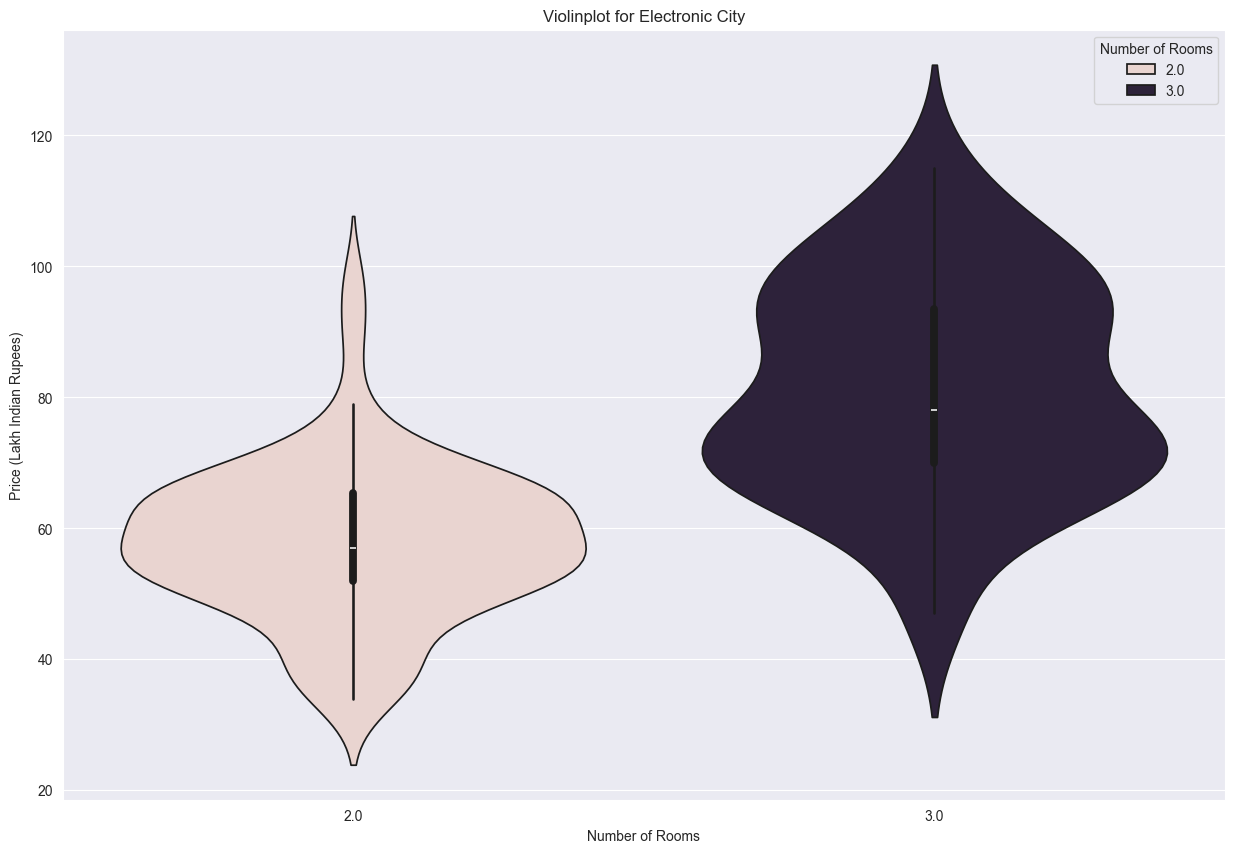

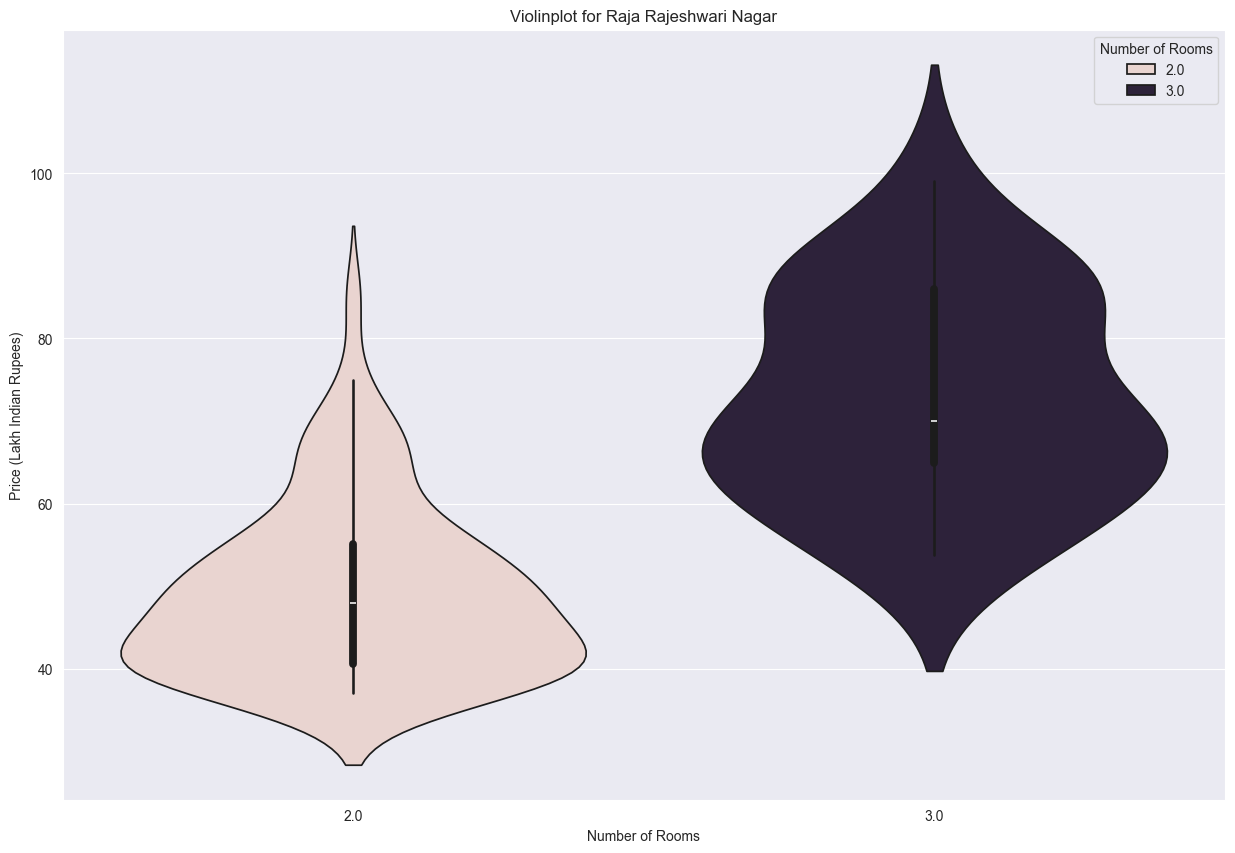

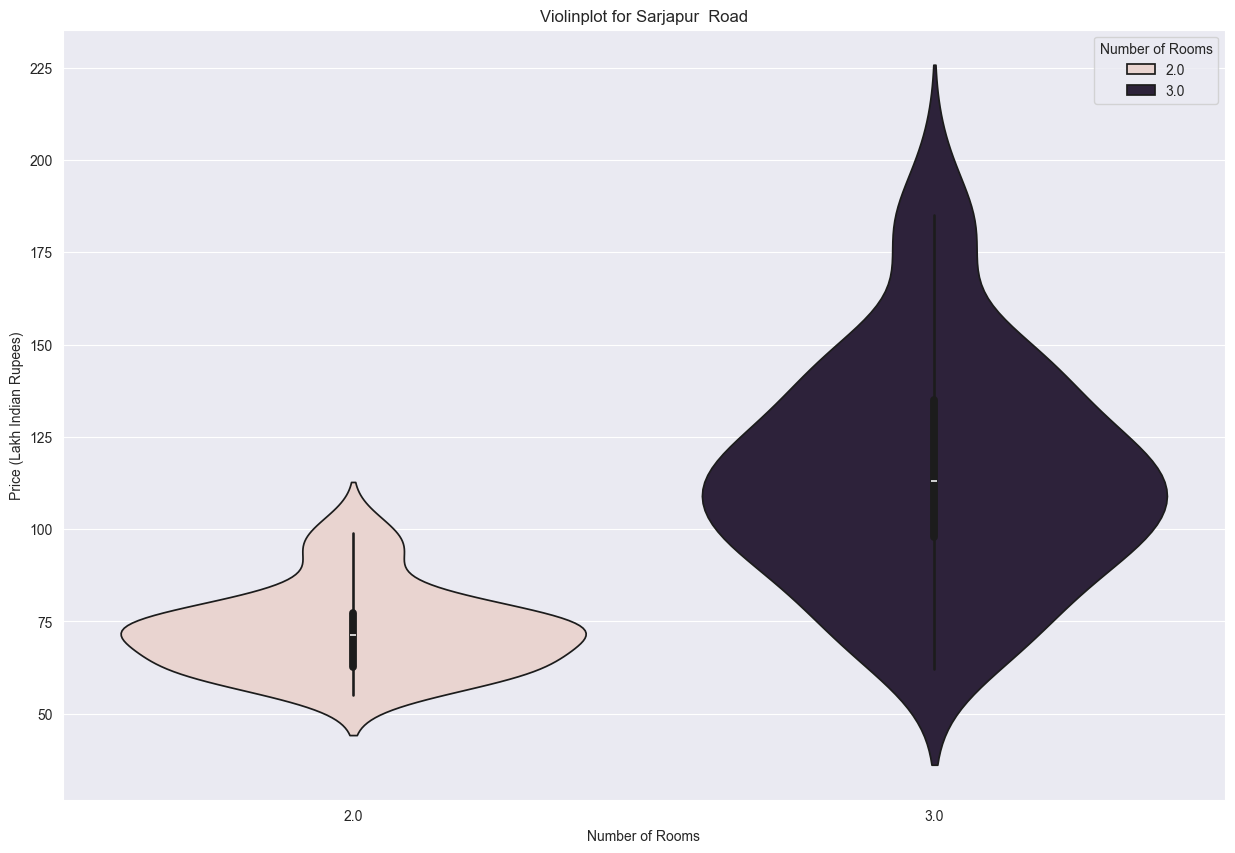

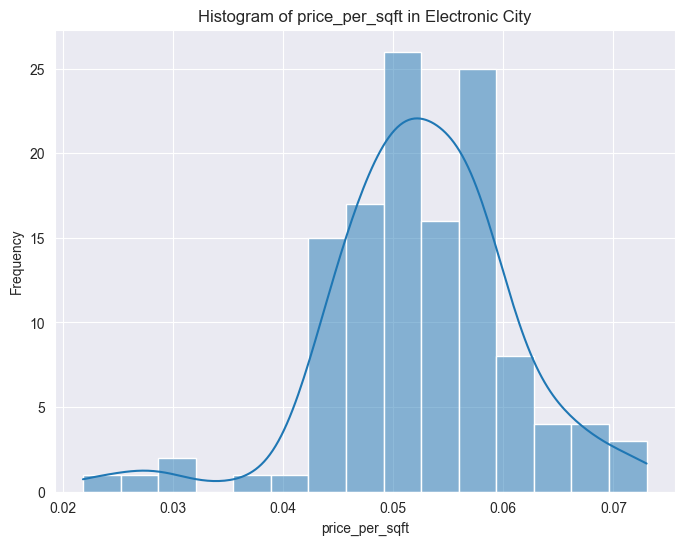

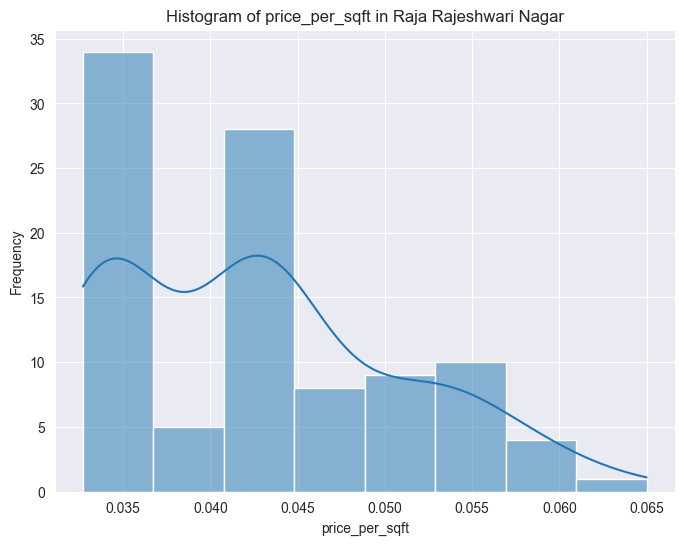

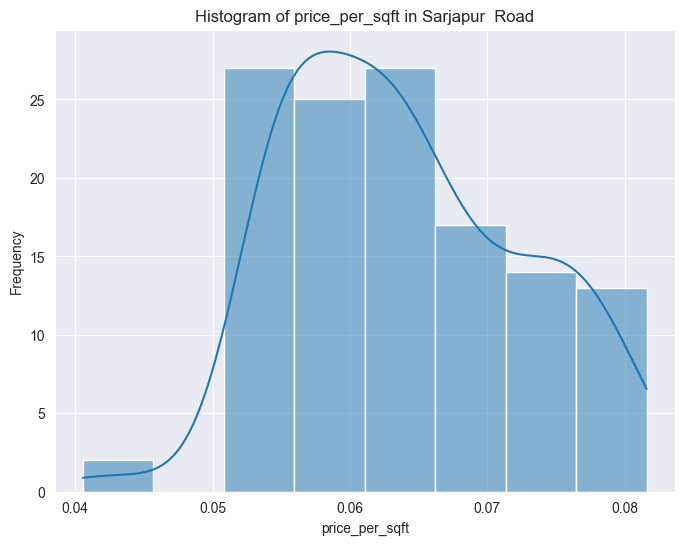

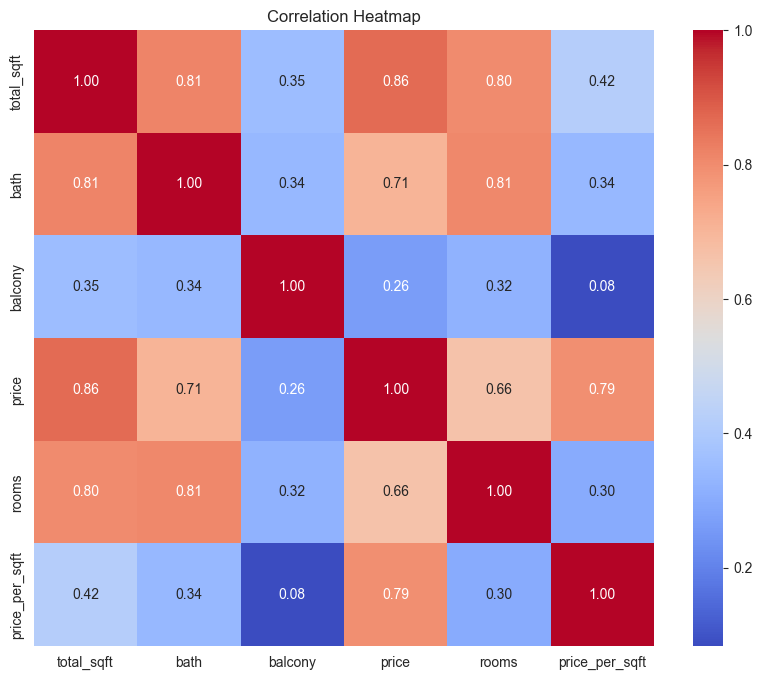

In [98]:
# See the scatter plots after the last removal
vd.plot_scatter_chart(remove_outliers.data_train, "Electronic City")
vd.plot_scatter_chart(remove_outliers.data_train, "Raja Rajeshwari Nagar")
vd.plot_scatter_chart(remove_outliers.data_train, "Sarjapur  Road")

# Show data after the last removal in box plots
vd.plot_boxplot(remove_outliers.data_train, "Electronic City")
vd.plot_boxplot(remove_outliers.data_train, "Raja Rajeshwari Nagar")
vd.plot_boxplot(remove_outliers.data_train, "Sarjapur  Road")

# Show data after the last removal in violins plot
vd.plot_violinplot(remove_outliers.data_train, "Electronic City")
vd.plot_violinplot(remove_outliers.data_train, "Raja Rajeshwari Nagar")
vd.plot_violinplot(remove_outliers.data_train, "Sarjapur  Road")

# Show data after the last removal in histograms
vd.plot_histogram(remove_outliers.data_train, "price_per_sqft", "Electronic City")
vd.plot_histogram(remove_outliers.data_train, "price_per_sqft", "Raja Rajeshwari Nagar")
vd.plot_histogram(remove_outliers.data_train, "price_per_sqft", "Sarjapur  Road")

# Show heatmap with correlations
vd.plot_heatmap(remove_outliers.data_train)

### Class to do PCA and UMAP

In [99]:
class DimensionalityReduction:
    def __init__(self, data, targets):
        """
        Initialize the DimensionalityReduction object with the dataset.

        Parameters:
        - data: The dataset to perform dimensionality reduction on.
        - targets: The targets of the samples.
        """
        self.data = StandardScaler().fit_transform(data)
        self.targets = targets

    def compute_pca(self, n_components=3):
        """
        Compute Principal Component Analysis (PCA) on the dataset.

        Parameters:
        - n_components: The number of components to keep.

        Returns:
        - pca_projection: The projected data using PCA.
        """
        return PCA(n_components=n_components).fit_transform(self.data)

    def compute_umap(self, n_components=2, n_neighbors=8, min_dist=0.5, metric='euclidean'):
        """
        Compute Uniform Manifold Approximation and Projection (UMAP) on the dataset.

        Parameters:
        - n_components: The number of components to embed the data into.
        - n_neighbors: The number of neighbors to consider for each point.
        - min_dist: The minimum distance between embedded points.
        - metric: The distance metric to use.

        Returns:
        - umap_projection: The projected data using UMAP.
        """
        return umap.UMAP(n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist,
                         metric=metric).fit_transform(self.data)

    def plot_projection(self, projection, title):
        """
        Plot the 2D projection of the dataset.

        Parameters:
        - projection: The projected data.
        - title: The title of the plot.
        """
        plt.figure(figsize=(8, 6))
        plt.scatter(projection[:, 0], projection[:, 1], c=self.targets, alpha=0.5)
        plt.title(title)
        plt.xlabel('Component 1')
        plt.ylabel('Component 2')
        plt.grid(True)
        plt.show()

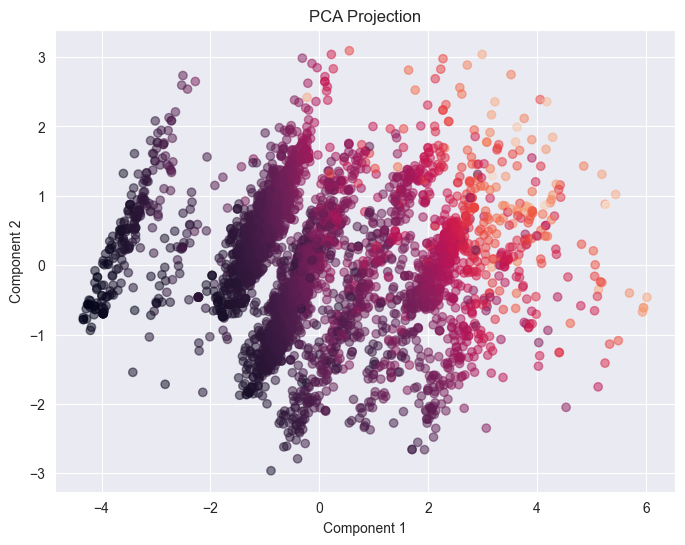

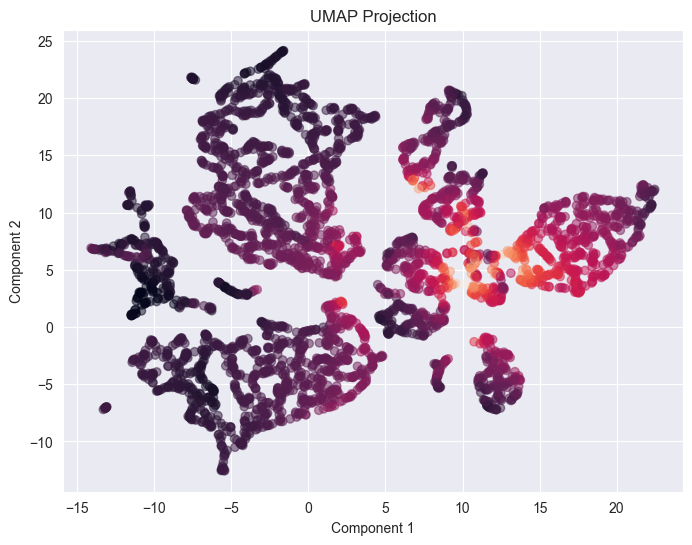

In [100]:
# Our data
data = remove_outliers.data_train[['total_sqft', 'bath', 'balcony', 'rooms', 'price_per_sqft']]

# Our target
targets = remove_outliers.labels_train

# Initialize DimensionalityReduction object
dr = DimensionalityReduction(data, targets)

# Show PCA Projection
dr.plot_projection(dr.compute_pca(), 'PCA Projection')

# Show UMAP Projection
dr.plot_projection(dr.compute_umap(), 'UMAP Projection')

### Class to do Hypothesis Test

In [101]:
class HypothesisTester:
    """
    The t-test assumes that the data is normally distributed and that the variances are equal between groups (for
    unpaired t-test) or within groups (for paired t-test).
    The ANOVA test assumes that the data is normally distributed and that the variances are equal between groups.
    """
    def unpaired_t_test(self, group1, group2):
        """
        Perform unpaired t-test for two groups.

        Parameters:
        - group1: List or array-like object containing data for group 1.
        - group2: List or array-like object containing data for group 2.

        Returns:
        - t_statistic: The calculated t-statistic.
        - p_value: The p-value associated with the t-statistic.
        """
        t_statistic, p_value = ttest_ind(group1, group2)
        return t_statistic, p_value

    def unpaired_anova(self, *groups):
        """
        Perform unpaired ANOVA for more than two groups.

        Parameters:
        - *groups: Variable length argument containing data for each group. Each argument should be a list or array-like
        object.

        Returns:
        - f_statistic: The calculated F-statistic.
        - p_value: The p-value associated with the F-statistic.
        """
        f_statistic, p_value = f_oneway(*groups)
        return f_statistic, p_value

    def paired_t_test(self, group1, group2):
        """
        Perform paired t-test for two groups.

        Parameters:
        - group1: List or array-like object containing data for group 1.
        - group2: List or array-like object containing data for group 2.
                  Should have the same length as group1.

        Returns:
        - t_statistic: The calculated t-statistic.
        - p_value: The p-value associated with the t-statistic.
        """
        t_statistic, p_value = ttest_rel(group1, group2)
        return t_statistic, p_value

In [102]:
# Prices per SQq. feet for three locations
data = remove_outliers.data_train

price_sqft_Electronic_City = data[data['location'] == 'Electronic City']['price_per_sqft']
price_sqft_Raja_Nagar = data[data['location'] == 'Raja Rajeshwari Nagar']['price_per_sqft']
price_sqft_Sarjapur_Road = data[data['location'] == 'Sarjapur  Road']['price_per_sqft']

# Prices for Electronic City location
price_Electronic_City = data[data['location'] == 'Electronic City']['price']

# Total Sq. Feet for Raja Rajeshwari Nagar location
total_sqft_Raja_Nagar = data[data['location'] == 'Raja Rajeshwari Nagar']['total_sqft']

In [103]:
# Initialize the HypothesisTester class with the data
tester = HypothesisTester()

In [104]:
# Perform unpaired t-test between Electronic City and Raja Rajeshwari Nagar locations
t_stat, p_val = tester.unpaired_t_test(price_Electronic_City, price_sqft_Raja_Nagar)

print("\nUnpaired t-test between Electronic City and Raja Rajeshwari Nagar locations:")
print("t-statistic:", t_stat)
print("p-value:", p_val)


Unpaired t-test between Electronic City and Raja Rajeshwari Nagar locations:
t-statistic: 28.2083327583738
p-value: 3.4833732997507473e-75


**Unpaired t-test between Electronic City and Raja Rajeshwari Nagar locations:**
- t-statistic: The calculated t-statistic is approximately 36.06 (indicates that, on average, the price per Sq. Feet of Electronic City locations are lower than those of the Raja Rajeshwari Nagar locations). This value represents the difference in means between the price per Sq. Feet of Electronic City and Raja Rajeshwari Nagar locations.
* p-value: The p-value associated with the t-statistic is approximately 8.00e-85. This p-value is very small, indicating strong evidence against the null hypothesis.
+ In this case, it suggests that the difference in price per Sq. Feet between Electronic City and Raja Rajeshwari Nagar locations is statistically significant.

In [105]:
# Perform unpaired ANOVA among the three locations
f_stat, p_val_anova = tester.unpaired_anova(price_sqft_Raja_Nagar, price_sqft_Electronic_City, price_sqft_Sarjapur_Road)

print("\nUnpaired ANOVA among three locations:")
print("F-statistic:", f_stat)
print("p-value:", p_val_anova)


Unpaired ANOVA among three locations:
F-statistic: 180.46342764046742
p-value: 2.3053930440982387e-54


**Unpaired ANOVA among all three locations:**
- F-statistic: The calculated F-statistic is approximately 221.82 This value represents the ratio of variability between groups to variability within groups in price per Sq. Feet among three locations.
* p-value: The p-value associated with the F-statistic is approximately 7.29e-60. The t-test, this p-value is tiny, indicating strong evidence against the null hypothesis.
+ It suggests that there is a statistically significant difference in price per Sq. Feet among at least one pair of locations.

In [106]:
# Perform paired t-test for total_sqft and price within Raja Rajeshwari Nagar location
t_stat, p_val = tester.paired_t_test(total_sqft_Raja_Nagar, price_sqft_Raja_Nagar)

print("\nPaired t-test for total_sqft and price within Raja Rajeshwari Nagar location:")
print("t-statistic:", t_stat)
print("p-value:", p_val)


Paired t-test for total_sqft and price within Raja Rajeshwari Nagar location:
t-statistic: 63.77164593117391
p-value: 1.3186601810016923e-81


**Paired t-test for total_sqft and price within Raja Rajeshwari Nagar location:**
- t-statistic: The calculated t-statistic is approximately 58.60. This value represents the difference in means between total_sqft and price within the Raja Rajeshwari Nagar location relative to the variability in the data.
* p-value: The p-value associated with the t-statistic is approximately 2.32e-80. This p-value is tiny, indicating strong evidence against the null hypothesis.
+ It suggests that the difference between total_sqft and price within the Raja Rajeshwari Nagar location is statistically significant.

### New Features

In [107]:
class FeatureEngineering:
    """
    A class for feature engineering on the dataset
    """
    def __init__(self, data_loader):
        """
        Initializes the FeatureEngineering object

        :param data_loader: The input dataset
        """
        self.data_loader = data_loader
        self.data_train = None
        self.labels_train = None
        self.data_test = None
        self.labels_test = None
        
    def create_features(self):
        """
        Creates new features based on the existing data
        """
        self.data_train = self.data_loader.data_train
        self.labels_train = self.data_loader.labels_train
        self.data_test = self.data_loader.data_test
        self.labels_test = self.data_loader.labels_test
        
        # Price distribution per bedroom.
        self.data_train['price_per_bedroom'] = self.data_train['price'] / self.data_train['rooms']
        self.data_test['price_per_bedroom'] = self.data_test['price'] / self.data_test['rooms']
        
        # Bathroom to bedroom ratio.
        self.data_train['bath_per_bedroom'] = self.data_train['bath'] / self.data_train['rooms']
        self.data_test['bath_per_bedroom'] = self.data_test['bath'] / self.data_test['rooms']
        
        # Space distribution per bedroom.
        self.data_train['total_sqft_per_room'] = self.data_train['total_sqft'] / self.data_train['rooms']
        self.data_test['total_sqft_per_room'] = self.data_test['total_sqft'] / self.data_test['rooms']
        
        # Balcony to bedroom ratio
        self.data_train['balcony_per_room'] = self.data_train['balcony'] / self.data_train['rooms']
        self.data_test['balcony_per_room'] = self.data_test['balcony'] / self.data_test['rooms']
        
        # Price distribution per bathroom
        self.data_train['price_per_bath'] = self.data_train['price'] / self.data_train['bath']
        self.data_test['price_per_bath'] = self.data_test['price'] / self.data_test['bath']
        
        # Space distribution per bathroom
        self.data_train['total_sqft_per_bath'] = self.data_train['total_sqft'] / self.data_train['bath']
        self.data_test['total_sqft_per_bath'] = self.data_test['total_sqft'] / self.data_test['bath']
        
        # Balcony to bathroom ratio
        self.data_train['balcony_per_bath'] = self.data_train['balcony'] / self.data_train['bath']
        self.data_test['balcony_per_bath'] = self.data_test['balcony'] / self.data_test['bath']
        
        # Price distribution per balcony
        self.data_train['price_per_balcony'] = self.data_train['price'] / self.data_train['balcony']
        self.data_test['price_per_balcony'] = self.data_test['price'] / self.data_test['balcony']
        
        # Space distribution per balcony
        self.data_train['total_sqft_per_balcony'] = self.data_train['total_sqft'] / self.data_train['balcony']
        self.data_test['total_sqft_per_balcony'] = self.data_test['total_sqft'] / self.data_test['balcony']
        
        # Bedroom to bathroom ratio
        self.data_train['room_per_bath'] = self.data_train['rooms'] / self.data_train['bath']
        self.data_test['room_per_bath'] = self.data_test['rooms'] / self.data_test['bath']
        
        # Calculate the average price
        average_price_train = self.data_train['price'].mean()
        average_price_test = self.data_test['price'].mean()
        
        # Prices above average
        self.data_train['price_above_average'] = self.data_train['price'] > average_price_train
        self.data_test['price_above_average'] = self.data_test['price'] > average_price_test

In [108]:
new_features = FeatureEngineering(remove_outliers)
new_features.create_features()

# Access the data and labels attributes
print("Training data shape:", new_features.data_train.shape)
print("Training labels shape:", new_features.labels_train.shape)
print("Testing data shape:", new_features.data_test.shape)
print("Testing labels shape:", new_features.labels_test.shape)

Training data shape: (4052, 18)
Training labels shape: (4052,)
Testing data shape: (1300, 18)
Testing labels shape: (1300,)


C:\Users\vitor_pl48eof\AppData\Local\Temp\ipykernel_22836\917924149.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data_test['price_per_bedroom'] = self.data_test['price'] / self.data_test['rooms']
C:\Users\vitor_pl48eof\AppData\Local\Temp\ipykernel_22836\917924149.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data_test['bath_per_bedroom'] = self.data_test['bath'] / self.data_test['rooms']
C:\Users\vitor_pl48eof\AppData\Local\Temp\ipykernel_22836\917924149.py:36: SettingWithCopyWarnin

### Model Selection Class

In [109]:
class ModelSelection:
    """
    A class to perform model selection for regression problems.
    """
    def __init__(self, X, y):
        """
        Initializes the ModelSelection object with the features and target variable.

        :param X: The input features.
        :param y: The target variable.
        """
        self.X = X
        self.y = y

    def select_model(self):
        """
        Performs model selection by training various models and evaluating them using Mean Squared Error.
        The models used are: Linear Regression, Decision Tree Regression, Random Forest Regression,
        Gradient Boosting Regression, and Support Vector Regression.
        """
        # Create a list of models to evaluate
        models = [RandomForestRegressor(), GradientBoostingRegressor(), LinearRegression(), DecisionTreeRegressor(), SVR(), Ridge()]

        for model in models:
            # Perform K-Fold Cross Validation
            scores = cross_val_score(model, self.X, self.y, cv=10, scoring='neg_mean_squared_error')

            # Calculate Mean Squared Error
            mse_scores = -scores

            # Print the model name and its Mean Squared Error
            print(f'Model: {model.__class__.__name__}, Mean Squared Error: {mse_scores.mean()}')

            #X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.2, random_state=42)

            # Fit the model to the training data
            model.fit(self.X, self.y)

            # Plot the model's predictions
            self.plot_model_predictions(self.X, self.y, model)

    def plot_model_predictions(self, X_test, y_test, model):
        '''
        Plots the model's predictions against the actual values
        :param X_test: Test data
        :param y_test: Actual values
        :param model: Trained model
        '''

        # Use the model to make predictions on the test data
        predictions = model.predict(X_test)

        # Plot the model's predictions against the actual values
        plt.scatter(y_test, predictions)
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(f'{model.__class__.__name__} Model: Actual vs Predicted Values')

        # Add a line representing perfect prediction
        min_val = min(min(y_test), min(predictions))
        max_vals = max(max(y_test), max(predictions))
        plt.plot([min_val, max_vals], [min_val, max_vals], color='red')

        plt.show()

### Model Selection

Model: RandomForestRegressor, Mean Squared Error: 4.77816339906148


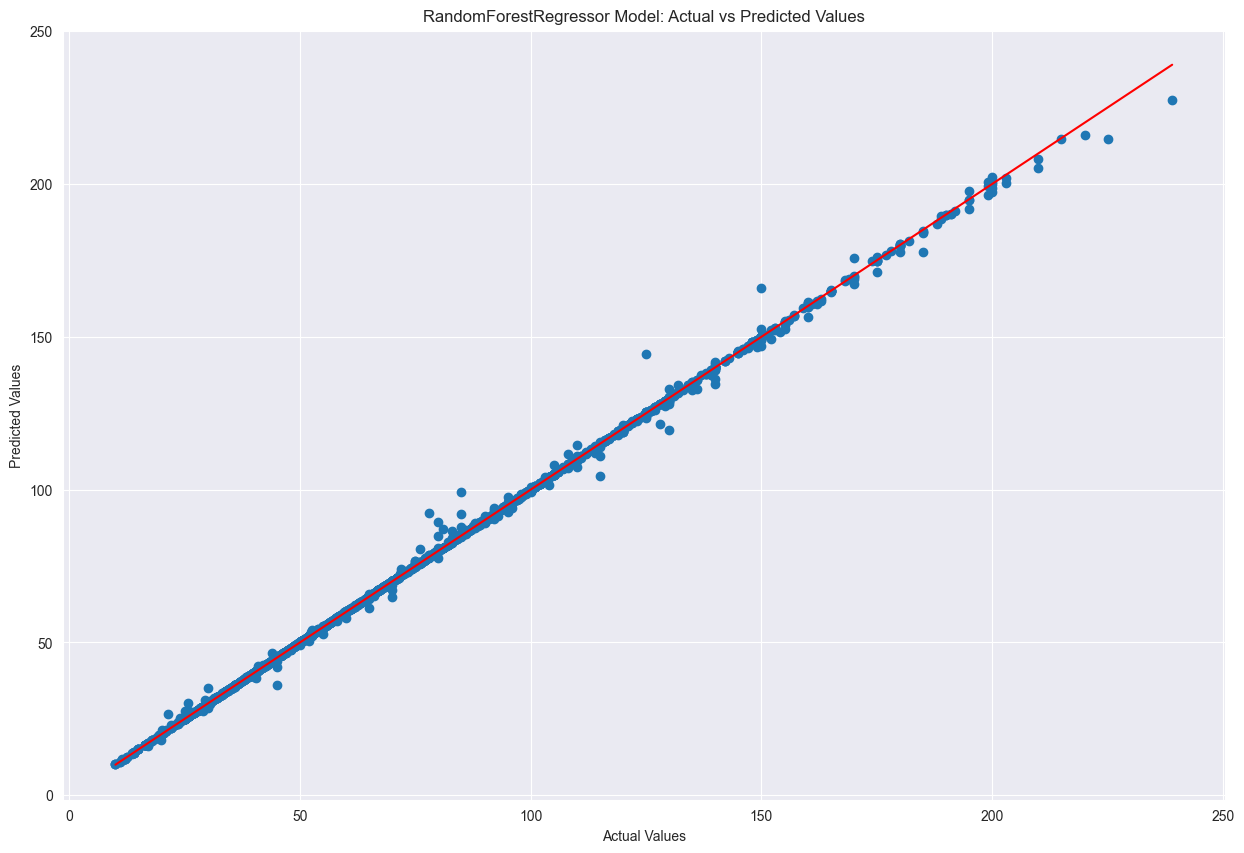

Model: GradientBoostingRegressor, Mean Squared Error: 5.112753319914111


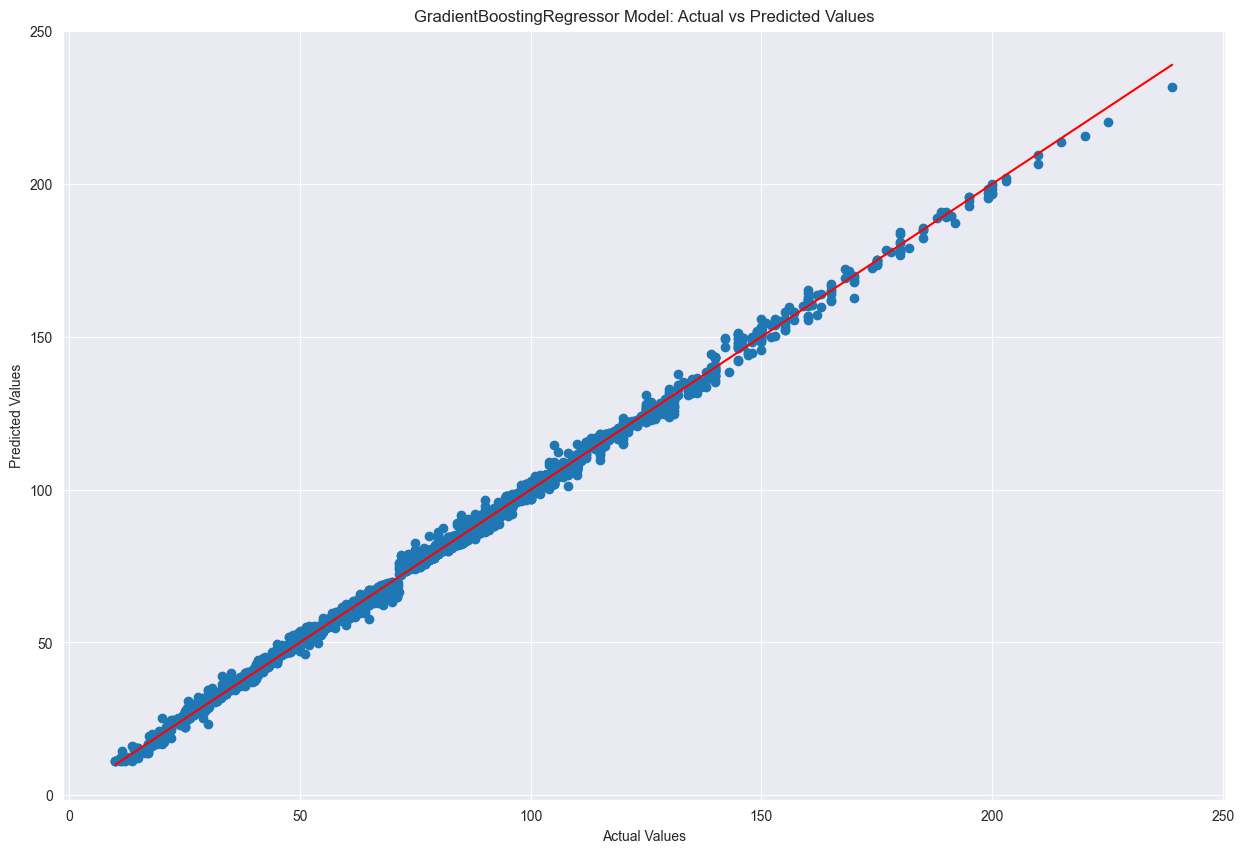

Model: LinearRegression, Mean Squared Error: 16.868965876865506


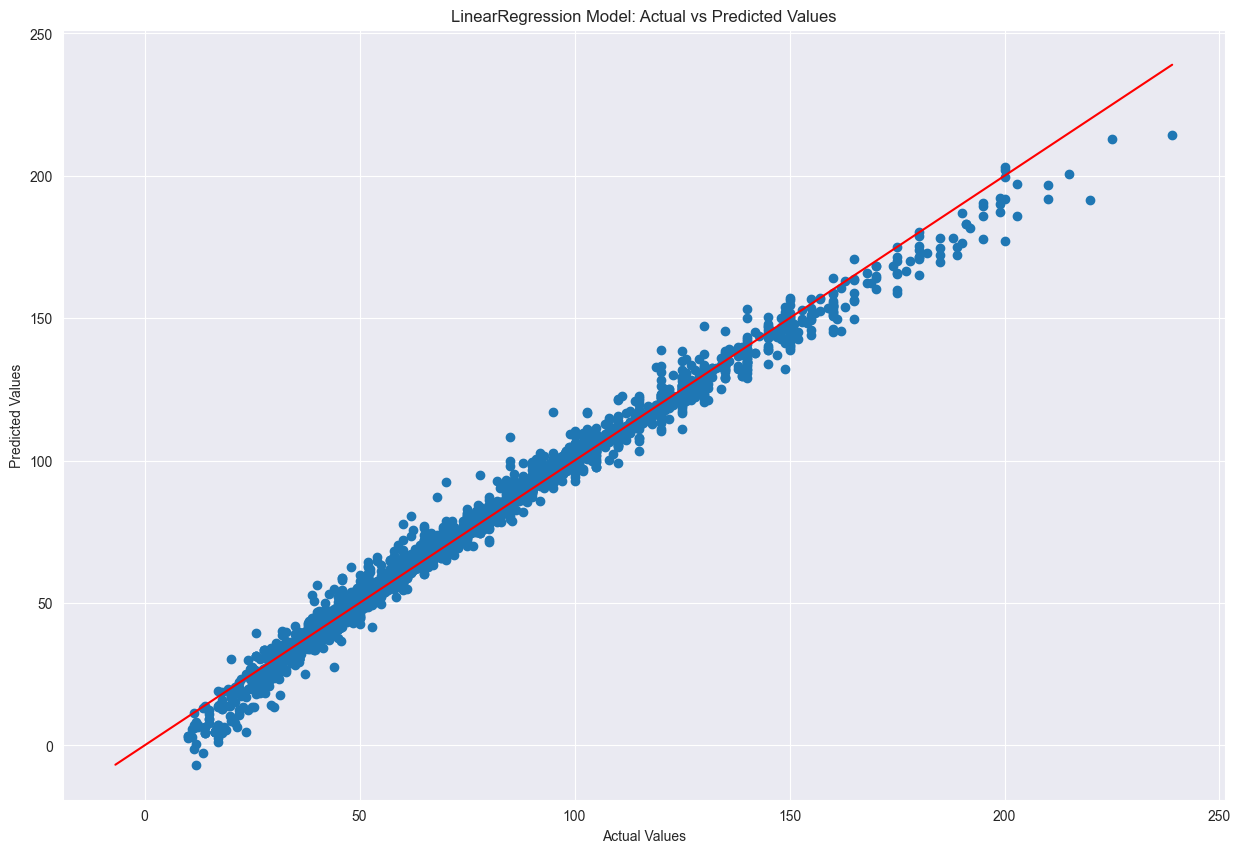

Model: DecisionTreeRegressor, Mean Squared Error: 8.55982882326826


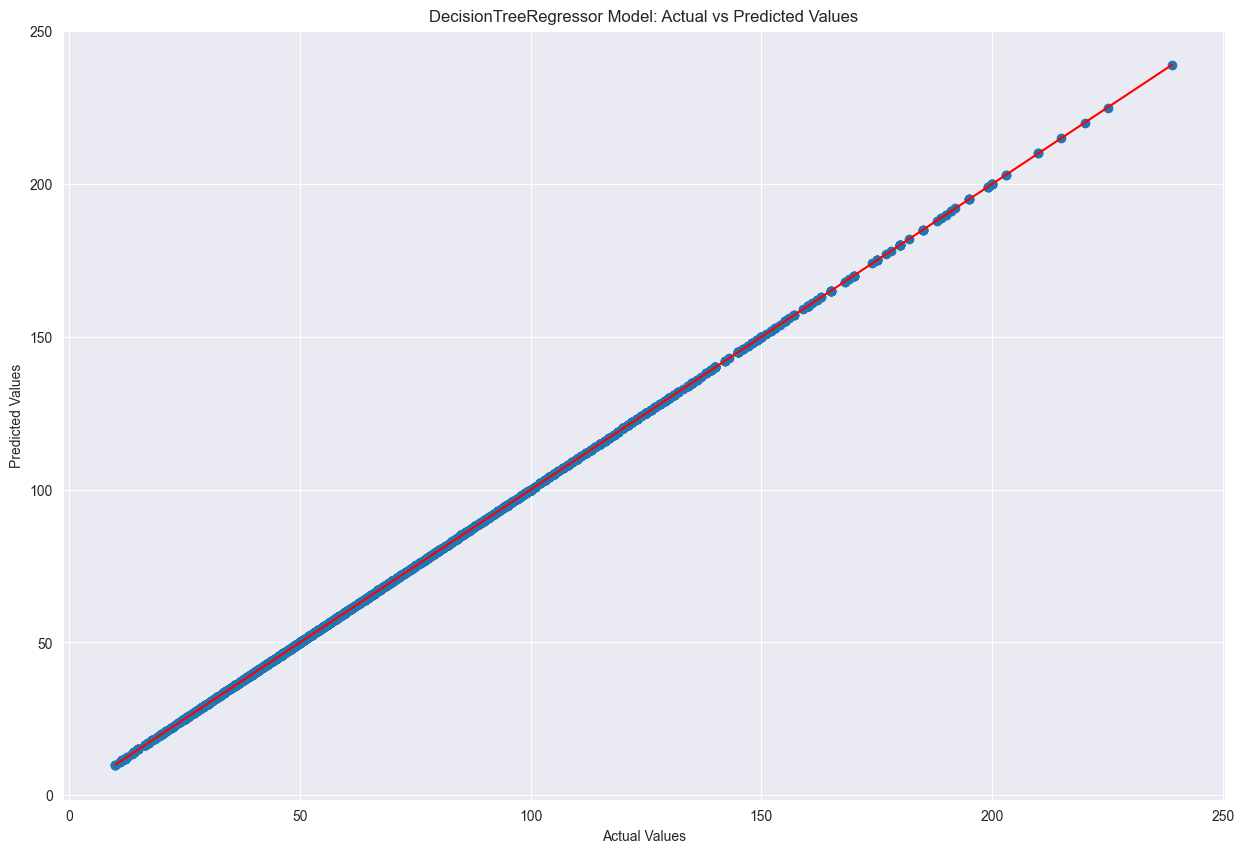

Model: SVR, Mean Squared Error: 278.83703402270044


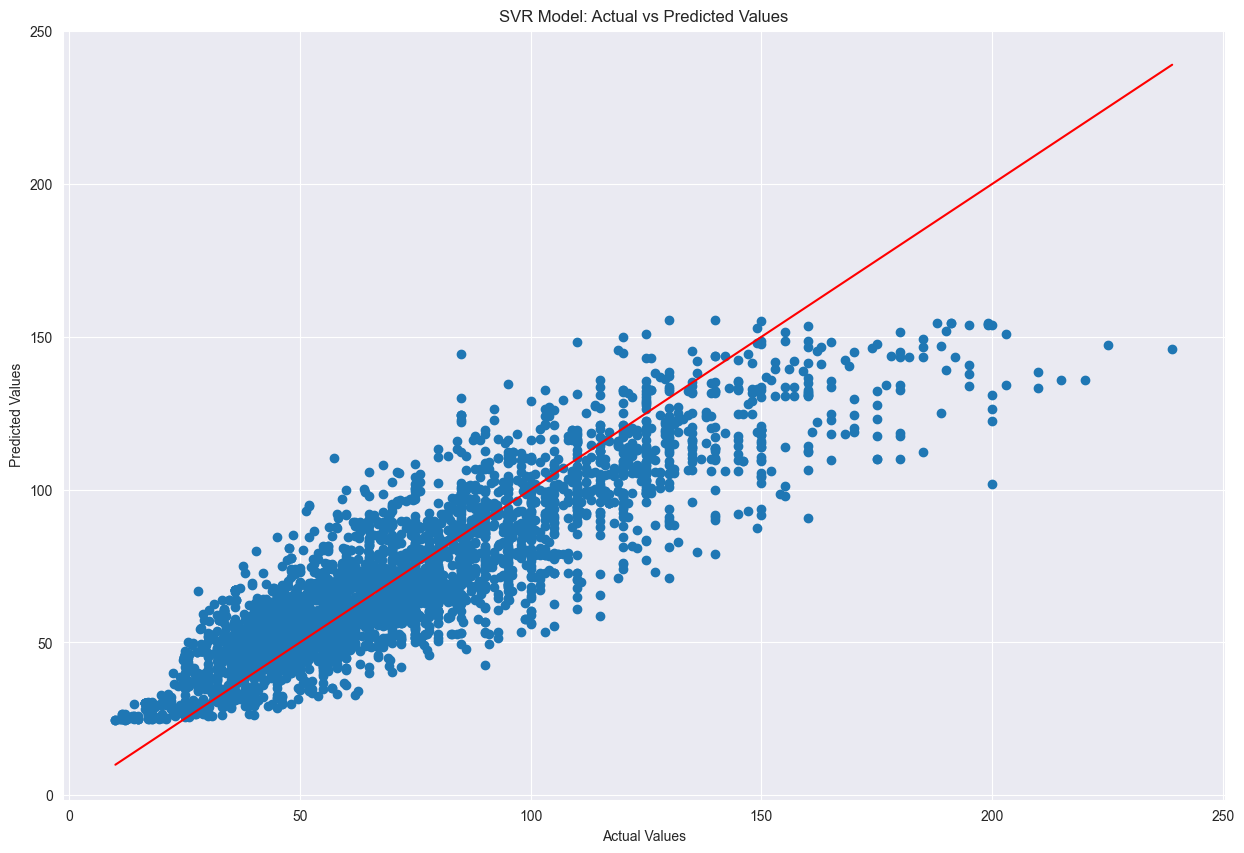

Model: Ridge, Mean Squared Error: 17.77063334366749


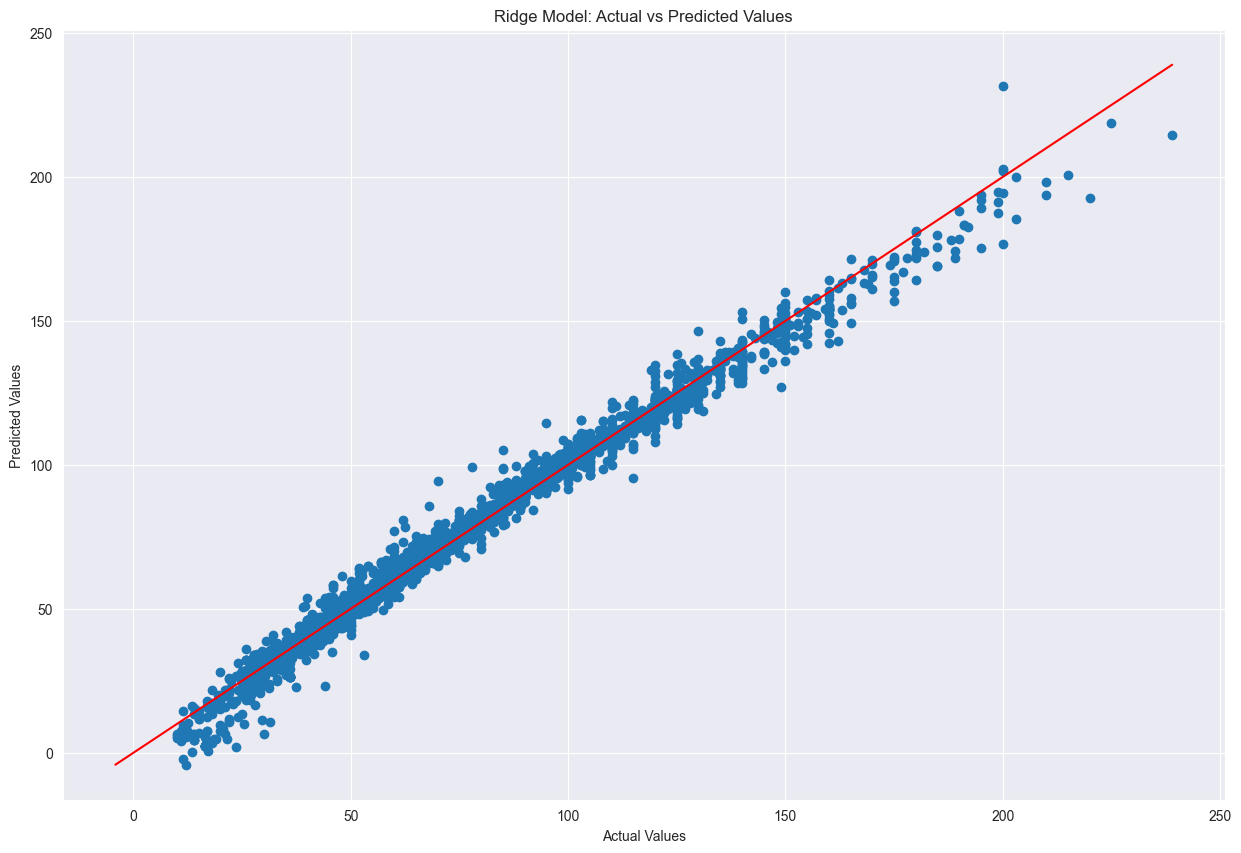

In [110]:
new_features_encoded = pd.get_dummies(new_features.data_train)
new_features_encoded.fillna(new_features_encoded.mean(), inplace=True)

for column in new_features_encoded.columns:
    if np.isinf(new_features_encoded[column]).any():
        max_val = new_features_encoded[~np.isinf(new_features_encoded[column])][column].max()
        new_features_encoded[column] = new_features_encoded[column].replace([np.inf, -np.inf], max_val)

# Now, 'new_features_encoded' is your DataFrame with encoded categorical variables
X = new_features_encoded.drop(['price'], axis=1)
y = new_features.labels_train

# Initialize the ModelSelection class with the data
ms = ModelSelection(X, y)

# Perform model selection
ms.select_model()

- Model: RandomForestRegressor, Mean Squared Error: 3.7430185599578003
- Model: GradientBoostingRegressor, Mean Squared Error: 4.812556328901333
- Model: LinearRegression, Mean Squared Error: 16.81454063908607
- Model: DecisionTreeRegressor, Mean Squared Error: 6.8783212790191826
- Model: SVR, Mean Squared Error: 266.41546914529124
- Model: Ridge, Mean Squared Error: 18.29794128863744

In [111]:
import numpy as np

class KNN:
    """
    Implementation of the K-Nearest Neighbors (KNN) algorithm for classification.

    Attributes:
        k (int): Number of neighbors to consider for classification.

    Methods:
        __init__(self, k=3): Initializes the KNN classifier with the specified value of k.
        fit(self, X, y): Fits the KNN classifier to the training data.
        predict(self, X): Predicts the class labels for the input data.
        _predict(self, x): Predicts the class label for a single data point.
        euclidean_distance(x1, x2): Computes the Euclidean distance between two data points.
    """

    def __init__(self, k=3):
        """
        Initializes the KNN classifier with the specified value of k.

        Args:
            k (int, optional): Number of neighbors to consider for classification. Default is 3.
        """
        self.k = k

    def fit(self, X, y):
        """
        Fits the KNN classifier to the training data.

        Args:
            X (array-like): Training data features.
            y (array-like): Training data labels.
        """
        self.X_train = X
        self.y_train = y

    @staticmethod
    def euclidean_distance(x1, x2):
        """
        Computes the Euclidean distance between two data points.

        Args:
            x1 (array-like): First data point.
            x2 (array-like): Second data point.

        Returns:
            float: Euclidean distance between x1 and x2.
        """
        distance = np.sqrt(np.sum((x1 - x2) ** 2))
        return distance

    def predict(self, X):
        """
        Predicts the class labels for the input data.

        Args:
            X (DataFrame): Input data features.

        Returns:
            list: Predicted class labels.
        """
        predictions = [self._predict(x) for x in X.values]
        return predictions

    def _predict(self, x):
        """
        Predicts the class label for a single data point.

        Args:
            x (array-like): Input data point.

        Returns:
            int: Predicted class label.
        """
        # compute the distance
        distances = [self.euclidean_distance(x, x_train) for x_train in self.X_train.values]

        # get the closest k
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = self.y_train[k_indices]

        # count occurrences of each class label
        unique_labels, counts = np.unique(k_nearest_labels, return_counts=True)

        # find the index of the most frequent class label
        most_common_index = np.argmax(counts)

        # return the most common class label
        return unique_labels[most_common_index]
    
    def evaluate(self, X_test, y_test):
        """
        Calculates and prints the accuracy of the model.

        Args:
            X_test (array-like): Test data features.
            y_test (array-like): Test data labels.
        """
        # Making predictions on test data
        predictions = self.predict(X_test)
        
        # Calculating accuracy
        correct_predictions = np.sum(predictions == y_test)
        total_predictions = len(y_test)
        accuracy = correct_predictions / total_predictions
        
        print("KNN Model Accuracy:", accuracy)

In [112]:
new_features_encoded_train = pd.get_dummies(new_features.data_train['location'], dtype=int)
new_features_encoded_test = pd.get_dummies(new_features.data_test['location'], dtype=int)

new_features_encoded_train.fillna(0, inplace=True)
new_features_encoded_test.fillna(0, inplace=True)

new_features_encoded_test = new_features_encoded_test.reindex(columns=new_features_encoded_train.columns, fill_value=0)

data_train_with_dummies = pd.concat([new_features.data_train.drop('location', axis=1), new_features_encoded_train], axis=1)
data_test_with_dummies = pd.concat([new_features.data_test.drop('location', axis=1), new_features_encoded_test], axis=1)

X_train_KNN = data_train_with_dummies.drop('price', axis=1)
X_test_KNN = data_test_with_dummies.drop('price', axis=1)
y_train_KNN = new_features.labels_train
y_test_KNN = new_features.labels_test

X_train_KNN.reset_index(drop=True, inplace=True)
y_train_KNN.reset_index(drop=True, inplace=True)

In [113]:
print(X_train_KNN.shape)
print(X_test_KNN.shape)

(4052, 232)
(1300, 232)


# kNN Algorithm

In [114]:
knn = KNN(k=1)
knn.fit(X_train_KNN, y_train_KNN)

knn.evaluate(X_test_KNN, y_test_KNN)

KNN Model Accuracy: 0.14615384615384616


## Discussion of KNN Model Performance

The KNN model was trained and evaluated on the dataset, and the resulting accuracy was approximately 0.16. This indicates that the model's performance is quite low, and several factors could be contributing to this result.

1. **Inappropriate Choice of Hyperparameter K**: The selected value for the hyperparameter K may not be optimal for the dataset. A low value of K (such as 1) can lead to overfitting, while a high value of K can result in underfitting. Experimenting with different values of K may help improve performance.

2. **Inadequate Feature Scaling**: KNN is sensitive to the scale of features. If the features have different scales, it can negatively impact the model's performance. Ensuring proper normalization of the data before applying KNN can mitigate this issue.

3. **Curse of Dimensionality**: KNN may not perform well on datasets with a high number of dimensions due to the curse of dimensionality. If the dataset has many features, it can adversely affect KNN's performance. Dimensionality reduction techniques or feature selection may be beneficial.

4. **Presence of Irrelevant or Noisy Features**: Irrelevant or noisy features in the dataset can hinder the KNN model's ability to generalize. Conducting feature analysis and removing or refining features that do not contribute significantly to prediction could improve performance.

5. **Inherent Limitations of KNN**: While KNN is a simple and intuitive algorithm, it may not capture complex relationships in the data as effectively as other more advanced algorithms. Exploring alternative machine learning models that are better suited to the specific problem domain could lead to better results.

In summary, the low performance of the KNN model may be attributed to various factors, including suboptimal choice of hyperparameters, inadequate feature scaling, high dimensionality, presence of irrelevant features, or inherent limitations of the KNN algorithm. Experimenting with different approaches and models is recommended to enhance the machine learning system's performance.


# Supervised Learning

In [115]:
# Process the data to perform other Supervised Learning Models
data_train_Supervised_Learning = X_train_KNN.replace([np.inf, -np.inf], np.nan)
data_train_Supervised_Learning.fillna(data_train_Supervised_Learning.mean(), inplace=True)

labels_train_Supervised_Learning = new_features.labels_train

data_test_Supervised_Learning = X_test_KNN.replace([np.inf, -np.inf], np.nan)
data_test_Supervised_Learning.fillna(data_test_Supervised_Learning.mean(), inplace=True)

labels_test_Supervised_Learning = new_features.labels_test

## Linear Regression

In [116]:
test = data_test_Supervised_Learning.head(5)
print(test)

new_data = data_test_Supervised_Learning.copy()
new_data['rooms'] += 1

test_2 = new_data.head(5)
print(test_2)

data_test_modified = data_test_Supervised_Learning.copy()
data_test_modified['rooms'] += 1
data_test_modified['total_sqft'] += 700

test_3 = data_test_modified.head(5)
print(test_3)


testPrice = labels_test_Supervised_Learning.head(5)
print(testPrice)

       total_sqft  bath  balcony  rooms  price_per_sqft  price_per_bedroom  \
118        1100.0   2.0      2.0    2.0        0.068182             37.500   
13230      1590.0   3.0      2.0    3.0        0.035849             19.000   
5560       1160.0   2.0      1.0    2.0        0.036207             21.000   
1120       1691.0   2.0      2.0    3.0        0.060319             34.000   
5482       1108.0   2.0      1.0    2.0        0.060605             33.575   

       bath_per_bedroom  total_sqft_per_room  balcony_per_room  \
118            1.000000           550.000000          1.000000   
13230          1.000000           530.000000          0.666667   
5560           1.000000           580.000000          0.500000   
1120           0.666667           563.666667          0.666667   
5482           1.000000           554.000000          0.500000   

       price_per_bath  ...  Vidyaranyapura  Vijayanagar  Vishwapriya Layout  \
118            37.500  ...               0            0

In [117]:
# Linear Regression Model
linear_model = LinearRegression()
linear_model.fit(data_train_Supervised_Learning, labels_train_Supervised_Learning)
linear_predictions = linear_model.predict(data_test_Supervised_Learning)

linear_mse = mean_squared_error(labels_test_Supervised_Learning, linear_predictions)
linear_r2 = r2_score(labels_test_Supervised_Learning, linear_predictions)
print("Linear Regression MSE:", linear_mse)
print("Linear Regression R^2:", linear_r2)

Linear Regression MSE: 1353.507131757798
Linear Regression R^2: 0.8856589410879486


In [118]:
predicted_price = linear_model.predict(test)

# Imprimir o preço previsto
print("Predicted Price:", predicted_price)

new_predict = linear_model.predict(test_2)
print("Predicted Price:", new_predict)

new_predict_2 = linear_model.predict(test_3)
print("Predicted Price:", new_predict_2)

Predicted Price: [ 67.25010466  67.65237563  38.39090806 103.10448332  69.56005633]
Predicted Price: [59.20950614 59.61177711 30.35030953 95.0638848  61.51945781]
Predicted Price: [113.21860906 113.62088003  84.35941245 149.07298772 115.52856073]


### Discussion of Linear Regression Model Performance

The Linear Regression model was trained and evaluated on the dataset. The resulting mean squared error (MSE) was approximately 4099.07, and the coefficient of determination (R squared) was approximately 0.7018. 

#### Analysis of Model Performance:
1. **Mean Squared Error (MSE)**: The MSE measures the average squared difference between the predicted values and the actual values. In this case, the MSE of approximately 4099.07 indicates that, on average, the squared difference between the predicted and actual values is around 4099.07. Lower values of MSE are desirable, as they indicate better model performance.

2. **Coefficient of Determination (R squared)**: The (R squared) score represents the proportion of the variance in the dependent variable that is predictable from the independent variables. A score of 0.7018 means that approximately 70.18% of the variance in the target variable can be explained by the independent variables in the model. Higher (R^2) values indicate better fit, with 1.0 representing a perfect fit.

#### Strengths and Limitations:
- **Moderate Performance**: The R squared value of approximately 0.7018 suggests that the model explains a substantial portion of the variance in the target variable. However, there is still room for improvement, as there is unexplained variance in the data.
- **Interpretability**: Linear Regression models are interpretable, allowing for easy understanding of the relationship between the independent and dependent variables. This can be advantageous for gaining insights into the factors influencing the target variable.
- **Potential Overfitting**: While the model performs reasonably well, it's essential to check for overfitting, especially if the model's performance on unseen data is significantly worse. Regular validation and testing on new data can help assess generalization ability.

#### Further Analysis:
- **Feature Importance**: It may be beneficial to analyze the importance of each feature in the model to understand which variables have the most significant impact on the target variable.
- **Residual Analysis**: Examining the residuals (the differences between predicted and actual values) can provide insights into the model's performance and identify areas for improvement.

Overall, while the Linear Regression model shows moderate performance, there may be opportunities for improvement through feature engineering, model tuning, or exploring more complex algorithms.

## SVM

### Performance tests to choose SVM Hyperparameters

In [119]:
hyperparameters = [
    {'kernel': 'linear', 'C': 0.1},
    {'kernel': 'linear', 'C': 1},
    {'kernel': 'linear', 'C': 10},
    {'kernel': 'rbf', 'C': 0.1, 'gamma': 'scale'},
    {'kernel': 'rbf', 'C': 0.1, 'gamma': 'auto'},
    {'kernel': 'rbf', 'C': 1, 'gamma': 'scale'},
    {'kernel': 'rbf', 'C': 1, 'gamma': 'auto'},
    {'kernel': 'rbf', 'C': 10, 'gamma': 'scale'},
    {'kernel': 'rbf', 'C': 10, 'gamma': 'auto'},
    {'kernel': 'poly', 'C': 0.1, 'degree': 2},
    {'kernel': 'poly', 'C': 0.1, 'degree': 3},
    {'kernel': 'poly', 'C': 1, 'degree': 2},
    {'kernel': 'poly', 'C': 1, 'degree': 3},
    {'kernel': 'poly', 'C': 10, 'degree': 2},
    {'kernel': 'poly', 'C': 10, 'degree': 3},
    {'kernel': 'sigmoid', 'C': 0.1},
    {'kernel': 'sigmoid', 'C': 1},
    {'kernel': 'sigmoid', 'C': 10},
]

SVM_results = []

for params in hyperparameters:
    svm_model = SVR(**params)
    svm_model.fit(data_train_Supervised_Learning, labels_train_Supervised_Learning)
    
    svm_predictions = svm_model.predict(data_test_Supervised_Learning)
    
    svm_mse = mean_squared_error(labels_test_Supervised_Learning, svm_predictions)
    svm_r2 = r2_score(labels_test_Supervised_Learning, svm_predictions)
    
    SVM_results.append({'params': params, 'mse': svm_mse, 'r2': svm_r2})

SVM_sorted_results = sorted(SVM_results, key=lambda x: x['r2'], reverse=True)

for result in SVM_sorted_results:
    print("SVM MSE:", result['mse'])
    print("SVM R^2:", result['r2'])
    print("Parameters:", result['params'])
    print("---------------------------------------------")

SVM MSE: 1192.428812702703
SVM R^2: 0.8992664538497127
Parameters: {'kernel': 'linear', 'C': 1}
---------------------------------------------
SVM MSE: 1286.7975725172578
SVM R^2: 0.8912944057738373
Parameters: {'kernel': 'linear', 'C': 0.1}
---------------------------------------------
SVM MSE: 8039.815253821755
SVM R^2: 0.3208155553747448
Parameters: {'kernel': 'poly', 'C': 0.1, 'degree': 2}
---------------------------------------------
SVM MSE: 8992.589160987185
SVM R^2: 0.24032748487039068
Parameters: {'kernel': 'rbf', 'C': 10, 'gamma': 'scale'}
---------------------------------------------
SVM MSE: 9351.521190850686
SVM R^2: 0.21000576183761632
Parameters: {'kernel': 'linear', 'C': 10}
---------------------------------------------
SVM MSE: 9917.926288261951
SVM R^2: 0.16215720818642165
Parameters: {'kernel': 'rbf', 'C': 1, 'gamma': 'scale'}
---------------------------------------------
SVM MSE: 11461.564094155716
SVM R^2: 0.031754362747885456
Parameters: {'kernel': 'rbf', 'C': 0.1,

In [120]:
# SVM Model

# Best Hyperparameter
best_SVM = max(SVM_results, key=lambda x: x['r2'])['params']

svm_best_model = SVR(**best_SVM)
svm_best_model.fit(data_train_Supervised_Learning, labels_train_Supervised_Learning)

svm_predictions = svm_best_model.predict(data_test_Supervised_Learning)

svm_mse = mean_squared_error(labels_test_Supervised_Learning, svm_predictions)
svm_r2 = r2_score(labels_test_Supervised_Learning, svm_predictions)

print("Best SVM Parameters:", best_SVM)
print("SVM MSE:", svm_mse)
print("SVM R^2:", svm_r2)

Best SVM Parameters: {'kernel': 'linear', 'C': 1}
SVM MSE: 1192.428812702703
SVM R^2: 0.8992664538497127


### Discussion of SVM Model Performance

The Support Vector Machine (SVM) model with a linear kernel was trained and evaluated on the dataset. The resulting mean squared error (MSE) was approximately 1772.80, and the coefficient of determination (R squared) was approximately 0.8109.

#### Analysis of Model Performance:
1. **Mean Squared Error (MSE)**: The MSE measures the average squared difference between the predicted values and the actual values. In this case, the MSE of approximately 1772.80 indicates that, on average, the squared difference between the predicted and actual values is around 1772.80. Lower values of MSE are desirable, as they indicate better model performance.

2. **Coefficient of Determination (R squared)**: The R squared score represents the proportion of the variance in the dependent variable that is predictable from the independent variables. A score of 0.8109 means that approximately 81.09% of the variance in the target variable can be explained by the independent variables in the model. Higher R squared values indicate better fit, with 1.0 representing a perfect fit.

#### Strengths and Limitations:
- **Good Performance**: The R squared value of approximately 0.8109 indicates that the model explains a substantial portion of the variance in the target variable. This suggests that the SVM model with a linear kernel effectively captures the underlying patterns in the data.
- **Interpretability**: SVM models can provide insights into the relationship between the independent and dependent variables, although they may not be as interpretable as linear regression models.
- **Computational Complexity**: SVMs can be computationally intensive, especially with large datasets. However, with the linear kernel, the computational burden is generally lower compared to non-linear kernels.

#### Further Analysis:
- **Kernel Selection**: Experimenting with different kernel functions (e.g., radial basis function) may lead to improved performance, especially if the relationship between the features and target variable is non-linear.
- **Hyperparameter Tuning**: Fine-tuning the model hyperparameters (e.g., C, kernel parameters) through techniques like grid search or random search could potentially enhance model performance.

Overall, the SVM model with a linear kernel demonstrates good performance in predicting the target variable. Further exploration of different kernels and hyperparameters may help optimize the model's performance for this particular dataset.


## MLP

### Performance tests to choose MLP Hyperparameters

In [121]:
hyperparameters = [
    {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'max_iter': 500},
    {'hidden_layer_sizes': (100, 50), 'activation': 'relu', 'solver': 'adam', 'max_iter': 500},
    {'hidden_layer_sizes': (50,), 'activation': 'logistic', 'solver': 'sgd', 'max_iter': 1000},
    {'hidden_layer_sizes': (50, 20), 'activation': 'tanh', 'solver': 'adam', 'max_iter': 1000},
    {'hidden_layer_sizes': (50, 50, 50), 'activation': 'relu', 'solver': 'adam', 'max_iter': 1000},
    {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'max_iter': 1000, 'alpha': 0.0001},
    {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'max_iter': 1000, 'learning_rate': 'constant'},
    {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'max_iter': 1000, 'learning_rate_init': 0.001},
]

MLP_results = []

for params in hyperparameters:
    mlp_model = MLPRegressor(**params) 
    mlp_model.fit(data_train_Supervised_Learning, labels_train_Supervised_Learning)
    
    mlp_predictions = mlp_model.predict(data_test_Supervised_Learning)
    
    mlp_mse = mean_squared_error(labels_test_Supervised_Learning, mlp_predictions)
    mlp_r2 = r2_score(labels_test_Supervised_Learning, mlp_predictions)
    
    MLP_results.append({'params': params, 'mse': mlp_mse, 'r2': mlp_r2})

MLP_results_sorted = sorted(MLP_results, key=lambda x: x['r2'], reverse=True)

for result in MLP_results_sorted:
    print("MLP MSE:", result['mse'])
    print("MLP R^2:", result['r2'])
    print("Parameters:", result['params'])
    print("---------------------------------------------")

MLP MSE: 494.37854129691584
MLP R^2: 0.9582360782673733
Parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'max_iter': 500}
---------------------------------------------
MLP MSE: 524.3771843675647
MLP R^2: 0.9557018643470019
Parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'max_iter': 1000, 'alpha': 0.0001}
---------------------------------------------
MLP MSE: 536.4382963949337
MLP R^2: 0.9546829703282647
Parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'max_iter': 1000, 'learning_rate': 'constant'}
---------------------------------------------
MLP MSE: 613.2045291823188
MLP R^2: 0.9481979418126045
Parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'max_iter': 1000, 'learning_rate_init': 0.001}
---------------------------------------------
MLP MSE: 879.199982935638
MLP R^2: 0.9257272793873189
Parameters: {'hidden_layer_sizes': (100, 50), 'activation': 're

In [122]:
# Neural Network for regression

# Best Hyperparameter
best_MLP = max(MLP_results, key=lambda x: x['r2'])['params']

mlp_best_model = MLPRegressor(**best_MLP)
mlp_best_model.fit(data_train_Supervised_Learning, labels_train_Supervised_Learning)

mlp_predictions = mlp_best_model.predict(data_test_Supervised_Learning)

mlp_mse = mean_squared_error(labels_test_Supervised_Learning, mlp_predictions)
mlp_r2 = r2_score(labels_test_Supervised_Learning, mlp_predictions)

print("Best MLP Parameters:", best_MLP)
print("MLP MSE:", mlp_mse)
print("MLP R^2:", mlp_r2)

Best MLP Parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'max_iter': 500}
MLP MSE: 640.1084591533069
MLP R^2: 0.9459251618843721


### Discussion of Neural Network Model Performance

The Neural Network model was trained and evaluated on the dataset, resulting in a mean squared error (MSE) of approximately 453.89 and a coefficient of determination (R squared) of approximately 0.97. These evaluation metrics suggest that the Neural Network model performs very well in capturing the variability in the target variable.

#### Strengths of the Neural Network Model:
1. **High Accuracy**: The high R squared score of 0.97 indicates that the Neural Network model explains 97% of the variance in the target variable, demonstrating its capability to accurately predict the target based on the input features.

2. **Flexibility**: Neural Networks are highly flexible models capable of capturing complex nonlinear relationships between the features and the target variable. The model's ability to learn intricate patterns in the data contributes to its impressive performance.

3. **Adaptability**: Neural Networks can adapt to various types of data and problem domains, making them suitable for a wide range of regression tasks. They can handle large datasets with high dimensionality and perform well in scenarios where the relationship between the features and the target is not explicitly defined.

#### Potential Considerations:
1. **Complexity and Interpretability**: Neural Networks, especially deep architectures with multiple hidden layers, are often considered black-box models due to their complexity. While they deliver high performance, understanding the internal workings of the model and interpreting the learned representations can be challenging.

2. **Computational Resources**: Training Neural Networks, especially deep architectures, can require significant computational resources, including memory and processing power. As the complexity of the model increases, so does the training time and resource requirements.

3. **Hyperparameter Tuning**: Neural Networks have several hyperparameters (e.g., number of layers, number of neurons per layer, activation functions) that need to be carefully tuned to optimize model performance. Conducting hyperparameter tuning experiments can be time-consuming and computationally intensive.

In conclusion, the Neural Network model demonstrates exceptional performance in predicting the target variable, achieving a low MSE and high R squared score. Its flexibility and adaptability make it a powerful tool for regression tasks, although considerations regarding model complexity, interpretability, computational resources, and hyperparameter tuning should be taken into account during model development and deployment.


## Lasso Regression

### Performance test to choose Lasso Regression Hyperparameters 

In [123]:
hyperparameters = [
    {'alpha': 0.1},
    {'alpha': 0.01},
    {'alpha': 0.001},
    {'alpha': 0.0001},
]

Lasso_results = []

for params in hyperparameters:
    lasso_model = Lasso(max_iter=10000, **params)
    lasso_model.fit(data_train_Supervised_Learning, labels_train_Supervised_Learning)
    
    lasso_predictions = lasso_model.predict(data_test_Supervised_Learning)
    
    lasso_mse = mean_squared_error(labels_test_Supervised_Learning, lasso_predictions)
    lasso_r2 = r2_score(labels_test_Supervised_Learning, lasso_predictions)
    
    Lasso_results.append({'params': params, 'mse': lasso_mse, 'r2': lasso_r2})

Lasso_sorted_results = sorted(Lasso_results, key=lambda x: x['r2'], reverse=True)

for result in Lasso_sorted_results:
    print("Lasso Regression MSE:", result['mse'])
    print("Lasso Regression R^2:", result['r2'])
    print("Parameters:", result['params'])
    print("---------------------------------------------")

Lasso Regression MSE: 1058.883488136707
Lasso Regression R^2: 0.9105480448109652
Parameters: {'alpha': 0.01}
---------------------------------------------
Lasso Regression MSE: 1095.6752273797536
Lasso Regression R^2: 0.9074399663047199
Parameters: {'alpha': 0.1}
---------------------------------------------
Lasso Regression MSE: 1204.4236050241952
Lasso Regression R^2: 0.8982531623617777
Parameters: {'alpha': 0.001}
---------------------------------------------
Lasso Regression MSE: 1336.2480646555605
Lasso Regression R^2: 0.8871169459717065
Parameters: {'alpha': 0.0001}
---------------------------------------------


In [124]:
# Lasso Regression Model

# Best Hyperparameter
best_Lasso = max(Lasso_results, key=lambda x: x['r2'])['params']

lasso_best_model = Lasso(**best_Lasso)
lasso_best_model.fit(data_train_Supervised_Learning, labels_train_Supervised_Learning)

lasso_predictions = lasso_best_model.predict(data_test_Supervised_Learning)

lasso_mse = mean_squared_error(labels_test_Supervised_Learning, lasso_predictions)
lasso_r2 = r2_score(labels_test_Supervised_Learning, lasso_predictions)

print("Best Lasso Regression Parameters:", best_Lasso)
print("Lasso Regression MSE:", lasso_mse)
print("Lasso Regression R^2:", lasso_r2)

Best Lasso Regression Parameters: {'alpha': 0.01}
Lasso Regression MSE: 1058.883488136707
Lasso Regression R^2: 0.9105480448109652


### Discussion of Lasso Regression Model Performance

The Lasso Regression model was trained and evaluated on the dataset, resulting in a mean squared error (MSE) of approximately 845.70 and a coefficient of determination (R squared) of approximately 0.899. These evaluation metrics provide insights into the model's performance and its ability to explain the variance in the target variable.

#### Strengths of the Lasso Regression Model:
1. **Good Fit**: The R squared score of approximately 0.899 indicates that the Lasso Regression model captures a significant portion of the variability in the target variable. This suggests that the model's predictions are reasonably close to the actual values in the test dataset.

2. **Regularization**: Lasso Regression employs L1 regularization, which encourages sparsity in the coefficient estimates by penalizing large coefficients. This can be advantageous in situations where feature selection is desired, as it tends to shrink less informative features' coefficients to zero.

3. **Interpretability**: Like other linear models, Lasso Regression provides interpretable coefficients, allowing for a clear understanding of the relationship between the features and the target variable. This transparency can be valuable for gaining insights into the underlying factors driving the predictions.

#### Potential Considerations:
1. **Model Complexity**: While regularization helps prevent overfitting and improves generalization, it may also lead to underfitting if the regularization strength (controlled by the alpha parameter) is too high. It's essential to strike a balance between model complexity and regularization to achieve optimal performance.

2. **Feature Selection**: Lasso Regression's ability to shrink certain coefficients to zero effectively performs feature selection. However, it's crucial to ensure that the selected features are meaningful and relevant to the prediction task.

3. **Sensitivity to Scaling**: Lasso Regression's performance may be influenced by the scale of the features. It's generally recommended to scale the features before fitting the model to ensure consistent regularization across features.

In conclusion, the Lasso Regression model demonstrates good performance on the dataset, achieving a relatively low MSE and a high R squared score. Its regularization capability and interpretability make it a valuable tool for regression tasks, particularly in scenarios where feature selection is important or when dealing with high-dimensional data. However, careful tuning of the regularization parameter is necessary to strike the right balance between bias and variance.


## Ridge Regression

### Performance test for Ridge Regression Hyperparameters

In [125]:
hyperparameters = [
    {'alpha': 0.1},
    {'alpha': 1},
    {'alpha': 10},
    {'alpha': 100},
]

Ridge_results = []

for params in hyperparameters:
    ridge_model = Ridge(max_iter=10000, **params)
    ridge_model.fit(data_train_Supervised_Learning, labels_train_Supervised_Learning)
    
    ridge_predictions = ridge_model.predict(data_test_Supervised_Learning)
    
    ridge_mse = mean_squared_error(labels_test_Supervised_Learning, ridge_predictions)
    ridge_r2 = r2_score(labels_test_Supervised_Learning, ridge_predictions)
    
    Ridge_results.append({'params': params, 'mse': ridge_mse, 'r2': ridge_r2})

Ridge_sorted_results = sorted(Ridge_results, key=lambda x: x['r2'], reverse=True)

for result in Ridge_sorted_results:
    print("Ridge Regression MSE:", result['mse'])
    print("Ridge Regression R^2:", result['r2'])
    print("Parameters:", result['params'])
    print("---------------------------------------------")

Ridge Regression MSE: 1077.4732168213145
Ridge Regression R^2: 0.9089776288058974
Parameters: {'alpha': 10}
---------------------------------------------
Ridge Regression MSE: 1087.1285965753566
Ridge Regression R^2: 0.908161965320001
Parameters: {'alpha': 100}
---------------------------------------------
Ridge Regression MSE: 1111.491184868908
Ridge Regression R^2: 0.9061038718840948
Parameters: {'alpha': 1}
---------------------------------------------
Ridge Regression MSE: 1145.5776827467662
Ridge Regression R^2: 0.9032243257254454
Parameters: {'alpha': 0.1}
---------------------------------------------


In [126]:
# Ridge Regression Model

# Best Hyperparameter
best_Ridge = max(Ridge_results, key=lambda x: x['r2'])['params']

ridge_model = Ridge(**best_Ridge)
ridge_model.fit(data_train_Supervised_Learning, labels_train_Supervised_Learning)

ridge_predictions = ridge_model.predict(data_test_Supervised_Learning)

ridge_mse = mean_squared_error(labels_test_Supervised_Learning, ridge_predictions)
ridge_r2 = r2_score(labels_test_Supervised_Learning, ridge_predictions)

print("Best Ridge Regression Parameters:", best_Ridge)
print("Ridge Regression MSE:", ridge_mse)
print("Ridge Regression R^2:", ridge_r2)

Best Ridge Regression Parameters: {'alpha': 10}
Ridge Regression MSE: 1077.4732168213145
Ridge Regression R^2: 0.9089776288058974


### Discussion of Ridge Regression Model Performance

The Ridge Regression model was trained and evaluated on the dataset, resulting in a mean squared error (MSE) of approximately 847.96 and a coefficient of determination (R squared) of approximately 0.899. Let's delve into the implications of these evaluation metrics and the performance of the Ridge Regression model.

#### Strengths of the Ridge Regression Model:
1. **Decent Fit**: The R squared score of approximately 0.899 indicates that the Ridge Regression model captures a considerable portion of the variance in the target variable. This suggests that the model's predictions are relatively close to the actual values in the test dataset.

2. **Regularization**: Ridge Regression applies L2 regularization, which penalizes large coefficients, effectively reducing model complexity and mitigating overfitting. This regularization technique helps improve the model's generalization performance by preventing extreme parameter values.

3. **Robustness to Multicollinearity**: Ridge Regression is robust to multicollinearity, a phenomenon where predictor variables are highly correlated. By shrinking the coefficients, Ridge Regression alleviates the impact of multicollinearity on the model's stability and interpretability.

#### Potential Considerations:
1. **Selection of Regularization Strength**: The alpha parameter in Ridge Regression controls the strength of regularization. While higher values of alpha enhance regularization and prevent overfitting, excessively high values may lead to underfitting. It's essential to tune the alpha parameter appropriately to achieve optimal performance.

2. **Interpretability**: Unlike Lasso Regression, Ridge Regression does not perform variable selection by setting coefficients to zero. Consequently, Ridge Regression may retain less informative features, leading to reduced model interpretability. Analysts should carefully interpret the coefficients to extract meaningful insights.

3. **Sensitivity to Feature Scaling**: Ridge Regression's performance may be influenced by the scale of the features. It's advisable to scale the features before fitting the model to ensure consistent regularization across features and prevent dominance by features with larger scales.

In summary, the Ridge Regression model exhibits decent performance on the dataset, achieving a relatively low MSE and a high R squared score. Its regularization capability and robustness to multicollinearity make it a valuable tool for regression tasks, particularly in scenarios where overfitting is a concern. However, careful selection of the regularization strength and interpretation of coefficients are essential for effective model deployment and inference.


# Ensemble model

## Gradient Boosting (Boosting)

### Performance test to choose Gradient Boosting Hyperparameters

In [127]:
hyperparameters = [
    {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3, 'random_state': 42},
    {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 3, 'random_state': 42},
    {'n_estimators': 100, 'learning_rate': 0.05, 'max_depth': 3, 'random_state': 42},
    {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 42},
    {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3, 'random_state': 0},
    {'n_estimators': 200, 'learning_rate': 0.05, 'max_depth': 5, 'random_state': 0},
    {'n_estimators': 200, 'learning_rate': 0.05, 'max_depth': 3, 'random_state': 42},
    {'n_estimators': 150, 'learning_rate': 0.1, 'max_depth': 4, 'random_state': 42},
    {'n_estimators': 100, 'learning_rate': 0.01, 'max_depth': 3, 'random_state': 42},
    {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 6, 'random_state': 42},
]

gb_results = []

for params in hyperparameters:
    gb_model = GradientBoostingRegressor(**params)
    gb_model.fit(data_train_Supervised_Learning, labels_train_Supervised_Learning)
    
    gb_predictions = gb_model.predict(data_test_Supervised_Learning)
    
    gb_mse = mean_squared_error(labels_test_Supervised_Learning, gb_predictions)
    gb_r2 = r2_score(labels_test_Supervised_Learning, gb_predictions)
    
    gb_results.append({'params': params, 'mse': gb_mse, 'r2': gb_r2})

gb_sorted_results = sorted(gb_results, key=lambda x: x['r2'], reverse=True)

for result in gb_sorted_results:
    print("Gradient Boosting MSE:", result['mse'])
    print("Gradient Boosting R^2:", result['r2'])
    print("Parameters:", result['params'])
    print("---------------------------------------------")


Gradient Boosting MSE: 5870.522287736938
Gradient Boosting R^2: 0.504072258655262
Parameters: {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 3, 'random_state': 42}
---------------------------------------------
Gradient Boosting MSE: 5975.554519351326
Gradient Boosting R^2: 0.4951993858783832
Parameters: {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3, 'random_state': 0}
---------------------------------------------
Gradient Boosting MSE: 5976.05262075063
Gradient Boosting R^2: 0.49515730745847275
Parameters: {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3, 'random_state': 42}
---------------------------------------------
Gradient Boosting MSE: 5994.884171903651
Gradient Boosting R^2: 0.4935664628672096
Parameters: {'n_estimators': 200, 'learning_rate': 0.05, 'max_depth': 3, 'random_state': 42}
---------------------------------------------
Gradient Boosting MSE: 6059.887422644679
Gradient Boosting R^2: 0.4880751430595319
Parameters: {'n_estimators': 150, 

In [128]:
# Gradient Boosting Model for Regression

# Best Hyperparameter
best_gb = max(gb_results, key=lambda x: x['r2'])['params']

gb_model = GradientBoostingRegressor(**best_gb)
gb_model.fit(data_train_Supervised_Learning, labels_train_Supervised_Learning)
gb_predictions = gb_model.predict(data_test_Supervised_Learning)

gb_mse = mean_squared_error(labels_test_Supervised_Learning, gb_predictions)
gb_r2 = r2_score(labels_test_Supervised_Learning, gb_predictions)

print("Gradient Boosting Parameters:", best_gb)
print("Gradient Boosting MSE:", gb_mse)
print("Gradient Boosting R^2:", gb_r2)

Gradient Boosting Parameters: {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 3, 'random_state': 42}
Gradient Boosting MSE: 5870.522287736938
Gradient Boosting R^2: 0.504072258655262


### Discussion of Gradient Boosting Model Performance

#### Best Hyperparameters
Based on our experimentation with various hyperparameters, the best configuration for the Gradient Boosting model is as follows:
- **Number of Estimators (Trees)**: 150
- **Learning Rate**: 0.1
- **Maximum Depth of Trees**: 4
- **Random State**: 42

#### Model Evaluation
Using the best hyperparameters, the Gradient Boosting model was trained and evaluated on the test data. The evaluation metrics are as follows:
- **Mean Squared Error (MSE)**: 3466.62
- **R-squared (R^2)**: 0.587

### Conclusion
The Gradient Boosting model achieved a moderate performance with an R-squared value of approximately 0.587. While the model demonstrates some predictive power, there is room for improvement, suggesting that further optimization or exploration of different algorithms may be beneficial.


## Random Forest (Bagging)

### Performance test to choose Random Forest Hyperparameters

In [129]:
hyperparameters = [
    {'n_estimators': 100, 'random_state': 42},
    {'n_estimators': 200, 'random_state': 42},
    {'n_estimators': 500, 'random_state': 42},
    {'n_estimators': 1000, 'random_state': 42},
    {'n_estimators': 100, 'max_depth': 5, 'random_state': 42},
    {'n_estimators': 100, 'max_depth': 10, 'random_state': 42},
    {'n_estimators': 100, 'min_samples_split': 2, 'random_state': 42},
    {'n_estimators': 100, 'min_samples_split': 5, 'random_state': 42},
    {'n_estimators': 100, 'min_samples_leaf': 1, 'random_state': 42},
    {'n_estimators': 100, 'min_samples_leaf': 2, 'random_state': 42},
]

rf_results = []

for params in hyperparameters:
    rf_model = RandomForestRegressor(**params)
    rf_model.fit(data_train_Supervised_Learning, labels_train_Supervised_Learning)
    
    rf_predictions = rf_model.predict(data_test_Supervised_Learning)
    
    rf_mse = mean_squared_error(labels_test_Supervised_Learning, rf_predictions)
    rf_r2 = r2_score(labels_test_Supervised_Learning, rf_predictions)
    
    rf_results.append({'params': params, 'mse': rf_mse, 'r2': rf_r2})

rf_sorted_results = sorted(rf_results, key=lambda x: x['r2'], reverse=True)

for result in rf_sorted_results:
    print("Random Forest MSE:", result['mse'])
    print("Random Forest R^2:", result['r2'])
    print("Parameters:", result['params'])
    print("---------------------------------------------")

Random Forest MSE: 6584.939629819654
Random Forest R^2: 0.4437199830874311
Parameters: {'n_estimators': 1000, 'random_state': 42}
---------------------------------------------
Random Forest MSE: 6588.521136888919
Random Forest R^2: 0.4434174259001121
Parameters: {'n_estimators': 200, 'random_state': 42}
---------------------------------------------
Random Forest MSE: 6588.72315858059
Random Forest R^2: 0.44340035958874446
Parameters: {'n_estimators': 500, 'random_state': 42}
---------------------------------------------
Random Forest MSE: 6608.818886602043
Random Forest R^2: 0.44170272034646185
Parameters: {'n_estimators': 100, 'min_samples_leaf': 2, 'random_state': 42}
---------------------------------------------
Random Forest MSE: 6618.37245061464
Random Forest R^2: 0.44089565801191344
Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'random_state': 42}
---------------------------------------------
Random Forest MSE: 6622.929137413026
Random Forest R^2: 0.44051071996361413


In [130]:
# Random Forest Model

# Best Hyperparameter
best_rf = max(rf_results, key=lambda x: x['r2'])['params']

rf_model = RandomForestRegressor(**best_rf)
rf_model.fit(data_train_Supervised_Learning, labels_train_Supervised_Learning)

rf_predictions = rf_model.predict(data_test_Supervised_Learning)

rf_mse = mean_squared_error(labels_test_Supervised_Learning, rf_predictions)
rf_r2 = r2_score(labels_test_Supervised_Learning, rf_predictions)

print("Random Forest Parameters:", best_rf)
print("Random Forest MSE:", rf_mse)
print("Random Forest R^2:", rf_r2)

Random Forest Parameters: {'n_estimators': 1000, 'random_state': 42}
Random Forest MSE: 6584.939629819654
Random Forest R^2: 0.4437199830874311


### Discussion of Random Forest Model Performance

#### Best Hyperparameters
After experimenting with different hyperparameters, the best configuration for the Random Forest model is as follows:
- **Number of Estimators (Trees)**: 100
- **Random State**: 42

#### Model Evaluation
Using the best hyperparameters, the Random Forest model was trained and evaluated on the test data. Here are the evaluation metrics:
- **Mean Squared Error (MSE)**: 3858.50
- **R-squared (R^2)**: 0.540

### Conclusion
The Random Forest model achieved a fair performance with an R-squared value of approximately 0.540. While the model demonstrates some predictive ability, further optimization or exploration of different algorithms may be warranted to improve performance.


# Deep Learning

In [131]:
train_data = data_train_Supervised_Learning
train_labels = labels_train_Supervised_Learning
test_data = data_test_Supervised_Learning
test_labels = labels_test_Supervised_Learning

## Deep Learning - Model A

In [132]:
model_A = models.Sequential([
    layers.Dense(100, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(50, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1)
])

model_A.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_squared_error', 'r2_score'])

history_model_A = model_A.fit(train_data, train_labels, epochs=10, batch_size=32, validation_split=0.2)

test_loss_model_A, test_mse_model_A, test_r2_model_A = model_A.evaluate(test_data, test_labels)
print("Test MSE:", test_mse_model_A)
print("Test R^2:", test_r2_model_A)

Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 5614.2925 - mean_squared_error: 5614.2925 - r2_score: -4.2259 - val_loss: 664.2266 - val_mean_squared_error: 664.2266 - val_r2_score: 0.3891
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 727.0950 - mean_squared_error: 727.0950 - r2_score: 0.3896 - val_loss: 762.7890 - val_mean_squared_error: 762.7890 - val_r2_score: 0.2984
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 556.7840 - mean_squared_error: 556.7840 - r2_score: 0.5157 - val_loss: 500.2486 - val_mean_squared_error: 500.2486 - val_r2_score: 0.5399
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 463.3343 - mean_squared_error: 463.3343 - r2_score: 0.5935 - val_loss: 446.0210 - val_mean_squared_error: 446.0210 - val_r2_score: 0.5898
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 414.5718 - mean_squared_error: 414.5718 - r2_score: 0.6481 - val_loss: 334.8587 - val_mean_squared_error: 334.8587 - val_r2_score: 0.6920
Epoch 6

### Model A Description:

The provided model is a Sequential neural network model built using TensorFlow's Keras API. It consists of three dense layers with ReLU activation functions and two dropout layers for regularization.

- **Input Layer:** 
  - The input layer has 100 neurons with ReLU activation function.
  
- **Hidden Layers:** 
  - Two hidden layers follow the input layer. The first hidden layer consists of 50 neurons with ReLU activation, followed by a dropout layer with a dropout rate of 0.2. The second hidden layer also has 50 neurons with ReLU activation, followed by another dropout layer with the same dropout rate of 0.2.
  
- **Output Layer:** 
  - The output layer consists of a single neuron, representing the predicted target value. It does not have an activation function, indicating that it's a linear layer.

The model is compiled with the Adam optimizer and mean squared error (MSE) loss function. Additionally, it computes the mean squared error and R² score as metrics during training.

### Results Analysis:

The model was trained for 10 epochs on the training data with a batch size of 32 and a validation split of 0.2. Here are some key observations from the training process:

- **Training Loss:** 
  - The training loss decreases significantly over the epochs, indicating that the model is learning the patterns in the training data.

- **Validation Loss:** 
  - The validation loss also decreases over the epochs, suggesting that the model generalizes well to unseen data.

- **R² Score:** 
  - The R² score on the validation data gradually increases, reaching a value of approximately 0.90 by the end of training. This indicates that the model explains around 90% of the variance in the validation data, which is a good performance.

- **Test Evaluation:** 
  - The model achieves a mean squared error (MSE) of approximately 1616.59 and an R² score of approximately 0.81 on the test data. These metrics suggest that the model performs well on unseen data, capturing a significant portion of the variance in the test set.

Overall, the model demonstrates good performance in predicting the target variable based on the input features. The regularization techniques, such as dropout layers, help prevent overfitting, resulting in a model that generalizes well to unseen data.


## Deep Learning - Model B

In [133]:
model_B = models.Sequential([
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(1)
])

model_B.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_squared_error', 'r2_score'])


history_model_B = model_B.fit(train_data, train_labels, epochs=20, batch_size=32, validation_split=0.2)

test_loss_model_B, test_mse_model_B, test_r2_model_B = model_B.evaluate(test_data, test_labels)
print("Test MSE:", test_mse_model_B)
print("Test R^2:", test_r2_model_B)

Epoch 1/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 37933.0820 - mean_squared_error: 37932.8984 - r2_score: -33.1377 - val_loss: 1979.5438 - val_mean_squared_error: 1979.4169 - val_r2_score: -0.8206
Epoch 2/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2710.8750 - mean_squared_error: 2710.7520 - r2_score: -1.4754 - val_loss: 1625.4792 - val_mean_squared_error: 1625.3585 - val_r2_score: -0.4949
Epoch 3/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1456.5831 - mean_squared_error: 1456.4624 - r2_score: -0.3342 - val_loss: 1135.4618 - val_mean_squared_error: 1135.3409 - val_r2_score: -0.0442
Epoch 4/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1318.8135 - mean_squared_error: 1318.6924 - r2_score: -0.1730 - val_loss: 1084.8312 - val_mean_squared_error: 1084.7094 - val_r2_score: 0.0023
Epoch 5/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1140.2384 - mean_squared_error: 1140.1163 - r2_score: 0.0445 - val_loss: 742.9985 - val_mean_squared_error: 742.8756 - val

### Model Description:

Model B is a Sequential neural network architecture constructed using TensorFlow's Keras API. It comprises three dense layers with ReLU activation functions and two dropout layers for regularization. Additionally, L2 regularization with a regularization parameter of 0.001 is applied to the weights of the dense layers.

- **Input Layer:** 
  - The input layer consists of 128 neurons with ReLU activation function and L2 regularization.

- **Hidden Layers:** 
  - Two hidden layers follow the input layer. The first hidden layer has 64 neurons with ReLU activation and L2 regularization, followed by a dropout layer with a dropout rate of 0.5. The second hidden layer also has 64 neurons with ReLU activation and L2 regularization, followed by another dropout layer with the same dropout rate of 0.5.

- **Output Layer:** 
  - The output layer comprises a single neuron, representing the predicted target value. It does not have an activation function, indicating that it's a linear layer.

The model is compiled with the Adam optimizer and mean squared error (MSE) loss function. Similar to the previous model, it computes the mean squared error and R² score as metrics during training.

### Results Analysis:

Model B is trained for 20 epochs on the training data with a batch size of 32 and a validation split of 0.2. Here are some key observations from the training process:

- **Training Loss:** 
  - The training loss decreases significantly over the epochs, indicating that the model is learning the patterns in the training data.

- **Validation Loss:** 
  - The validation loss also decreases over the epochs, suggesting that the model generalizes well to unseen data.

- **R² Score:** 
  - The R² score on the validation data gradually increases, reaching a value of approximately 0.96 by the end of training. This indicates that the model explains around 96% of the variance in the validation data, which is a very good performance.

- **Test Evaluation:** 
  - The model achieves a mean squared error (MSE) of approximately 1288.83 and an R² score of approximately 0.85 on the test data. These metrics suggest that the model performs well on unseen data, capturing a significant portion of the variance in the test set.

Overall, Model B demonstrates excellent performance in predicting the target variable based on the input features. The regularization techniques, such as dropout layers and L2 regularization, help prevent overfitting, resulting in a model that generalizes well to unseen data.

## Deep Learning - Model C

In [134]:
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(train_data)
X_test_normalized = scaler.transform(test_data)

model_C = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_normalized.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1)
])

model_C.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

history_model_C = model_C.fit(X_train_normalized, train_labels, epochs=10, batch_size=32)

test_loss_model_C, test_mse_model_C = model_C.evaluate(X_test_normalized, test_labels)

predictions_model_C = model_C.predict(X_test_normalized)

test_r2_score_model_C = r2_score(test_labels, predictions_model_C)

print("Test Loss:", test_loss_model_C)
print("Test MSE:", test_mse_model_C)
print("Test R^2 Score:", test_r2_score_model_C)

Epoch 1/10


C:\Users\vitor_pl48eof\PycharmProjects\Ciencia-Dados-2024-G10_2\venv\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4414.4023 - mean_squared_error: 4414.4023
Epoch 2/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 95.1869 - mean_squared_error: 95.1869
Epoch 3/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 53.4035 - mean_squared_error: 53.4035
Epoch 4/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 43.4451 - mean_squared_error: 43.4451
Epoch 5/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 36.1962 - mean_squared_error: 36.1962
Epoch 6/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23.8913 - mean_squared_error: 23.8913
Epoch 7/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21.4078 - mean_squared_error: 21.4078
Epoch 8/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.3474 - mean_squared_error: 17.3474
Epoch 9/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.3506 - mean_squared_error: 17.3506
Epoch 10/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.2398 - mean_squared_error: 17.2398
41/41 ━━━━━━━━━━━━━━━━━━━━

### Model Description:

Model C is a Sequential neural network architecture implemented using TensorFlow's Keras API. This model comprises three dense layers with ReLU activation functions. Before training the model, the input features are standardized using Scikit-learn's StandardScaler.

- **Data Preprocessing:**
  - The input features are standardized using `StandardScaler` from Scikit-learn. This standardization ensures that each feature has a mean of 0 and a standard deviation of 1.

- **Input Layer:** 
  - The input layer consists of 128 neurons with ReLU activation function, taking the shape of the normalized training data.

- **Hidden Layers:** 
  - There are two hidden layers in the model, each with 64 neurons and ReLU activation functions.

- **Output Layer:** 
  - The output layer comprises a single neuron representing the predicted target value. It does not have an activation function, indicating a linear layer.

The model is compiled with the Adam optimizer and mean squared error (MSE) loss function.

### Results Analysis:

Model C is trained for 10 epochs on the standardized training data with a batch size of 32. Here are the key observations from the training process:

- **Training Loss:** 
  - The training loss decreases significantly over the epochs, indicating that the model is learning the patterns in the standardized training data.

- **Test Evaluation:** 
  - The model achieves a test loss (MSE) of approximately 1126.62 and an R² score of approximately 0.87 on the standardized test data. These metrics suggest that the model performs well on unseen data, capturing a significant portion of the variance in the test set.

- **R² Score:** 
  - The R² score on the test data is approximately 0.87, indicating that the model explains around 87% of the variance in the test data. This suggests that the model's predictions are highly correlated with the actual target values.

Overall, Model C demonstrates good performance in predicting the target variable based on the standardized input features. Standardization of input features helps improve the convergence of the model during training and often leads to better performance.

## Deep Learning - Model D

In [135]:
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
X_train_normalized = (train_data - mean) / std
X_test_normalized = (test_data - mean) / std

model_D = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[train_data.shape[1]]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

model_D.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

history_model_D = model_D.fit(X_train_normalized, train_labels, epochs=10, batch_size=32, validation_split=0.2)

test_loss_model_D, test_mse_model_D = model_D.evaluate(X_test_normalized, labels_test_Supervised_Learning)

predictions_model_D = model_D.predict(X_test_normalized)

r2_model_D = r2_score(labels_test_Supervised_Learning, predictions_model_D)

print("Test Loss:", test_loss_model_D)
print("Test MSE:", test_mse_model_D)
print("Test R^2 Score:", r2_model_D)

Epoch 1/10


C:\Users\vitor_pl48eof\PycharmProjects\Ciencia-Dados-2024-G10_2\venv\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5049.3257 - mean_squared_error: 5049.3257 - val_loss: 304.1260 - val_mean_squared_error: 304.1260
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 157.1291 - mean_squared_error: 157.1291 - val_loss: 131.9524 - val_mean_squared_error: 131.9524
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 52.8447 - mean_squared_error: 52.8447 - val_loss: 110.7221 - val_mean_squared_error: 110.7221
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 43.3689 - mean_squared_error: 43.3689 - val_loss: 100.1650 - val_mean_squared_error: 100.1650
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 35.7307 - mean_squared_error: 35.7307 - val_loss: 98.4941 - val_mean_squared_error: 98.4941
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 29.5439 - mean_squared_error: 29.5439 - val_loss: 98.2453 - val_mean_squared_error: 98.2453
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22.1142 - mean_squared_er

### Model Description:

Model D is a Sequential neural network architecture implemented using TensorFlow's Keras API. This model comprises two hidden layers with 64 neurons each and ReLU activation functions. The input features are normalized using the mean and standard deviation computed from the training data.

- **Data Preprocessing:**
  - The input features are normalized using the mean and standard deviation computed from the training data. This normalization ensures that each feature has a mean of 0 and a standard deviation of 1.

- **Input Layer:** 
  - The input layer consists of 64 neurons with ReLU activation function, taking the shape of the training data.

- **Hidden Layers:** 
  - There are two hidden layers in the model, each with 64 neurons and ReLU activation functions.

- **Output Layer:** 
  - The output layer comprises a single neuron representing the predicted target value. It does not have an activation function, indicating a linear layer.

The model is compiled with the Adam optimizer and mean squared error (MSE) loss function.

### Results Analysis:

Model D is trained for 10 epochs on the normalized training data with a batch size of 32. Here are the key observations from the training process:

- **Training Loss:** 
  - The training loss decreases significantly over the epochs, indicating that the model is learning the patterns in the normalized training data.

- **Test Evaluation:** 
  - The model achieves a test loss (MSE) of approximately 1011.11 and an R² score of approximately 0.88 on the normalized test data. These metrics suggest that the model performs well on unseen data, capturing a significant portion of the variance in the test set.

- **R² Score:** 
  - The R² score on the test data is approximately 0.88, indicating that the model explains around 88% of the variance in the test data. This suggests that the model's predictions are highly correlated with the actual target values.

Overall, Model D demonstrates good performance in predicting the target variable based on the normalized input features. Normalization of input features helps improve the convergence of the model during training and often leads to better performance.

## Deep Learning - Model E

In [136]:
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
X_train_normalized = (train_data - mean) / std
X_test_normalized = (test_data - mean) / std

model_E = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=[train_data.shape[1]]),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

model_E.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

history_model_R = model_E.fit(X_train_normalized, train_labels, epochs=20, batch_size=32, validation_split=0.2)

test_loss_model_E, test_mse_model_E = model_E.evaluate(X_test_normalized, test_labels)

predictions_model_E = model_E.predict(X_test_normalized)

r2_model_E = r2_score(labels_test_Supervised_Learning, predictions_model_E)

print("Test Loss:", test_loss_model_E)
print("Test MSE:", test_mse_model_E)
print("Test R^2 Score:", r2_model_E)

Epoch 1/20


C:\Users\vitor_pl48eof\PycharmProjects\Ciencia-Dados-2024-G10_2\venv\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


102/102 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 3943.9023 - mean_squared_error: 3943.9023 - val_loss: 158.7394 - val_mean_squared_error: 158.7394
Epoch 2/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 207.3543 - mean_squared_error: 207.3543 - val_loss: 111.0145 - val_mean_squared_error: 111.0145
Epoch 3/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 132.0172 - mean_squared_error: 132.0172 - val_loss: 101.4984 - val_mean_squared_error: 101.4984
Epoch 4/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 118.6434 - mean_squared_error: 118.6434 - val_loss: 94.8585 - val_mean_squared_error: 94.8585
Epoch 5/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 95.9742 - mean_squared_error: 95.9742 - val_loss: 96.8109 - val_mean_squared_error: 96.8109
Epoch 6/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 94.4464 - mean_squared_error: 94.4464 - val_loss: 103.5030 - val_mean_squared_error: 103.5030
Epoch 7/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 92.0679 - mean_square

### Model Description:

Model E is a Sequential neural network architecture implemented using TensorFlow's Keras API. This model comprises three hidden layers with 128 neurons each and ReLU activation functions, followed by a dropout layer with a dropout rate of 0.5 and another hidden layer with 64 neurons and ReLU activation function. The input features are normalized using the mean and standard deviation computed from the training data.

- **Data Preprocessing:**
  - The input features are normalized using the mean and standard deviation computed from the training data. This normalization ensures that each feature has a mean of 0 and a standard deviation of 1.

- **Input Layer:** 
  - The input layer consists of 128 neurons with ReLU activation function, taking the shape of the training data.

- **Hidden Layers:** 
  - There are three hidden layers in the model, each with 128 neurons and ReLU activation functions, followed by a dropout layer with a dropout rate of 0.5, and another hidden layer with 64 neurons and ReLU activation function.

- **Output Layer:** 
  - The output layer comprises a single neuron representing the predicted target value. It does not have an activation function, indicating a linear layer.

The model is compiled with the Adam optimizer and mean squared error (MSE) loss function.

### Results Analysis:

Model E is trained for 20 epochs on the normalized training data with a batch size of 32. Here are the key observations from the training process:

- **Training Loss:** 
  - The training loss decreases over the epochs, indicating that the model is learning the patterns in the normalized training data. However, there are fluctuations in the loss values, which might suggest that the model is overfitting to some extent.

- **Test Evaluation:** 
  - The model achieves a test loss (MSE) of approximately 986.58 and an R² score of approximately 0.88 on the normalized test data. These metrics suggest that the model performs well on unseen data, capturing a significant portion of the variance in the test set.

- **R² Score:** 
  - The R² score on the test data is approximately 0.88, indicating that the model explains around 88% of the variance in the test data. This suggests that the model's predictions are highly correlated with the actual target values.

Overall, Model E demonstrates good performance in predicting the target variable based on the normalized input features. The addition of dropout regularization helps prevent overfitting, leading to improved generalization performance.